# CAPTCHA Recognition Pipeline with Segmentation

This notebook integrates the character segmentation approach from `segmentation.py` with a CNN-based character recognition model.

## 1. Environment Setup

In [ ]:
import cv2 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path
from sklearn.cluster import KMeans

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Character set
CHARS = "0123456789abcdefghijklmnopqrstuvwxyz"
VOCAB_SIZE = len(CHARS)
ch2id = {ch: i for i, ch in enumerate(CHARS)}
id2ch = {i: ch for ch, i in ch2id.items()}

print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Characters: {CHARS}")

device: cpu
Vocabulary size: 36
Characters: 0123456789abcdefghijklmnopqrstuvwxyz


## 2. Import Segmentation Functions. Try hyper-parameter tuning with segment_characters method

Import the segmentation functions directly from `segmentation_v2.py`.

In [ ]:
# Import segmentation functions from segmentation.py
from segmentation import segment_characters

## 3. Character Dataset

Dataset class that segments CAPTCHAs and provides individual character images for training.

In [3]:
class SegmentedCharDataset(Dataset):
    def __init__(self, img_paths, transform=None, target_size=(32, 32)):
        """
        Args:
            img_paths: List of CAPTCHA image paths
            transform: Optional transform to be applied on characters
            target_size: Target size for character images (H, W)
        """
        self.img_paths = img_paths
        self.transform = transform
        self.target_size = target_size
        
        # Pre-segment all images and build character dataset
        self.characters = []  # List of (char_image, label)
        self._build_dataset()
    
    def _build_dataset(self):
        print("Segmenting CAPTCHA images...")
        for img_path in tqdm(self.img_paths):
            try:
                gt_text = Path(img_path).stem.split('-')[0]
                char_images, _seg_labels = segment_characters(img_path, min_pixels = 2, top_components = 4, spatial_weight_x=4.014, spatial_weight_y=0.100, contour_weight=400.000)

                if len(char_images) == 0:
                    continue

                # Align using ground truth (trusted) and left-to-right order from segmentation
                n = min(len(char_images), len(gt_text))
                if n < len(gt_text) or n < len(char_images):
                    print(f"[INFO] Mismatch kept={len(char_images)} vs GT={len(gt_text)} for {Path(img_path).name}; using first {n} aligned pairs")

                for k in range(n):
                    ch = gt_text[k].lower()
                    if ch in ch2id:
                        self.characters.append((char_images[k], ch))
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue
        
        print(f"Total characters extracted: {len(self.characters)}")
    
    def __len__(self):
        return len(self.characters)
    
    def __getitem__(self, idx):
        char_img, label = self.characters[idx]
        
        # Preprocess character image
        char_img = self._preprocess_char(char_img)
        
        # Convert to tensor
        char_img = torch.from_numpy(char_img).float() / 255.0
        
        # Ensure 3 channels
        if char_img.dim() == 2:
            char_img = char_img.unsqueeze(0).repeat(3, 1, 1)
        elif char_img.shape[0] == 1:
            char_img = char_img.repeat(3, 1, 1)

        if self.transform:
            char_img = self.transform(char_img)
                    
        label_id = ch2id[label]
        
        return char_img, label_id, label
    
    def _preprocess_char(self, char_img):
        """
        Preprocess a single character image:
        - Convert to grayscale
        - Resize to target size
        - Maintain aspect ratio with padding
        """
        # Convert to grayscale if needed
        if len(char_img.shape) == 3:
            char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
        
        h, w = char_img.shape
        target_h, target_w = self.target_size
        
        # Check for invalid dimensions
        if h <= 0 or w <= 0:
            # Return blank canvas if image is empty
            return np.ones((target_h, target_w), dtype=np.uint8) * 255
        
        # Calculate scaling to fit within target size
        scale = min(target_h / h, target_w / w)
        new_h, new_w = int(h * scale), int(w * scale)
        
        # Ensure minimum size of 1x1
        new_h = max(1, new_h)
        new_w = max(1, new_w)
        
        # Resize
        char_img = cv2.resize(char_img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        
        # Create white canvas and center the character
        canvas = np.ones((target_h, target_w), dtype=np.uint8) * 255
        y_offset = (target_h - new_h) // 2
        x_offset = (target_w - new_w) // 2
        canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = char_img
        
        return canvas

## 4. Load and Prepare Data

In [4]:
# Data directories
TRAIN_ROOT = "processed/train"
TEST_ROOT = "processed/test"

# Get image files
train_img_files = [
    os.path.join(TRAIN_ROOT, f)
    for f in os.listdir(TRAIN_ROOT)
    if f.lower().endswith(".png")
]

test_img_files = [
    os.path.join(TEST_ROOT, f)
    for f in os.listdir(TEST_ROOT)
    if f.lower().endswith(".png")
]

print(f"Train CAPTCHA images: {len(train_img_files)}")
print(f"Test CAPTCHA images: {len(test_img_files)}")

Train CAPTCHA images: 7820
Test CAPTCHA images: 2000


In [5]:
# Create datasets (use full data) and add augmentations
train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL first
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5))], p=0.2),
    transforms.ToTensor(),  # Convert back to tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# For eval: just normalize
test_transform = transforms.Compose([
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

print("\nCreating training dataset (full set)...")
train_dataset = SegmentedCharDataset(train_img_files, transform=train_transform, target_size=(32, 32))

print("\nCreating test dataset (full set)...")
test_dataset = SegmentedCharDataset(test_img_files, transform=test_transform, target_size=(32, 32))


Creating training dataset (full set)...
Segmenting CAPTCHA images...


  0%|          | 0/7820 [00:00<?, ?it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 2/7820 [00:02<2:05:10,  1.04it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  0%|          | 4/7820 [00:02<52:23,  2.49it/s]  

[INFO] Cluster 7 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 5/7820 [00:02<40:48,  3.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 7/7820 [00:03<29:32,  4.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 9/7820 [00:03<22:31,  5.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 11/7820 [00:03<19:42,  6.61it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 137).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 13/7820 [00:03<22:06,  5.89it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 85).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 15/7820 [00:04<19:43,  6.59it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  0%|          | 17/7820 [00:04<20:08,  6.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 19/7820 [00:04<20:35,  6.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  0%|          | 21/7820 [00:05<22:48,  5.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 23/7820 [00:05<20:28,  6.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  0%|          | 25/7820 [00:05<20:00,  6.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  0%|          | 27/7820 [00:06<17:56,  7.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 28/7820 [00:06<18:31,  7.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 30/7820 [00:06<20:34,  6.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 31/7820 [00:06<19:36,  6.62it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 33/7820 [00:07<22:20,  5.81it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 35/7820 [00:07<19:19,  6.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 37/7820 [00:07<21:02,  6.16it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  0%|          | 39/7820 [00:08<23:23,  5.54it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 41/7820 [00:08<20:45,  6.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 43/7820 [00:08<20:16,  6.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 45/7820 [00:09<19:29,  6.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 47/7820 [00:09<18:51,  6.87it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 49/7820 [00:09<20:26,  6.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 51/7820 [00:09<19:43,  6.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 53/7820 [00:10<17:05,  7.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 55/7820 [00:10<17:32,  7.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 57/7820 [00:10<17:34,  7.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 59/7820 [00:11<19:21,  6.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 61/7820 [00:11<18:59,  6.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 63/7820 [00:11<19:03,  6.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 105).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 65/7820 [00:11<18:17,  7.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 67/7820 [00:12<19:44,  6.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 69/7820 [00:12<19:07,  6.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 127).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 71/7820 [00:12<20:41,  6.24it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 72/7820 [00:12<18:51,  6.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 74/7820 [00:13<21:13,  6.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 119).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 76/7820 [00:13<19:15,  6.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 78/7820 [00:13<18:40,  6.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 91).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 80/7820 [00:14<18:05,  7.13it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 82/7820 [00:14<16:51,  7.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 84/7820 [00:14<16:13,  7.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 86/7820 [00:14<16:24,  7.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 88/7820 [00:15<16:47,  7.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 89/7820 [00:15<17:39,  7.30it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 90/7820 [00:15<23:14,  5.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 92/7820 [00:15<22:26,  5.74it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 94/7820 [00:16<21:55,  5.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 96/7820 [00:16<18:55,  6.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|▏         | 98/7820 [00:16<18:16,  7.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|▏         | 100/7820 [00:17<18:22,  7.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|▏         | 101/7820 [00:17<19:37,  6.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).


  1%|▏         | 103/7820 [00:17<20:08,  6.38it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|▏         | 105/7820 [00:17<19:41,  6.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|▏         | 107/7820 [00:18<21:26,  6.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|▏         | 109/7820 [00:18<19:27,  6.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|▏         | 111/7820 [00:18<18:18,  7.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 0).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|▏         | 113/7820 [00:19<20:08,  6.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|▏         | 115/7820 [00:19<18:32,  6.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|▏         | 117/7820 [00:19<19:41,  6.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 119/7820 [00:20<19:24,  6.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 121/7820 [00:20<17:42,  7.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 123/7820 [00:20<16:46,  7.65it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 125/7820 [00:20<16:41,  7.68it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 127/7820 [00:21<19:41,  6.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 129/7820 [00:21<17:20,  7.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 131/7820 [00:21<19:17,  6.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 304).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 133/7820 [00:22<18:28,  6.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 134/7820 [00:22<20:34,  6.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 136/7820 [00:22<22:50,  5.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 138/7820 [00:22<19:37,  6.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 140/7820 [00:23<17:43,  7.22it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 0).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 142/7820 [00:23<17:52,  7.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 144/7820 [00:23<18:24,  6.95it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 146/7820 [00:24<18:51,  6.78it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 148/7820 [00:24<17:43,  7.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 150/7820 [00:24<18:05,  7.07it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 152/7820 [00:24<18:46,  6.81it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 154/7820 [00:25<19:02,  6.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 156/7820 [00:25<23:07,  5.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 158/7820 [00:25<19:31,  6.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 160/7820 [00:26<19:49,  6.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 162/7820 [00:26<21:41,  5.88it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 164/7820 [00:26<19:16,  6.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 166/7820 [00:27<19:22,  6.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 168/7820 [00:27<21:07,  6.04it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 170/7820 [00:27<20:27,  6.23it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 172/7820 [00:28<21:10,  6.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 174/7820 [00:28<19:38,  6.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 176/7820 [00:28<18:41,  6.82it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 178/7820 [00:29<18:32,  6.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 180/7820 [00:29<18:59,  6.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 93).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 182/7820 [00:29<18:11,  7.00it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 184/7820 [00:29<22:20,  5.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 186/7820 [00:30<18:57,  6.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 188/7820 [00:30<17:53,  7.11it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 190/7820 [00:30<17:00,  7.47it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 192/7820 [00:31<18:32,  6.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 91).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 194/7820 [00:31<19:14,  6.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 196/7820 [00:31<20:30,  6.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 198/7820 [00:32<19:09,  6.63it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 199/7820 [00:32<18:53,  6.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).


  3%|▎         | 201/7820 [00:32<19:42,  6.44it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 203/7820 [00:32<18:20,  6.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 205/7820 [00:33<19:09,  6.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 207/7820 [00:33<17:12,  7.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 209/7820 [00:33<17:08,  7.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 210/7820 [00:33<17:32,  7.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 211/7820 [00:33<21:44,  5.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 213/7820 [00:34<22:58,  5.52it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 215/7820 [00:34<21:39,  5.85it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 217/7820 [00:34<18:47,  6.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 219/7820 [00:35<17:03,  7.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 221/7820 [00:35<16:43,  7.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 222/7820 [00:35<19:56,  6.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 224/7820 [00:36<19:34,  6.47it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 226/7820 [00:36<17:29,  7.23it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 228/7820 [00:36<16:08,  7.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 230/7820 [00:36<17:44,  7.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 232/7820 [00:37<16:48,  7.53it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 234/7820 [00:37<17:14,  7.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 236/7820 [00:37<17:25,  7.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 238/7820 [00:37<18:31,  6.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 240/7820 [00:38<18:05,  6.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 241/7820 [00:38<18:24,  6.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 243/7820 [00:38<19:15,  6.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 245/7820 [00:38<17:48,  7.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 247/7820 [00:39<19:30,  6.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 249/7820 [00:39<18:46,  6.72it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  3%|▎         | 251/7820 [00:39<17:54,  7.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 253/7820 [00:40<19:10,  6.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 255/7820 [00:40<18:47,  6.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  3%|▎         | 257/7820 [00:40<20:12,  6.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 259/7820 [00:41<20:21,  6.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 261/7820 [00:41<19:55,  6.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 263/7820 [00:41<19:05,  6.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 265/7820 [00:42<21:11,  5.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 267/7820 [00:42<20:42,  6.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 268/7820 [00:42<19:48,  6.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 270/7820 [00:42<20:12,  6.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 272/7820 [00:43<17:59,  6.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 273/7820 [00:43<16:43,  7.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▎         | 275/7820 [00:43<18:28,  6.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▎         | 277/7820 [00:44<21:57,  5.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▎         | 279/7820 [00:44<19:58,  6.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 96).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▎         | 281/7820 [00:44<19:09,  6.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▎         | 283/7820 [00:45<21:37,  5.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 96).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▎         | 285/7820 [00:45<19:39,  6.39it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▎         | 287/7820 [00:45<21:00,  5.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▎         | 289/7820 [00:45<19:03,  6.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▎         | 291/7820 [00:46<18:22,  6.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▎         | 293/7820 [00:46<18:30,  6.78it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 295/7820 [00:46<16:13,  7.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▍         | 297/7820 [00:47<16:37,  7.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 299/7820 [00:47<17:57,  6.98it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 117).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▍         | 301/7820 [00:47<19:18,  6.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▍         | 303/7820 [00:47<18:00,  6.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 104).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 305/7820 [00:48<17:15,  7.26it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 79).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 307/7820 [00:48<16:09,  7.75it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 79).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▍         | 309/7820 [00:48<15:32,  8.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 311/7820 [00:48<16:00,  7.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▍         | 313/7820 [00:49<17:34,  7.12it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▍         | 315/7820 [00:49<17:12,  7.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 317/7820 [00:49<18:27,  6.77it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▍         | 319/7820 [00:50<17:56,  6.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▍         | 321/7820 [00:50<17:35,  7.10it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 323/7820 [00:50<15:55,  7.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 325/7820 [00:50<15:47,  7.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 327/7820 [00:51<16:06,  7.75it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 329/7820 [00:51<17:00,  7.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▍         | 331/7820 [00:51<15:58,  7.81it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 333/7820 [00:51<15:32,  8.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 335/7820 [00:52<16:03,  7.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 337/7820 [00:52<16:38,  7.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 339/7820 [00:52<16:14,  7.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 142).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 341/7820 [00:52<16:18,  7.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▍         | 343/7820 [00:53<16:24,  7.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 345/7820 [00:53<15:12,  8.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 347/7820 [00:53<15:18,  8.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▍         | 349/7820 [00:53<14:52,  8.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 352/7820 [00:54<13:39,  9.11it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 354/7820 [00:54<15:52,  7.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 85).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▍         | 356/7820 [00:54<15:47,  7.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▍         | 358/7820 [00:54<15:22,  8.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 79).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▍         | 360/7820 [00:55<15:56,  7.80it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▍         | 362/7820 [00:55<15:22,  8.09it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▍         | 364/7820 [00:55<15:44,  7.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▍         | 366/7820 [00:56<15:30,  8.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 368/7820 [00:56<15:24,  8.06it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▍         | 370/7820 [00:56<16:44,  7.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▍         | 372/7820 [00:56<16:05,  7.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▍         | 374/7820 [00:57<15:39,  7.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▍         | 376/7820 [00:57<16:16,  7.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▍         | 378/7820 [00:57<16:02,  7.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▍         | 380/7820 [00:57<15:27,  8.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▍         | 382/7820 [00:58<18:16,  6.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 384/7820 [00:58<18:55,  6.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 187).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▍         | 386/7820 [00:58<16:15,  7.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▍         | 388/7820 [00:58<14:57,  8.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▍         | 390/7820 [00:59<15:30,  7.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▌         | 392/7820 [00:59<16:41,  7.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▌         | 394/7820 [00:59<16:44,  7.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▌         | 396/7820 [00:59<15:32,  7.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 398/7820 [01:00<16:50,  7.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 400/7820 [01:00<15:25,  8.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▌         | 402/7820 [01:00<18:16,  6.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 164).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▌         | 404/7820 [01:01<16:28,  7.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▌         | 406/7820 [01:01<16:09,  7.65it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▌         | 408/7820 [01:01<15:33,  7.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 410/7820 [01:01<15:18,  8.07it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 412/7820 [01:02<16:31,  7.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▌         | 414/7820 [01:02<15:13,  8.10it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▌         | 416/7820 [01:02<15:53,  7.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▌         | 418/7820 [01:02<17:53,  6.90it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▌         | 420/7820 [01:03<17:05,  7.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▌         | 422/7820 [01:03<17:44,  6.95it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 424/7820 [01:03<15:53,  7.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▌         | 426/7820 [01:03<17:15,  7.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▌         | 428/7820 [01:04<16:15,  7.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▌         | 430/7820 [01:04<18:15,  6.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 432/7820 [01:04<17:05,  7.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 434/7820 [01:05<17:29,  7.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 436/7820 [01:05<17:46,  6.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 437/7820 [01:05<17:43,  6.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 84).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 438/7820 [01:05<21:13,  5.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).


  6%|▌         | 440/7820 [01:06<19:51,  6.19it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 442/7820 [01:06<18:26,  6.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 444/7820 [01:06<17:39,  6.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 102).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 446/7820 [01:06<17:04,  7.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 448/7820 [01:07<16:57,  7.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  6%|▌         | 450/7820 [01:07<15:53,  7.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 452/7820 [01:07<16:08,  7.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 453/7820 [01:07<16:49,  7.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 456/7820 [01:08<16:06,  7.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 458/7820 [01:08<17:13,  7.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 460/7820 [01:08<15:58,  7.68it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 461/7820 [01:09<19:03,  6.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 462/7820 [01:09<23:21,  5.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 464/7820 [01:09<22:03,  5.56it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 129).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 466/7820 [01:09<18:57,  6.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 107).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 468/7820 [01:10<19:58,  6.13it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 470/7820 [01:10<18:34,  6.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 472/7820 [01:10<16:47,  7.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 474/7820 [01:11<16:56,  7.23it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 476/7820 [01:11<18:24,  6.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 478/7820 [01:11<16:51,  7.26it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  6%|▌         | 480/7820 [01:11<15:01,  8.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 482/7820 [01:12<14:34,  8.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 484/7820 [01:12<16:00,  7.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 486/7820 [01:12<18:05,  6.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 488/7820 [01:13<16:33,  7.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▋         | 489/7820 [01:13<15:35,  7.84it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 491/7820 [01:13<17:51,  6.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▋         | 493/7820 [01:13<17:07,  7.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 80).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 495/7820 [01:14<19:50,  6.15it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  6%|▋         | 497/7820 [01:14<17:33,  6.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 499/7820 [01:14<17:54,  6.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▋         | 500/7820 [01:14<17:36,  6.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 503/7820 [01:15<18:09,  6.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▋         | 505/7820 [01:15<17:42,  6.88it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 506/7820 [01:15<18:25,  6.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▋         | 508/7820 [01:16<19:07,  6.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 510/7820 [01:16<17:51,  6.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 512/7820 [01:16<18:47,  6.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 514/7820 [01:16<17:59,  6.77it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 516/7820 [01:17<17:15,  7.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 518/7820 [01:17<15:38,  7.78it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 520/7820 [01:17<17:16,  7.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 522/7820 [01:18<17:25,  6.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 524/7820 [01:18<17:01,  7.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 526/7820 [01:18<17:27,  6.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 142).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 528/7820 [01:18<19:16,  6.30it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 530/7820 [01:19<16:59,  7.15it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 532/7820 [01:19<16:07,  7.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 534/7820 [01:19<15:32,  7.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 536/7820 [01:19<15:56,  7.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 538/7820 [01:20<15:04,  8.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 540/7820 [01:20<15:34,  7.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 542/7820 [01:20<15:15,  7.95it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 544/7820 [01:20<14:44,  8.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 546/7820 [01:21<14:45,  8.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 548/7820 [01:21<15:37,  7.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 550/7820 [01:21<15:20,  7.90it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 552/7820 [01:22<16:37,  7.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 554/7820 [01:22<16:30,  7.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 556/7820 [01:22<17:52,  6.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 558/7820 [01:22<18:59,  6.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 560/7820 [01:23<17:07,  7.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 562/7820 [01:23<17:19,  6.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 564/7820 [01:23<18:31,  6.53it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 95).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 94).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 566/7820 [01:24<17:14,  7.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 568/7820 [01:24<15:57,  7.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 570/7820 [01:24<14:54,  8.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 572/7820 [01:24<15:40,  7.71it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 574/7820 [01:25<14:44,  8.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 576/7820 [01:25<15:20,  7.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 578/7820 [01:25<15:15,  7.91it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 580/7820 [01:25<17:47,  6.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 94).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 582/7820 [01:26<16:52,  7.15it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 584/7820 [01:26<16:30,  7.30it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  7%|▋         | 586/7820 [01:26<17:02,  7.07it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 588/7820 [01:27<16:12,  7.44it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 590/7820 [01:27<15:51,  7.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 2).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 592/7820 [01:27<16:38,  7.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 594/7820 [01:27<14:45,  8.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 596/7820 [01:28<15:34,  7.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 598/7820 [01:28<16:53,  7.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 600/7820 [01:28<15:37,  7.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 602/7820 [01:28<16:58,  7.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 604/7820 [01:29<14:55,  8.06it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 606/7820 [01:29<14:57,  8.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 608/7820 [01:29<15:16,  7.87it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 610/7820 [01:29<14:39,  8.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 612/7820 [01:30<15:20,  7.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 615/7820 [01:30<14:15,  8.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 617/7820 [01:30<14:32,  8.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 619/7820 [01:30<14:13,  8.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 621/7820 [01:31<14:40,  8.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 623/7820 [01:31<14:45,  8.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 625/7820 [01:31<15:06,  7.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 627/7820 [01:31<14:36,  8.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 629/7820 [01:32<13:47,  8.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 631/7820 [01:32<13:51,  8.64it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 87).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 633/7820 [01:32<13:40,  8.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 635/7820 [01:32<13:51,  8.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 637/7820 [01:33<13:58,  8.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 639/7820 [01:33<14:27,  8.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 641/7820 [01:33<14:19,  8.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 643/7820 [01:33<14:25,  8.29it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 645/7820 [01:34<14:00,  8.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 647/7820 [01:34<14:30,  8.24it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 175).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 648/7820 [01:34<15:45,  7.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 650/7820 [01:34<18:15,  6.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 652/7820 [01:35<17:07,  6.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 653/7820 [01:35<16:23,  7.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 655/7820 [01:35<19:04,  6.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 657/7820 [01:35<17:40,  6.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 113).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 659/7820 [01:36<16:11,  7.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 660/7820 [01:36<15:28,  7.72it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 663/7820 [01:36<14:07,  8.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▊         | 665/7820 [01:36<13:45,  8.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▊         | 667/7820 [01:37<14:51,  8.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▊         | 669/7820 [01:37<14:41,  8.11it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  9%|▊         | 671/7820 [01:37<14:30,  8.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 130).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  9%|▊         | 672/7820 [01:37<14:35,  8.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▊         | 674/7820 [01:38<16:25,  7.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  9%|▊         | 676/7820 [01:38<16:11,  7.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 0).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▊         | 678/7820 [01:38<14:44,  8.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  9%|▊         | 680/7820 [01:38<14:51,  8.01it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▊         | 682/7820 [01:39<16:44,  7.11it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 122).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▊         | 684/7820 [01:39<15:48,  7.53it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 686/7820 [01:39<15:35,  7.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▉         | 688/7820 [01:39<15:36,  7.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 690/7820 [01:40<17:48,  6.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 76).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 692/7820 [01:40<16:55,  7.02it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 694/7820 [01:40<16:13,  7.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  9%|▉         | 696/7820 [01:40<14:28,  8.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 698/7820 [01:41<14:13,  8.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▉         | 700/7820 [01:41<14:40,  8.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  9%|▉         | 702/7820 [01:41<14:35,  8.13it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 704/7820 [01:41<15:05,  7.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 98).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 706/7820 [01:42<14:31,  8.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 708/7820 [01:42<14:13,  8.33it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 710/7820 [01:42<17:19,  6.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 712/7820 [01:43<16:04,  7.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 87).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 714/7820 [01:43<16:37,  7.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 716/7820 [01:43<16:50,  7.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  9%|▉         | 718/7820 [01:43<15:04,  7.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 720/7820 [01:44<14:39,  8.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 722/7820 [01:44<16:47,  7.04it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 724/7820 [01:44<14:59,  7.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 726/7820 [01:44<15:45,  7.50it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▉         | 728/7820 [01:45<17:09,  6.89it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  9%|▉         | 730/7820 [01:45<15:32,  7.60it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 732/7820 [01:45<15:07,  7.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▉         | 734/7820 [01:45<15:07,  7.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 736/7820 [01:46<14:50,  7.96it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 738/7820 [01:46<15:32,  7.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 740/7820 [01:46<15:26,  7.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 742/7820 [01:46<15:36,  7.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|▉         | 744/7820 [01:47<16:01,  7.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|▉         | 746/7820 [01:47<15:32,  7.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|▉         | 748/7820 [01:47<14:59,  7.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 145).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|▉         | 749/7820 [01:47<14:52,  7.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|▉         | 752/7820 [01:48<14:39,  8.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|▉         | 754/7820 [01:48<15:41,  7.51it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|▉         | 756/7820 [01:48<15:30,  7.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|▉         | 758/7820 [01:49<15:00,  7.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|▉         | 760/7820 [01:49<16:34,  7.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|▉         | 762/7820 [01:49<15:42,  7.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|▉         | 764/7820 [01:49<17:00,  6.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|▉         | 766/7820 [01:50<17:04,  6.88it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|▉         | 768/7820 [01:50<15:33,  7.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|▉         | 770/7820 [01:50<15:47,  7.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|▉         | 772/7820 [01:51<16:15,  7.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|▉         | 774/7820 [01:51<14:32,  8.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|▉         | 776/7820 [01:51<13:43,  8.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|▉         | 777/7820 [01:51<14:12,  8.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|▉         | 779/7820 [01:51<17:41,  6.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 94).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|▉         | 781/7820 [01:52<15:09,  7.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|█         | 783/7820 [01:52<14:37,  8.02it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|█         | 785/7820 [01:52<15:06,  7.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|█         | 786/7820 [01:52<14:57,  7.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|█         | 788/7820 [01:53<13:48,  8.49it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|█         | 790/7820 [01:53<16:33,  7.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 792/7820 [01:53<15:57,  7.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|█         | 794/7820 [01:53<15:18,  7.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|█         | 795/7820 [01:54<15:25,  7.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).


 10%|█         | 797/7820 [01:54<16:18,  7.18it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 799/7820 [01:54<14:58,  7.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 5).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|█         | 801/7820 [01:54<17:15,  6.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 803/7820 [01:55<15:24,  7.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|█         | 805/7820 [01:55<15:11,  7.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 807/7820 [01:55<14:17,  8.18it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|█         | 809/7820 [01:55<13:41,  8.53it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|█         | 811/7820 [01:56<15:12,  7.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|█         | 813/7820 [01:56<15:33,  7.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|█         | 815/7820 [01:56<17:06,  6.83it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 189).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 817/7820 [01:57<17:36,  6.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|█         | 818/7820 [01:57<16:22,  7.12it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|█         | 820/7820 [01:57<18:50,  6.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 822/7820 [01:57<17:46,  6.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 87).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 824/7820 [01:58<15:52,  7.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 826/7820 [01:58<14:29,  8.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 828/7820 [01:58<15:32,  7.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 830/7820 [01:58<16:51,  6.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 131).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 832/7820 [01:59<16:24,  7.10it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 105).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 834/7820 [01:59<15:50,  7.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 835/7820 [01:59<16:20,  7.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 837/7820 [01:59<17:03,  6.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 839/7820 [02:00<17:30,  6.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 841/7820 [02:00<17:37,  6.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 843/7820 [02:00<16:31,  7.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 845/7820 [02:01<15:55,  7.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 89).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 847/7820 [02:01<17:10,  6.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 848/7820 [02:01<17:00,  6.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 849/7820 [02:01<19:07,  6.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 851/7820 [02:02<20:08,  5.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 853/7820 [02:02<17:46,  6.53it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 111).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 855/7820 [02:02<15:43,  7.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 857/7820 [02:02<14:57,  7.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 167).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 859/7820 [02:03<14:14,  8.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 861/7820 [02:03<13:19,  8.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 863/7820 [02:03<14:59,  7.73it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 95).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 865/7820 [02:03<14:48,  7.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 867/7820 [02:04<14:02,  8.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 869/7820 [02:04<14:15,  8.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 871/7820 [02:04<15:07,  7.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 873/7820 [02:04<15:17,  7.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 875/7820 [02:05<16:31,  7.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█         | 877/7820 [02:05<16:03,  7.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█         | 879/7820 [02:05<14:59,  7.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█▏        | 881/7820 [02:06<17:17,  6.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█▏        | 883/7820 [02:06<15:59,  7.23it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█▏        | 885/7820 [02:06<15:07,  7.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█▏        | 886/7820 [02:06<14:43,  7.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█▏        | 888/7820 [02:06<16:34,  6.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█▏        | 890/7820 [02:07<16:35,  6.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█▏        | 892/7820 [02:07<15:48,  7.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█▏        | 894/7820 [02:07<15:06,  7.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 11%|█▏        | 895/7820 [02:07<14:24,  8.01it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 11%|█▏        | 898/7820 [02:08<13:55,  8.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 900/7820 [02:08<13:37,  8.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 901/7820 [02:08<14:07,  8.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 904/7820 [02:08<13:24,  8.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 906/7820 [02:09<14:11,  8.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 908/7820 [02:09<17:14,  6.68it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 910/7820 [02:09<16:44,  6.88it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 912/7820 [02:10<14:50,  7.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 914/7820 [02:10<14:40,  7.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 916/7820 [02:10<13:55,  8.26it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 919/7820 [02:10<13:58,  8.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 921/7820 [02:11<15:08,  7.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 923/7820 [02:11<15:26,  7.44it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 925/7820 [02:11<16:12,  7.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 135).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 927/7820 [02:12<14:41,  7.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 929/7820 [02:12<14:03,  8.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 931/7820 [02:12<14:55,  7.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 933/7820 [02:12<15:38,  7.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 935/7820 [02:13<14:31,  7.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 937/7820 [02:13<14:51,  7.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 939/7820 [02:13<16:49,  6.81it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 941/7820 [02:13<16:17,  7.04it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 943/7820 [02:14<14:14,  8.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 945/7820 [02:14<14:04,  8.14it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 174).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 947/7820 [02:14<14:31,  7.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 949/7820 [02:14<15:18,  7.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 951/7820 [02:15<14:42,  7.79it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 953/7820 [02:15<14:25,  7.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 955/7820 [02:15<13:56,  8.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 957/7820 [02:15<14:48,  7.72it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 959/7820 [02:16<15:51,  7.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 960/7820 [02:16<15:32,  7.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 962/7820 [02:16<16:54,  6.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 964/7820 [02:17<15:56,  7.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 966/7820 [02:17<14:46,  7.73it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 968/7820 [02:17<15:23,  7.42it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 970/7820 [02:17<14:58,  7.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 972/7820 [02:18<14:48,  7.70it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 974/7820 [02:18<14:13,  8.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 976/7820 [02:18<14:04,  8.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 13%|█▎        | 978/7820 [02:18<15:06,  7.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 980/7820 [02:19<16:13,  7.03it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 982/7820 [02:19<14:32,  7.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 984/7820 [02:19<15:54,  7.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 13%|█▎        | 986/7820 [02:19<16:04,  7.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 988/7820 [02:20<15:48,  7.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 13%|█▎        | 990/7820 [02:20<15:50,  7.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 992/7820 [02:20<15:40,  7.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 13%|█▎        | 994/7820 [02:20<14:15,  7.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 996/7820 [02:21<14:51,  7.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 13%|█▎        | 998/7820 [02:21<13:45,  8.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1000/7820 [02:21<14:31,  7.82it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 13%|█▎        | 1001/7820 [02:21<14:06,  8.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1003/7820 [02:22<16:57,  6.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1005/7820 [02:22<17:48,  6.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1007/7820 [02:22<17:14,  6.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 1009/7820 [02:23<15:23,  7.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1011/7820 [02:23<16:06,  7.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 1013/7820 [02:23<14:51,  7.64it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1015/7820 [02:23<14:59,  7.57it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1017/7820 [02:24<16:00,  7.08it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1019/7820 [02:24<17:15,  6.57it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 1021/7820 [02:24<15:34,  7.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 1023/7820 [02:25<14:54,  7.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 13%|█▎        | 1025/7820 [02:25<13:35,  8.33it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1027/7820 [02:25<15:43,  7.20it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1028/7820 [02:25<14:51,  7.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 1031/7820 [02:25<13:04,  8.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 1033/7820 [02:26<15:14,  7.42it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 1035/7820 [02:26<15:03,  7.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 1037/7820 [02:26<14:45,  7.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1039/7820 [02:27<14:06,  8.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 1041/7820 [02:27<14:08,  7.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1043/7820 [02:27<14:31,  7.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1045/7820 [02:27<17:14,  6.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1047/7820 [02:28<15:06,  7.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1049/7820 [02:28<14:36,  7.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 1051/7820 [02:28<17:23,  6.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 1053/7820 [02:29<16:13,  6.95it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 1055/7820 [02:29<15:19,  7.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▎        | 1057/7820 [02:29<15:33,  7.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▎        | 1059/7820 [02:29<14:53,  7.57it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▎        | 1061/7820 [02:30<14:15,  7.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▎        | 1063/7820 [02:30<14:41,  7.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 95).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▎        | 1065/7820 [02:30<14:32,  7.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 5).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▎        | 1067/7820 [02:30<14:01,  8.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▎        | 1069/7820 [02:31<14:50,  7.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▎        | 1071/7820 [02:31<15:27,  7.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▎        | 1073/7820 [02:31<14:54,  7.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▎        | 1075/7820 [02:32<16:19,  6.89it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 1077/7820 [02:32<14:29,  7.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1079/7820 [02:32<15:45,  7.13it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 1081/7820 [02:32<17:43,  6.34it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 1082/7820 [02:33<16:23,  6.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1084/7820 [02:33<18:13,  6.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1086/7820 [02:33<16:10,  6.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1088/7820 [02:33<15:51,  7.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 1090/7820 [02:34<14:17,  7.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1092/7820 [02:34<13:48,  8.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▍        | 1093/7820 [02:34<13:52,  8.08it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 1095/7820 [02:34<17:53,  6.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1097/7820 [02:35<16:05,  6.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▍        | 1099/7820 [02:35<15:14,  7.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 1101/7820 [02:35<15:18,  7.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 1102/7820 [02:35<14:46,  7.58it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 83).


 14%|█▍        | 1104/7820 [02:36<15:57,  7.01it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1106/7820 [02:36<16:08,  6.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1108/7820 [02:36<16:34,  6.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1110/7820 [02:36<15:28,  7.23it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1112/7820 [02:37<15:43,  7.11it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1113/7820 [02:37<14:42,  7.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1115/7820 [02:37<16:35,  6.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 1117/7820 [02:37<15:14,  7.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▍        | 1119/7820 [02:38<13:46,  8.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 1121/7820 [02:38<13:06,  8.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 1123/7820 [02:38<14:15,  7.83it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1125/7820 [02:38<14:17,  7.81it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 1127/7820 [02:39<15:03,  7.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 97).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1129/7820 [02:39<14:18,  7.80it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 1131/7820 [02:39<14:57,  7.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1133/7820 [02:40<13:58,  7.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▍        | 1135/7820 [02:40<13:24,  8.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▍        | 1137/7820 [02:40<13:32,  8.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▍        | 1139/7820 [02:40<13:29,  8.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▍        | 1141/7820 [02:41<14:41,  7.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▍        | 1143/7820 [02:41<15:22,  7.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▍        | 1145/7820 [02:41<15:55,  6.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 95).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▍        | 1147/7820 [02:41<14:35,  7.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▍        | 1149/7820 [02:42<14:01,  7.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▍        | 1151/7820 [02:42<14:09,  7.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▍        | 1153/7820 [02:42<16:02,  6.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▍        | 1155/7820 [02:42<16:05,  6.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 91).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▍        | 1157/7820 [02:43<15:11,  7.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▍        | 1159/7820 [02:43<14:50,  7.48it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▍        | 1161/7820 [02:43<14:39,  7.57it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▍        | 1163/7820 [02:44<16:09,  6.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▍        | 1165/7820 [02:44<14:35,  7.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▍        | 1167/7820 [02:44<13:49,  8.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▍        | 1168/7820 [02:44<14:09,  7.83it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▍        | 1171/7820 [02:44<13:38,  8.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▌        | 1173/7820 [02:45<13:46,  8.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▌        | 1175/7820 [02:45<14:14,  7.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▌        | 1177/7820 [02:45<14:35,  7.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▌        | 1179/7820 [02:46<13:28,  8.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▌        | 1181/7820 [02:46<15:28,  7.15it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▌        | 1182/7820 [02:46<14:26,  7.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▌        | 1185/7820 [02:46<13:20,  8.29it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▌        | 1187/7820 [02:47<13:53,  7.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▌        | 1189/7820 [02:47<14:43,  7.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▌        | 1191/7820 [02:47<14:11,  7.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▌        | 1193/7820 [02:47<13:57,  7.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▌        | 1195/7820 [02:48<13:48,  8.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▌        | 1197/7820 [02:48<15:35,  7.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▌        | 1199/7820 [02:48<16:18,  6.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▌        | 1200/7820 [02:48<15:13,  7.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▌        | 1202/7820 [02:49<14:38,  7.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▌        | 1204/7820 [02:49<15:28,  7.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 15%|█▌        | 1206/7820 [02:49<15:16,  7.22it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▌        | 1208/7820 [02:49<15:21,  7.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▌        | 1210/7820 [02:50<14:39,  7.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▌        | 1212/7820 [02:50<14:11,  7.76it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▌        | 1214/7820 [02:50<13:48,  7.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▌        | 1216/7820 [02:51<15:51,  6.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 1218/7820 [02:51<16:07,  6.83it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 1220/7820 [02:51<15:06,  7.28it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▌        | 1222/7820 [02:51<14:33,  7.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1224/7820 [02:52<13:48,  7.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1226/7820 [02:52<13:06,  8.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 1228/7820 [02:52<12:54,  8.51it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 1230/7820 [02:52<16:00,  6.86it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▌        | 1232/7820 [02:53<14:46,  7.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 1234/7820 [02:53<16:52,  6.50it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▌        | 1236/7820 [02:53<15:36,  7.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 1238/7820 [02:53<14:53,  7.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 1240/7820 [02:54<16:37,  6.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▌        | 1242/7820 [02:54<14:51,  7.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▌        | 1244/7820 [02:54<13:26,  8.16it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1246/7820 [02:55<13:46,  7.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 96).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1248/7820 [02:55<14:08,  7.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 1250/7820 [02:55<14:52,  7.36it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1252/7820 [02:55<13:52,  7.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 1254/7820 [02:56<14:51,  7.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▌        | 1256/7820 [02:56<13:31,  8.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▌        | 1258/7820 [02:56<14:44,  7.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▌        | 1260/7820 [02:56<14:14,  7.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 1262/7820 [02:57<16:04,  6.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▌        | 1264/7820 [02:57<14:36,  7.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 1266/7820 [02:57<17:06,  6.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1268/7820 [02:58<17:07,  6.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▌        | 1270/7820 [02:58<17:06,  6.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▋        | 1272/7820 [02:58<14:51,  7.35it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 85).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▋        | 1274/7820 [02:58<14:25,  7.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▋        | 1276/7820 [02:59<15:33,  7.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▋        | 1278/7820 [02:59<13:58,  7.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 105).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▋        | 1280/7820 [02:59<14:05,  7.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▋        | 1282/7820 [03:00<15:27,  7.05it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▋        | 1284/7820 [03:00<17:48,  6.12it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▋        | 1286/7820 [03:00<15:06,  7.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▋        | 1288/7820 [03:00<14:17,  7.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▋        | 1290/7820 [03:01<14:28,  7.52it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1292/7820 [03:01<14:28,  7.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1294/7820 [03:01<14:07,  7.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1296/7820 [03:01<13:22,  8.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 17%|█▋        | 1298/7820 [03:02<13:20,  8.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1300/7820 [03:02<13:32,  8.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 17%|█▋        | 1301/7820 [03:02<13:05,  8.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1303/7820 [03:02<15:32,  6.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1305/7820 [03:03<15:23,  7.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1306/7820 [03:03<14:30,  7.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).


 17%|█▋        | 1309/7820 [03:03<13:14,  8.20it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1311/7820 [03:03<15:11,  7.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1313/7820 [03:04<16:16,  6.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1315/7820 [03:04<14:29,  7.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1317/7820 [03:04<14:13,  7.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1319/7820 [03:05<14:23,  7.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 1321/7820 [03:05<14:46,  7.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1323/7820 [03:05<14:14,  7.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1325/7820 [03:05<14:17,  7.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 17%|█▋        | 1327/7820 [03:06<13:37,  7.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1329/7820 [03:06<14:20,  7.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1331/7820 [03:06<14:49,  7.30it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1333/7820 [03:06<13:22,  8.09it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1335/7820 [03:07<15:35,  6.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 17%|█▋        | 1337/7820 [03:07<14:44,  7.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1339/7820 [03:07<15:06,  7.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1341/7820 [03:08<15:29,  6.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1343/7820 [03:08<14:56,  7.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1345/7820 [03:08<13:23,  8.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1347/7820 [03:08<12:32,  8.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1349/7820 [03:09<12:46,  8.44it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 1351/7820 [03:09<14:16,  7.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 1353/7820 [03:09<14:02,  7.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1355/7820 [03:09<14:50,  7.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1357/7820 [03:10<14:44,  7.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 1359/7820 [03:10<14:05,  7.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 1361/7820 [03:10<14:02,  7.66it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1363/7820 [03:10<13:41,  7.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1365/7820 [03:11<13:18,  8.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 17%|█▋        | 1367/7820 [03:11<13:09,  8.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1369/7820 [03:11<13:29,  7.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1371/7820 [03:11<12:48,  8.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1373/7820 [03:12<14:34,  7.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1375/7820 [03:12<14:55,  7.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1377/7820 [03:12<14:20,  7.49it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1379/7820 [03:12<13:21,  8.04it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 18%|█▊        | 1381/7820 [03:13<16:21,  6.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1383/7820 [03:13<14:51,  7.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1385/7820 [03:13<14:34,  7.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 86).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1387/7820 [03:14<15:02,  7.13it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 168).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1389/7820 [03:14<14:04,  7.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1391/7820 [03:14<13:56,  7.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1393/7820 [03:14<14:54,  7.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1395/7820 [03:15<14:31,  7.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1397/7820 [03:15<13:52,  7.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1399/7820 [03:15<13:40,  7.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1401/7820 [03:16<15:14,  7.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1403/7820 [03:16<14:04,  7.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1405/7820 [03:16<13:22,  7.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1407/7820 [03:16<13:10,  8.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1409/7820 [03:17<14:39,  7.29it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1411/7820 [03:17<14:41,  7.27it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1413/7820 [03:17<13:58,  7.64it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1415/7820 [03:17<13:51,  7.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1417/7820 [03:18<14:20,  7.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1419/7820 [03:18<14:20,  7.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1421/7820 [03:18<14:51,  7.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1423/7820 [03:18<13:44,  7.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 18%|█▊        | 1425/7820 [03:19<13:33,  7.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1427/7820 [03:19<15:34,  6.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 98).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1429/7820 [03:19<15:22,  6.93it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1431/7820 [03:19<13:22,  7.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1433/7820 [03:20<13:39,  7.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1435/7820 [03:20<13:39,  7.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1437/7820 [03:20<12:37,  8.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 18%|█▊        | 1439/7820 [03:20<12:33,  8.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1441/7820 [03:21<12:23,  8.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 18%|█▊        | 1443/7820 [03:21<12:59,  8.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 1445/7820 [03:21<13:43,  7.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▊        | 1447/7820 [03:21<13:35,  7.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▊        | 1449/7820 [03:22<13:50,  7.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▊        | 1450/7820 [03:22<14:49,  7.16it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▊        | 1453/7820 [03:22<13:20,  7.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▊        | 1455/7820 [03:22<13:24,  7.91it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▊        | 1457/7820 [03:23<13:18,  7.97it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▊        | 1459/7820 [03:23<15:23,  6.89it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▊        | 1461/7820 [03:23<14:30,  7.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▊        | 1463/7820 [03:24<14:21,  7.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▊        | 1465/7820 [03:24<15:39,  6.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 1467/7820 [03:24<15:10,  6.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1469/7820 [03:24<14:04,  7.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1471/7820 [03:25<12:36,  8.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 1472/7820 [03:25<14:19,  7.39it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).


 19%|█▉        | 1474/7820 [03:25<16:00,  6.60it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1476/7820 [03:25<15:33,  6.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1478/7820 [03:26<14:42,  7.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 1480/7820 [03:26<14:55,  7.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 1482/7820 [03:26<14:22,  7.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 1484/7820 [03:27<13:42,  7.70it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 1486/7820 [03:27<13:24,  7.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 1488/7820 [03:27<15:24,  6.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 1490/7820 [03:27<16:27,  6.41it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 1492/7820 [03:28<14:22,  7.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▉        | 1494/7820 [03:28<15:05,  6.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 1496/7820 [03:28<13:58,  7.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 1498/7820 [03:28<13:37,  7.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 1500/7820 [03:29<13:17,  7.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 1502/7820 [03:29<13:27,  7.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 132).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 1504/7820 [03:29<13:48,  7.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1506/7820 [03:29<13:58,  7.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1508/7820 [03:30<14:27,  7.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1510/7820 [03:30<13:57,  7.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 1512/7820 [03:30<13:16,  7.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 1514/7820 [03:31<14:24,  7.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 1516/7820 [03:31<13:05,  8.03it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 1518/7820 [03:31<14:37,  7.18it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▉        | 1520/7820 [03:31<13:56,  7.53it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▉        | 1522/7820 [03:32<15:22,  6.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▉        | 1524/7820 [03:32<14:41,  7.14it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1526/7820 [03:32<15:06,  6.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 1528/7820 [03:32<13:44,  7.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|█▉        | 1530/7820 [03:33<14:58,  7.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 1532/7820 [03:33<14:07,  7.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 1534/7820 [03:33<13:04,  8.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 5).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1536/7820 [03:34<15:41,  6.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 177).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|█▉        | 1538/7820 [03:34<15:33,  6.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1540/7820 [03:34<16:09,  6.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1542/7820 [03:34<14:35,  7.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1544/7820 [03:35<14:23,  7.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|█▉        | 1546/7820 [03:35<14:51,  7.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1548/7820 [03:35<14:00,  7.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 1550/7820 [03:36<13:18,  7.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|█▉        | 1552/7820 [03:36<13:17,  7.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|█▉        | 1554/7820 [03:36<12:25,  8.40it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 94).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|█▉        | 1556/7820 [03:36<12:19,  8.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1558/7820 [03:37<12:31,  8.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1560/7820 [03:37<12:33,  8.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 1562/7820 [03:37<12:41,  8.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|██        | 1564/7820 [03:37<14:00,  7.45it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 144).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 1566/7820 [03:38<15:48,  6.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|██        | 1568/7820 [03:38<15:12,  6.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1570/7820 [03:38<14:35,  7.14it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1572/7820 [03:38<14:43,  7.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1574/7820 [03:39<14:26,  7.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|██        | 1576/7820 [03:39<14:31,  7.17it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1578/7820 [03:39<13:46,  7.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 1580/7820 [03:40<13:51,  7.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|██        | 1582/7820 [03:40<13:05,  7.94it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|██        | 1583/7820 [03:40<12:27,  8.34it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1585/7820 [03:40<15:17,  6.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|██        | 1587/7820 [03:41<13:37,  7.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|██        | 1589/7820 [03:41<13:00,  7.98it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 1591/7820 [03:41<13:38,  7.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|██        | 1593/7820 [03:41<13:49,  7.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 1595/7820 [03:42<13:56,  7.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1597/7820 [03:42<13:52,  7.47it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|██        | 1599/7820 [03:42<14:29,  7.15it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|██        | 1601/7820 [03:42<14:34,  7.11it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 1603/7820 [03:43<14:51,  6.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 1605/7820 [03:43<13:23,  7.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 21%|██        | 1607/7820 [03:43<12:58,  7.98it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1609/7820 [03:43<14:13,  7.28it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 1611/7820 [03:44<14:35,  7.09it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1613/7820 [03:44<14:08,  7.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1615/7820 [03:44<17:44,  5.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1617/7820 [03:45<15:45,  6.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 1619/7820 [03:45<14:49,  6.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1621/7820 [03:45<15:14,  6.78it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 95).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 1623/7820 [03:46<14:08,  7.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 1625/7820 [03:46<14:53,  6.93it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 154).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 119).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1627/7820 [03:46<14:13,  7.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 208).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 1629/7820 [03:46<15:39,  6.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 21%|██        | 1631/7820 [03:47<14:07,  7.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1633/7820 [03:47<13:06,  7.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 1635/7820 [03:47<14:25,  7.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 89).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1637/7820 [03:48<15:30,  6.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 1639/7820 [03:48<13:47,  7.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1641/7820 [03:48<13:04,  7.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1643/7820 [03:48<13:59,  7.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1645/7820 [03:49<13:14,  7.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1647/7820 [03:49<13:16,  7.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 1649/7820 [03:49<12:43,  8.09it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 21%|██        | 1651/7820 [03:49<13:07,  7.84it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1653/7820 [03:50<12:22,  8.31it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1655/7820 [03:50<11:58,  8.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1657/7820 [03:50<13:37,  7.54it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1659/7820 [03:50<13:56,  7.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 120).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 1661/7820 [03:51<13:09,  7.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██▏       | 1663/7820 [03:51<12:23,  8.29it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██▏       | 1665/7820 [03:51<12:13,  8.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██▏       | 1667/7820 [03:51<12:32,  8.18it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██▏       | 1669/7820 [03:52<13:27,  7.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 21%|██▏       | 1671/7820 [03:52<14:52,  6.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██▏       | 1673/7820 [03:52<14:42,  6.96it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██▏       | 1675/7820 [03:52<14:15,  7.19it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██▏       | 1677/7820 [03:53<14:13,  7.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 86).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██▏       | 1679/7820 [03:53<14:10,  7.22it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██▏       | 1681/7820 [03:53<14:18,  7.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1683/7820 [03:54<13:56,  7.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1685/7820 [03:54<14:22,  7.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1687/7820 [03:54<13:45,  7.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1689/7820 [03:54<13:28,  7.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1691/7820 [03:55<13:23,  7.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1692/7820 [03:55<13:39,  7.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1694/7820 [03:55<16:44,  6.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1696/7820 [03:55<14:05,  7.24it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).


 22%|██▏       | 1698/7820 [03:56<12:58,  7.87it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1700/7820 [03:56<12:45,  7.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1702/7820 [03:56<13:37,  7.48it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1704/7820 [03:56<13:54,  7.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1706/7820 [03:57<13:03,  7.80it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 1708/7820 [03:57<12:22,  8.23it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1710/7820 [03:57<12:58,  7.85it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1712/7820 [03:57<12:11,  8.35it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1714/7820 [03:58<12:13,  8.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1716/7820 [03:58<14:07,  7.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1718/7820 [03:58<13:21,  7.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1720/7820 [03:58<13:48,  7.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1722/7820 [03:59<14:21,  7.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1724/7820 [03:59<14:29,  7.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1726/7820 [03:59<13:23,  7.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1728/7820 [04:00<12:57,  7.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1730/7820 [04:00<12:59,  7.81it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1732/7820 [04:00<13:49,  7.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 1734/7820 [04:00<13:26,  7.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1736/7820 [04:01<13:45,  7.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1738/7820 [04:01<14:18,  7.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1740/7820 [04:01<13:45,  7.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1742/7820 [04:01<12:15,  8.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1744/7820 [04:02<12:18,  8.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1746/7820 [04:02<13:01,  7.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 1748/7820 [04:02<12:55,  7.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1750/7820 [04:02<12:28,  8.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1752/7820 [04:03<14:39,  6.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1754/7820 [04:03<13:58,  7.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 1756/7820 [04:03<12:39,  7.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 1758/7820 [04:03<12:48,  7.88it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1760/7820 [04:04<14:51,  6.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 176).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1762/7820 [04:04<13:42,  7.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1763/7820 [04:04<13:53,  7.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1766/7820 [04:04<12:22,  8.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1768/7820 [04:05<13:39,  7.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1770/7820 [04:05<15:09,  6.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1772/7820 [04:05<14:07,  7.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1774/7820 [04:06<14:06,  7.14it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1775/7820 [04:06<13:44,  7.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1777/7820 [04:06<15:08,  6.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1779/7820 [04:06<13:38,  7.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1781/7820 [04:07<13:02,  7.72it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1783/7820 [04:07<12:26,  8.09it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1785/7820 [04:07<12:06,  8.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1787/7820 [04:07<11:41,  8.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1789/7820 [04:08<12:11,  8.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1791/7820 [04:08<11:17,  8.90it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1793/7820 [04:08<12:05,  8.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1795/7820 [04:08<12:28,  8.05it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1797/7820 [04:09<12:04,  8.31it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1799/7820 [04:09<12:13,  8.20it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1801/7820 [04:09<12:56,  7.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1803/7820 [04:09<12:09,  8.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1805/7820 [04:10<13:06,  7.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1807/7820 [04:10<12:47,  7.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1809/7820 [04:10<12:38,  7.93it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1811/7820 [04:10<13:32,  7.39it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1813/7820 [04:11<14:42,  6.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1815/7820 [04:11<13:39,  7.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1817/7820 [04:11<15:38,  6.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1819/7820 [04:12<16:51,  5.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1821/7820 [04:12<14:15,  7.01it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1823/7820 [04:12<13:24,  7.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1825/7820 [04:12<12:18,  8.12it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1827/7820 [04:13<14:21,  6.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1829/7820 [04:13<14:01,  7.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1831/7820 [04:13<13:00,  7.67it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1833/7820 [04:13<12:51,  7.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1835/7820 [04:14<13:00,  7.67it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 1837/7820 [04:14<12:54,  7.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▎       | 1839/7820 [04:14<13:27,  7.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 76).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▎       | 1841/7820 [04:15<13:09,  7.58it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▎       | 1843/7820 [04:15<12:23,  8.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▎       | 1845/7820 [04:15<11:47,  8.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 97).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▎       | 1847/7820 [04:15<12:17,  8.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▎       | 1849/7820 [04:15<11:31,  8.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▎       | 1851/7820 [04:16<12:14,  8.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▎       | 1853/7820 [04:16<12:49,  7.75it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 180).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▎       | 1855/7820 [04:16<12:01,  8.27it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▎       | 1857/7820 [04:17<13:38,  7.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1859/7820 [04:17<15:34,  6.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 127).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1861/7820 [04:17<14:44,  6.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1863/7820 [04:17<13:10,  7.53it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1865/7820 [04:18<14:30,  6.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 306).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1867/7820 [04:18<12:51,  7.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1869/7820 [04:18<14:42,  6.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1871/7820 [04:19<14:21,  6.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1873/7820 [04:19<13:16,  7.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1875/7820 [04:19<14:04,  7.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 86).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 1877/7820 [04:19<14:06,  7.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1879/7820 [04:20<12:43,  7.78it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1881/7820 [04:20<12:49,  7.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1883/7820 [04:20<14:08,  7.00it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 1885/7820 [04:21<12:53,  7.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 1887/7820 [04:21<11:50,  8.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1889/7820 [04:21<12:14,  8.07it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1891/7820 [04:21<11:49,  8.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1893/7820 [04:21<12:38,  7.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▍       | 1895/7820 [04:22<12:49,  7.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▍       | 1897/7820 [04:22<13:06,  7.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1899/7820 [04:22<12:28,  7.91it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 1901/7820 [04:23<12:22,  7.97it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1903/7820 [04:23<12:45,  7.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 1905/7820 [04:23<12:29,  7.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1906/7820 [04:23<16:09,  6.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1908/7820 [04:24<16:20,  6.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1910/7820 [04:24<14:02,  7.02it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1912/7820 [04:24<13:20,  7.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1914/7820 [04:24<14:02,  7.01it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 1915/7820 [04:25<13:29,  7.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1917/7820 [04:25<14:56,  6.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1919/7820 [04:25<13:35,  7.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1921/7820 [04:26<15:15,  6.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1923/7820 [04:26<15:35,  6.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 134).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1925/7820 [04:26<16:04,  6.11it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 132).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 94).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1927/7820 [04:26<15:31,  6.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 25%|██▍       | 1929/7820 [04:27<13:56,  7.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▍       | 1931/7820 [04:27<13:25,  7.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1933/7820 [04:27<13:28,  7.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▍       | 1935/7820 [04:28<12:59,  7.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 25%|██▍       | 1937/7820 [04:28<12:13,  8.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1939/7820 [04:28<12:50,  7.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1941/7820 [04:28<12:47,  7.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▍       | 1943/7820 [04:29<12:46,  7.67it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▍       | 1945/7820 [04:29<12:48,  7.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 110).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1947/7820 [04:29<12:48,  7.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1949/7820 [04:29<13:35,  7.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▍       | 1951/7820 [04:30<12:21,  7.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 1953/7820 [04:30<12:52,  7.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1955/7820 [04:30<13:56,  7.01it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▌       | 1957/7820 [04:30<13:07,  7.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▌       | 1959/7820 [04:31<13:00,  7.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▌       | 1961/7820 [04:31<12:54,  7.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 173).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1963/7820 [04:31<13:15,  7.36it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▌       | 1964/7820 [04:31<12:50,  7.60it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▌       | 1966/7820 [04:32<13:50,  7.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1968/7820 [04:32<12:45,  7.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▌       | 1971/7820 [04:32<10:48,  9.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1973/7820 [04:32<10:44,  9.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 25%|██▌       | 1975/7820 [04:33<10:56,  8.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▌       | 1977/7820 [04:33<11:52,  8.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1978/7820 [04:33<12:13,  7.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▌       | 1980/7820 [04:33<14:16,  6.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1982/7820 [04:34<14:46,  6.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▌       | 1984/7820 [04:34<13:01,  7.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▌       | 1986/7820 [04:34<12:59,  7.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▌       | 1988/7820 [04:35<12:25,  7.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1990/7820 [04:35<12:13,  7.95it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▌       | 1992/7820 [04:35<12:42,  7.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▌       | 1994/7820 [04:35<12:58,  7.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 1996/7820 [04:36<12:27,  7.79it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 1998/7820 [04:36<13:03,  7.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▌       | 2000/7820 [04:36<12:59,  7.46it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2002/7820 [04:36<13:30,  7.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2004/7820 [04:37<12:47,  7.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2006/7820 [04:37<14:27,  6.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2008/7820 [04:37<14:10,  6.83it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2010/7820 [04:37<13:05,  7.39it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2012/7820 [04:38<12:45,  7.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2013/7820 [04:38<13:50,  6.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2015/7820 [04:38<14:36,  6.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2017/7820 [04:39<14:09,  6.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2019/7820 [04:39<13:19,  7.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 184).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2021/7820 [04:39<12:24,  7.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2023/7820 [04:39<11:27,  8.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 2025/7820 [04:40<12:16,  7.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2027/7820 [04:40<12:03,  8.00it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▌       | 2028/7820 [04:40<12:14,  7.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 2030/7820 [04:40<14:08,  6.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2032/7820 [04:40<13:13,  7.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2034/7820 [04:41<13:12,  7.30it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 2036/7820 [04:41<13:02,  7.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2038/7820 [04:41<12:37,  7.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2040/7820 [04:42<13:14,  7.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2042/7820 [04:42<11:52,  8.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2044/7820 [04:42<12:58,  7.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▌       | 2046/7820 [04:42<12:40,  7.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 2048/7820 [04:43<12:50,  7.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2050/7820 [04:43<14:37,  6.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 2052/7820 [04:43<12:52,  7.47it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▋       | 2054/7820 [04:43<12:11,  7.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▋       | 2056/7820 [04:44<12:07,  7.92it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▋       | 2058/7820 [04:44<11:22,  8.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▋       | 2060/7820 [04:44<12:53,  7.45it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 156).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▋       | 2062/7820 [04:44<12:49,  7.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▋       | 2064/7820 [04:45<13:03,  7.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 172).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▋       | 2066/7820 [04:45<11:43,  8.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▋       | 2068/7820 [04:45<11:30,  8.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▋       | 2070/7820 [04:45<12:31,  7.66it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▋       | 2072/7820 [04:46<12:12,  7.85it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2074/7820 [04:46<11:48,  8.11it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 82).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 27%|██▋       | 2076/7820 [04:46<12:06,  7.90it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2078/7820 [04:46<12:12,  7.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 27%|██▋       | 2080/7820 [04:47<11:41,  8.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2082/7820 [04:47<11:43,  8.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2084/7820 [04:47<12:17,  7.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2086/7820 [04:48<14:21,  6.66it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 27%|██▋       | 2088/7820 [04:48<12:44,  7.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2090/7820 [04:48<12:07,  7.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 27%|██▋       | 2092/7820 [04:48<11:25,  8.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2093/7820 [04:48<11:24,  8.37it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 571).


 27%|██▋       | 2094/7820 [04:49<13:48,  6.91it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2096/7820 [04:49<14:51,  6.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2098/7820 [04:49<13:54,  6.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2100/7820 [04:49<12:53,  7.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 27%|██▋       | 2102/7820 [04:50<13:21,  7.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2104/7820 [04:50<14:15,  6.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 138).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2106/7820 [04:50<12:49,  7.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2108/7820 [04:51<12:44,  7.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2110/7820 [04:51<12:01,  7.92it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2112/7820 [04:51<12:03,  7.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2114/7820 [04:51<11:22,  8.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2116/7820 [04:52<11:15,  8.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2118/7820 [04:52<11:46,  8.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2121/7820 [04:52<10:27,  9.09it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2123/7820 [04:52<10:13,  9.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 27%|██▋       | 2125/7820 [04:53<12:15,  7.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2127/7820 [04:53<11:34,  8.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2129/7820 [04:53<11:25,  8.30it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2131/7820 [04:53<12:54,  7.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2133/7820 [04:54<11:48,  8.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2135/7820 [04:54<12:02,  7.87it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2137/7820 [04:54<12:00,  7.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2139/7820 [04:54<11:28,  8.25it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2141/7820 [04:55<11:18,  8.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2143/7820 [04:55<11:20,  8.35it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 2145/7820 [04:55<11:37,  8.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2147/7820 [04:55<12:02,  7.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 2149/7820 [04:56<12:07,  7.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2151/7820 [04:56<13:25,  7.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 2153/7820 [04:56<12:53,  7.32it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 2155/7820 [04:56<12:47,  7.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 96).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2157/7820 [04:57<13:26,  7.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 111).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2159/7820 [04:57<14:15,  6.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 87).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2161/7820 [04:57<12:45,  7.40it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2163/7820 [04:58<12:32,  7.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2165/7820 [04:58<12:30,  7.53it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2167/7820 [04:58<11:34,  8.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2169/7820 [04:58<14:11,  6.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2171/7820 [04:59<12:55,  7.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2173/7820 [04:59<14:19,  6.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2175/7820 [04:59<13:41,  6.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2177/7820 [04:59<12:36,  7.46it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2179/7820 [05:00<12:02,  7.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2181/7820 [05:00<12:12,  7.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2182/7820 [05:00<12:13,  7.69it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2184/7820 [05:00<13:50,  6.79it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2186/7820 [05:01<14:28,  6.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2188/7820 [05:01<13:08,  7.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2190/7820 [05:01<12:38,  7.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2192/7820 [05:02<12:24,  7.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2194/7820 [05:02<12:23,  7.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 2196/7820 [05:02<11:41,  8.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 2198/7820 [05:02<13:12,  7.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2200/7820 [05:03<13:15,  7.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2202/7820 [05:03<13:24,  6.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2204/7820 [05:03<13:36,  6.87it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2206/7820 [05:03<12:40,  7.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2208/7820 [05:04<12:37,  7.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2210/7820 [05:04<12:59,  7.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 2212/7820 [05:04<12:40,  7.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2214/7820 [05:05<11:55,  7.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 2216/7820 [05:05<12:06,  7.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2218/7820 [05:05<11:39,  8.01it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2220/7820 [05:05<13:19,  7.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2222/7820 [05:06<12:09,  7.68it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 2224/7820 [05:06<12:00,  7.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 2226/7820 [05:06<11:17,  8.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2228/7820 [05:06<11:34,  8.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▊       | 2230/7820 [05:07<13:19,  6.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▊       | 2232/7820 [05:07<12:16,  7.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▊       | 2234/7820 [05:07<11:10,  8.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▊       | 2236/7820 [05:07<12:20,  7.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▊       | 2238/7820 [05:08<11:18,  8.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▊       | 2240/7820 [05:08<10:51,  8.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▊       | 2242/7820 [05:08<11:31,  8.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▊       | 2244/7820 [05:08<13:12,  7.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▊       | 2246/7820 [05:09<12:42,  7.31it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▊       | 2248/7820 [05:09<12:01,  7.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2250/7820 [05:09<11:34,  8.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2252/7820 [05:10<12:28,  7.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2254/7820 [05:10<12:31,  7.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2256/7820 [05:10<12:08,  7.64it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2258/7820 [05:10<14:54,  6.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2260/7820 [05:11<15:32,  5.96it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 115).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2261/7820 [05:11<14:32,  6.37it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 164).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2263/7820 [05:11<14:42,  6.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2265/7820 [05:12<14:48,  6.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 123).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2267/7820 [05:12<12:46,  7.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▉       | 2269/7820 [05:12<14:55,  6.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2271/7820 [05:12<13:32,  6.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2273/7820 [05:13<12:37,  7.32it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▉       | 2275/7820 [05:13<13:31,  6.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2277/7820 [05:13<12:11,  7.57it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2279/7820 [05:14<11:20,  8.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 2281/7820 [05:14<11:15,  8.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2283/7820 [05:14<12:36,  7.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2285/7820 [05:14<12:46,  7.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 73).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2287/7820 [05:15<11:17,  8.17it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2289/7820 [05:15<11:13,  8.21it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2291/7820 [05:15<11:31,  7.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2293/7820 [05:15<12:04,  7.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 2295/7820 [05:16<12:33,  7.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 2297/7820 [05:16<13:12,  6.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 79).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2299/7820 [05:16<11:51,  7.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2301/7820 [05:16<12:30,  7.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2303/7820 [05:17<12:05,  7.60it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2304/7820 [05:17<11:40,  7.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2306/7820 [05:17<15:23,  5.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 120).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|██▉       | 2308/7820 [05:17<12:45,  7.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|██▉       | 2310/7820 [05:18<11:54,  7.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 2312/7820 [05:18<12:07,  7.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2313/7820 [05:18<11:35,  7.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|██▉       | 2315/7820 [05:18<13:02,  7.03it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2317/7820 [05:19<13:07,  6.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|██▉       | 2319/7820 [05:19<14:57,  6.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|██▉       | 2321/7820 [05:19<14:36,  6.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2322/7820 [05:20<13:51,  6.61it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2324/7820 [05:20<15:34,  5.88it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|██▉       | 2326/7820 [05:20<13:19,  6.87it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 2328/7820 [05:20<12:10,  7.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 2330/7820 [05:21<13:01,  7.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|██▉       | 2332/7820 [05:21<11:53,  7.69it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|██▉       | 2334/7820 [05:21<13:13,  6.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2336/7820 [05:22<13:30,  6.77it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 164).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 2338/7820 [05:22<11:49,  7.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 2340/7820 [05:22<14:39,  6.23it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 2342/7820 [05:22<14:28,  6.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 2344/7820 [05:23<12:32,  7.28it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 136).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|███       | 2346/7820 [05:23<12:40,  7.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|███       | 2348/7820 [05:23<11:54,  7.66it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2350/7820 [05:24<13:22,  6.82it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 105).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2352/7820 [05:24<12:15,  7.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|███       | 2354/7820 [05:24<12:21,  7.37it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|███       | 2356/7820 [05:24<11:57,  7.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|███       | 2358/7820 [05:25<11:55,  7.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|███       | 2360/7820 [05:25<11:28,  7.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|███       | 2362/7820 [05:25<12:34,  7.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|███       | 2364/7820 [05:25<12:31,  7.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|███       | 2366/7820 [05:26<12:04,  7.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|███       | 2368/7820 [05:26<12:12,  7.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|███       | 2370/7820 [05:26<12:07,  7.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2371/7820 [05:26<13:07,  6.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2373/7820 [05:27<13:36,  6.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2375/7820 [05:27<12:50,  7.07it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|███       | 2377/7820 [05:27<12:03,  7.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|███       | 2379/7820 [05:27<11:14,  8.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 2381/7820 [05:28<10:54,  8.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|███       | 2383/7820 [05:28<10:46,  8.42it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|███       | 2385/7820 [05:28<10:21,  8.75it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2387/7820 [05:28<10:29,  8.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 31%|███       | 2389/7820 [05:29<11:01,  8.21it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 2391/7820 [05:29<10:51,  8.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2393/7820 [05:29<10:27,  8.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2395/7820 [05:29<10:24,  8.69it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2397/7820 [05:30<10:42,  8.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2399/7820 [05:30<10:58,  8.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 2401/7820 [05:30<11:44,  7.69it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2403/7820 [05:30<11:09,  8.09it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2405/7820 [05:31<11:32,  7.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 105).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2407/7820 [05:31<11:54,  7.58it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 31%|███       | 2409/7820 [05:31<12:40,  7.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2411/7820 [05:31<12:30,  7.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 90).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2413/7820 [05:32<13:56,  6.46it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 2415/7820 [05:32<12:56,  6.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2417/7820 [05:32<15:43,  5.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 2419/7820 [05:33<13:23,  6.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 2421/7820 [05:33<12:24,  7.25it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 167).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2423/7820 [05:33<12:57,  6.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2425/7820 [05:34<12:21,  7.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2427/7820 [05:34<13:37,  6.59it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2429/7820 [05:34<12:31,  7.18it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 2431/7820 [05:34<11:10,  8.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2434/7820 [05:35<11:14,  7.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 2436/7820 [05:35<11:19,  7.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 109).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2438/7820 [05:35<11:48,  7.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 2440/7820 [05:35<11:51,  7.56it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 31%|███       | 2442/7820 [05:36<11:18,  7.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 2443/7820 [05:36<11:04,  8.10it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███▏      | 2445/7820 [05:36<13:46,  6.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███▏      | 2447/7820 [05:37<14:52,  6.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███▏      | 2449/7820 [05:37<13:30,  6.63it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 93).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███▏      | 2451/7820 [05:37<13:34,  6.59it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███▏      | 2453/7820 [05:37<12:14,  7.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 97).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███▏      | 2455/7820 [05:38<11:56,  7.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███▏      | 2457/7820 [05:38<12:32,  7.13it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 31%|███▏      | 2459/7820 [05:38<11:43,  7.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███▏      | 2461/7820 [05:38<11:30,  7.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███▏      | 2463/7820 [05:39<12:26,  7.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2465/7820 [05:39<12:19,  7.24it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 0).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2467/7820 [05:39<12:14,  7.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2469/7820 [05:40<12:46,  6.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 2471/7820 [05:40<12:12,  7.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2473/7820 [05:40<12:10,  7.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2475/7820 [05:40<12:52,  6.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2477/7820 [05:41<11:38,  7.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2479/7820 [05:41<11:14,  7.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 32%|███▏      | 2480/7820 [05:41<11:21,  7.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 168).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2482/7820 [05:41<14:26,  6.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 129).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2484/7820 [05:42<12:21,  7.20it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 32%|███▏      | 2485/7820 [05:42<12:25,  7.16it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).


 32%|███▏      | 2487/7820 [05:42<13:03,  6.81it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2489/7820 [05:42<13:49,  6.43it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 119).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 2491/7820 [05:43<11:50,  7.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 32%|███▏      | 2493/7820 [05:43<11:11,  7.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 2495/7820 [05:43<11:04,  8.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2497/7820 [05:43<11:23,  7.79it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 2499/7820 [05:44<12:03,  7.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2501/7820 [05:44<13:02,  6.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2503/7820 [05:44<12:07,  7.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2505/7820 [05:45<11:39,  7.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2507/7820 [05:45<12:35,  7.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2509/7820 [05:45<11:51,  7.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2511/7820 [05:45<11:54,  7.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 113).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2513/7820 [05:46<11:43,  7.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2515/7820 [05:46<11:17,  7.84it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2517/7820 [05:46<10:54,  8.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2519/7820 [05:46<11:48,  7.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2521/7820 [05:47<11:30,  7.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 2523/7820 [05:47<11:29,  7.68it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2525/7820 [05:47<12:28,  7.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2527/7820 [05:48<12:59,  6.79it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 32%|███▏      | 2529/7820 [05:48<12:57,  6.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2531/7820 [05:48<13:51,  6.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2533/7820 [05:48<13:10,  6.69it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 5).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2535/7820 [05:49<13:27,  6.55it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 32%|███▏      | 2537/7820 [05:49<13:38,  6.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2539/7820 [05:49<12:48,  6.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 32%|███▏      | 2541/7820 [05:50<11:58,  7.35it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2542/7820 [05:50<12:40,  6.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2544/7820 [05:50<14:55,  5.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2546/7820 [05:50<13:25,  6.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2548/7820 [05:51<12:32,  7.01it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2550/7820 [05:51<13:33,  6.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 106).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2552/7820 [05:51<12:34,  6.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2554/7820 [05:52<15:54,  5.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 2556/7820 [05:52<14:38,  5.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2558/7820 [05:52<14:10,  6.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 84).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2560/7820 [05:53<13:13,  6.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2562/7820 [05:53<12:21,  7.09it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2564/7820 [05:53<11:41,  7.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2566/7820 [05:53<11:55,  7.34it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 2568/7820 [05:54<14:29,  6.04it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2570/7820 [05:54<12:44,  6.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 2572/7820 [05:54<13:08,  6.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2574/7820 [05:55<13:20,  6.55it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2576/7820 [05:55<12:44,  6.86it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2578/7820 [05:55<12:57,  6.75it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2580/7820 [05:56<12:59,  6.72it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2582/7820 [05:56<13:16,  6.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2584/7820 [05:56<13:51,  6.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2586/7820 [05:57<12:50,  6.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2588/7820 [05:57<12:14,  7.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2590/7820 [05:57<15:59,  5.45it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2592/7820 [05:58<14:44,  5.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2594/7820 [05:58<13:18,  6.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2596/7820 [05:58<12:26,  7.00it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2598/7820 [05:58<12:48,  6.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2600/7820 [05:59<12:37,  6.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2602/7820 [05:59<13:07,  6.62it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2604/7820 [05:59<12:30,  6.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 2606/7820 [06:00<12:23,  7.01it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2608/7820 [06:00<11:51,  7.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 33%|███▎      | 2610/7820 [06:00<11:42,  7.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2612/7820 [06:00<12:38,  6.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2613/7820 [06:01<12:46,  6.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2615/7820 [06:01<14:34,  5.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2617/7820 [06:01<13:20,  6.50it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2618/7820 [06:01<12:44,  6.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▎      | 2620/7820 [06:02<15:12,  5.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▎      | 2622/7820 [06:02<14:40,  5.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▎      | 2624/7820 [06:02<13:23,  6.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▎      | 2626/7820 [06:03<14:24,  6.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 460).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▎      | 2628/7820 [06:03<12:50,  6.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▎      | 2630/7820 [06:03<12:18,  7.03it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▎      | 2632/7820 [06:04<13:17,  6.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▎      | 2634/7820 [06:04<13:04,  6.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▎      | 2636/7820 [06:04<11:58,  7.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▎      | 2638/7820 [06:04<12:09,  7.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▍      | 2640/7820 [06:05<12:12,  7.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▍      | 2642/7820 [06:05<12:29,  6.91it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2644/7820 [06:05<12:17,  7.02it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2646/7820 [06:06<13:13,  6.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2647/7820 [06:06<12:59,  6.63it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 148).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2649/7820 [06:06<14:09,  6.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2651/7820 [06:06<14:08,  6.09it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 79).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▍      | 2653/7820 [06:07<12:15,  7.03it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2655/7820 [06:07<11:42,  7.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2657/7820 [06:07<11:47,  7.30it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2659/7820 [06:08<11:42,  7.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2661/7820 [06:08<12:49,  6.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2663/7820 [06:08<13:59,  6.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2665/7820 [06:08<12:20,  6.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2667/7820 [06:09<12:25,  6.91it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2669/7820 [06:09<12:18,  6.97it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2671/7820 [06:09<11:55,  7.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2673/7820 [06:10<11:07,  7.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▍      | 2675/7820 [06:10<10:59,  7.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2677/7820 [06:10<11:54,  7.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2679/7820 [06:10<11:53,  7.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2681/7820 [06:11<12:58,  6.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 79).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▍      | 2683/7820 [06:11<12:36,  6.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▍      | 2685/7820 [06:11<14:41,  5.82it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2687/7820 [06:12<13:13,  6.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 34%|███▍      | 2689/7820 [06:12<12:11,  7.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 154).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2691/7820 [06:12<11:03,  7.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 2693/7820 [06:13<13:24,  6.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 180).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 2695/7820 [06:13<12:04,  7.07it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▍      | 2697/7820 [06:13<12:22,  6.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▍      | 2699/7820 [06:13<12:27,  6.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▍      | 2701/7820 [06:14<12:18,  6.93it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 2703/7820 [06:14<11:54,  7.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 2705/7820 [06:14<11:05,  7.69it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▍      | 2707/7820 [06:14<10:50,  7.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 35%|███▍      | 2709/7820 [06:15<11:18,  7.53it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 2711/7820 [06:15<12:06,  7.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▍      | 2713/7820 [06:15<12:23,  6.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 35%|███▍      | 2715/7820 [06:16<11:18,  7.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 2717/7820 [06:16<12:38,  6.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▍      | 2719/7820 [06:16<11:21,  7.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▍      | 2720/7820 [06:16<11:17,  7.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 2722/7820 [06:17<12:16,  6.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▍      | 2724/7820 [06:17<11:18,  7.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 2726/7820 [06:17<10:32,  8.06it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 2728/7820 [06:17<11:08,  7.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 2730/7820 [06:18<11:20,  7.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▍      | 2732/7820 [06:18<10:30,  8.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 2734/7820 [06:18<10:33,  8.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 2736/7820 [06:18<10:45,  7.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 107).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▌      | 2738/7820 [06:19<10:13,  8.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▌      | 2740/7820 [06:19<10:05,  8.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▌      | 2741/7820 [06:19<09:58,  8.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▌      | 2743/7820 [06:19<13:54,  6.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 127).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▌      | 2745/7820 [06:20<13:41,  6.17it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▌      | 2747/7820 [06:20<12:17,  6.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▌      | 2749/7820 [06:20<11:36,  7.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▌      | 2751/7820 [06:21<11:37,  7.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▌      | 2753/7820 [06:21<11:06,  7.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▌      | 2755/7820 [06:21<11:53,  7.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 100).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▌      | 2757/7820 [06:21<10:52,  7.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 89).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 35%|███▌      | 2759/7820 [06:22<09:51,  8.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 2).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▌      | 2761/7820 [06:22<09:48,  8.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▌      | 2763/7820 [06:22<10:59,  7.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▌      | 2765/7820 [06:22<12:43,  6.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 35%|███▌      | 2767/7820 [06:23<12:13,  6.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 35%|███▌      | 2769/7820 [06:23<11:20,  7.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▌      | 2771/7820 [06:23<10:40,  7.89it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 119).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▌      | 2773/7820 [06:23<11:51,  7.09it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 35%|███▌      | 2775/7820 [06:24<11:04,  7.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 2777/7820 [06:24<11:12,  7.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 2779/7820 [06:24<11:16,  7.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2780/7820 [06:24<10:34,  7.95it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 2782/7820 [06:25<12:34,  6.68it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2784/7820 [06:25<11:31,  7.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 2786/7820 [06:25<11:11,  7.49it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2788/7820 [06:25<10:58,  7.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▌      | 2790/7820 [06:26<10:31,  7.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 2792/7820 [06:26<11:24,  7.34it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2794/7820 [06:26<11:25,  7.33it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 2796/7820 [06:27<11:45,  7.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▌      | 2798/7820 [06:27<10:32,  7.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 2800/7820 [06:27<11:00,  7.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 2802/7820 [06:27<10:18,  8.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2804/7820 [06:28<09:44,  8.59it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2806/7820 [06:28<09:42,  8.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2808/7820 [06:28<11:44,  7.11it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▌      | 2810/7820 [06:28<10:55,  7.64it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 2812/7820 [06:29<10:22,  8.05it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▌      | 2814/7820 [06:29<09:32,  8.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2816/7820 [06:29<08:59,  9.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2818/7820 [06:29<09:56,  8.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2820/7820 [06:30<11:25,  7.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2822/7820 [06:30<11:01,  7.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 5).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2825/7820 [06:30<09:36,  8.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 2827/7820 [06:30<10:08,  8.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 2829/7820 [06:31<10:10,  8.17it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 2831/7820 [06:31<10:59,  7.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▌      | 2833/7820 [06:31<10:23,  7.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 161).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 86).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▋      | 2835/7820 [06:31<10:03,  8.26it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▋      | 2837/7820 [06:32<10:51,  7.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▋      | 2839/7820 [06:32<10:00,  8.29it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▋      | 2840/7820 [06:32<10:33,  7.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▋      | 2842/7820 [06:32<12:50,  6.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▋      | 2844/7820 [06:33<11:00,  7.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▋      | 2846/7820 [06:33<11:31,  7.19it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 85).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▋      | 2848/7820 [06:33<11:03,  7.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▋      | 2849/7820 [06:33<10:21,  8.00it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▋      | 2851/7820 [06:34<12:32,  6.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▋      | 2853/7820 [06:34<11:42,  7.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2855/7820 [06:34<11:14,  7.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 2857/7820 [06:34<10:37,  7.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2859/7820 [06:35<12:07,  6.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 254).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 37%|███▋      | 2861/7820 [06:35<11:35,  7.13it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2863/7820 [06:35<12:21,  6.68it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 163).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2865/7820 [06:36<11:09,  7.41it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2867/7820 [06:36<11:28,  7.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 2869/7820 [06:36<11:51,  6.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2871/7820 [06:37<12:49,  6.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 2873/7820 [06:37<12:01,  6.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 2875/7820 [06:37<12:02,  6.84it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 2877/7820 [06:37<11:40,  7.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 2879/7820 [06:38<11:42,  7.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2881/7820 [06:38<11:45,  7.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2883/7820 [06:38<12:16,  6.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2885/7820 [06:39<12:06,  6.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 222).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2887/7820 [06:39<10:41,  7.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 37%|███▋      | 2889/7820 [06:39<12:41,  6.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2891/7820 [06:39<10:54,  7.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 37%|███▋      | 2893/7820 [06:40<11:26,  7.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 90).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 2895/7820 [06:40<10:42,  7.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2897/7820 [06:40<11:50,  6.93it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2899/7820 [06:40<10:32,  7.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 37%|███▋      | 2901/7820 [06:41<10:38,  7.70it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 2903/7820 [06:41<10:26,  7.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2905/7820 [06:41<12:55,  6.33it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 2907/7820 [06:42<11:36,  7.06it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2909/7820 [06:42<10:36,  7.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 82).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 2911/7820 [06:42<10:12,  8.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 2913/7820 [06:42<10:00,  8.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 37%|███▋      | 2915/7820 [06:43<10:21,  7.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 2917/7820 [06:43<10:15,  7.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2919/7820 [06:43<10:51,  7.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 37%|███▋      | 2921/7820 [06:43<10:08,  8.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 37%|███▋      | 2923/7820 [06:44<10:48,  7.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 37%|███▋      | 2925/7820 [06:44<12:51,  6.34it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2927/7820 [06:44<11:14,  7.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2929/7820 [06:45<11:28,  7.10it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2931/7820 [06:45<10:39,  7.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 2933/7820 [06:45<11:31,  7.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 2935/7820 [06:45<10:32,  7.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 2937/7820 [06:46<09:48,  8.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 2938/7820 [06:46<10:12,  7.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2941/7820 [06:46<10:14,  7.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 2943/7820 [06:46<09:50,  8.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2945/7820 [06:47<09:46,  8.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2947/7820 [06:47<11:25,  7.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 2949/7820 [06:47<10:04,  8.06it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 2951/7820 [06:47<09:37,  8.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 2953/7820 [06:48<10:45,  7.54it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2955/7820 [06:48<10:48,  7.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 243).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2957/7820 [06:48<10:20,  7.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 2959/7820 [06:48<11:27,  7.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 137).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2961/7820 [06:49<10:24,  7.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2963/7820 [06:49<10:17,  7.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 2965/7820 [06:49<10:26,  7.75it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 2967/7820 [06:49<10:46,  7.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 2969/7820 [06:50<11:44,  6.89it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 2971/7820 [06:50<10:38,  7.60it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2973/7820 [06:50<10:31,  7.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2974/7820 [06:50<10:08,  7.96it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2976/7820 [06:51<12:10,  6.63it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 2978/7820 [06:51<11:05,  7.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 2980/7820 [06:51<11:02,  7.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2982/7820 [06:52<11:36,  6.95it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2984/7820 [06:52<12:31,  6.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 322).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 2986/7820 [06:52<11:36,  6.94it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 2988/7820 [06:52<11:10,  7.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2990/7820 [06:53<10:27,  7.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 2992/7820 [06:53<09:53,  8.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 2994/7820 [06:53<09:46,  8.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2996/7820 [06:53<09:31,  8.45it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2998/7820 [06:54<09:24,  8.55it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 3000/7820 [06:54<10:08,  7.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 3002/7820 [06:54<10:56,  7.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 3004/7820 [06:54<10:32,  7.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 3006/7820 [06:55<10:26,  7.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 88).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 3008/7820 [06:55<11:42,  6.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 3010/7820 [06:55<11:07,  7.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▊      | 3012/7820 [06:56<11:47,  6.80it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▊      | 3014/7820 [06:56<11:08,  7.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▊      | 3016/7820 [06:56<10:56,  7.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▊      | 3018/7820 [06:56<09:57,  8.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▊      | 3020/7820 [06:57<10:02,  7.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▊      | 3022/7820 [06:57<11:54,  6.72it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▊      | 3024/7820 [06:57<11:03,  7.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▊      | 3026/7820 [06:58<10:37,  7.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▊      | 3028/7820 [06:58<11:35,  6.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▊      | 3029/7820 [06:58<11:10,  7.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 3032/7820 [06:58<09:43,  8.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 3034/7820 [06:59<10:31,  7.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 3036/7820 [06:59<11:10,  7.13it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▉      | 3038/7820 [06:59<10:16,  7.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▉      | 3040/7820 [06:59<10:28,  7.61it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 3042/7820 [07:00<10:55,  7.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▉      | 3044/7820 [07:00<10:45,  7.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 3046/7820 [07:00<11:04,  7.18it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 3048/7820 [07:00<10:55,  7.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▉      | 3050/7820 [07:01<10:50,  7.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 3052/7820 [07:01<11:18,  7.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 3054/7820 [07:01<10:29,  7.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▉      | 3056/7820 [07:02<09:45,  8.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▉      | 3058/7820 [07:02<09:05,  8.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 3060/7820 [07:02<10:33,  7.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 3062/7820 [07:02<10:38,  7.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 3064/7820 [07:03<09:39,  8.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 5).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 3068/7820 [07:03<07:40, 10.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 3070/7820 [07:03<08:20,  9.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 3072/7820 [07:03<09:54,  7.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 92).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 3073/7820 [07:04<09:36,  8.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 3075/7820 [07:04<11:00,  7.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▉      | 3077/7820 [07:04<10:39,  7.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▉      | 3079/7820 [07:04<09:41,  8.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 3081/7820 [07:05<10:38,  7.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▉      | 3083/7820 [07:05<10:01,  7.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▉      | 3085/7820 [07:05<10:04,  7.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 3087/7820 [07:05<11:25,  6.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 88).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▉      | 3088/7820 [07:06<10:58,  7.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 3090/7820 [07:06<11:57,  6.59it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 3092/7820 [07:06<10:36,  7.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 3093/7820 [07:06<11:03,  7.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 3095/7820 [07:07<12:08,  6.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|███▉      | 3097/7820 [07:07<10:53,  7.23it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 3099/7820 [07:07<11:29,  6.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|███▉      | 3101/7820 [07:07<10:14,  7.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 3103/7820 [07:08<09:58,  7.88it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|███▉      | 3105/7820 [07:08<12:27,  6.31it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 3107/7820 [07:08<12:13,  6.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 3109/7820 [07:09<11:12,  7.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 40%|███▉      | 3111/7820 [07:09<10:38,  7.37it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 198).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 40%|███▉      | 3113/7820 [07:09<11:15,  6.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 3115/7820 [07:09<10:16,  7.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 3117/7820 [07:10<10:12,  7.68it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 3119/7820 [07:10<09:48,  7.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|███▉      | 3121/7820 [07:10<09:18,  8.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 3123/7820 [07:11<11:39,  6.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 3125/7820 [07:11<11:08,  7.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|███▉      | 3127/7820 [07:11<10:20,  7.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|████      | 3129/7820 [07:11<09:40,  8.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|████      | 3131/7820 [07:12<10:03,  7.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|████      | 3133/7820 [07:12<10:25,  7.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 40%|████      | 3135/7820 [07:12<10:30,  7.42it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 123).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|████      | 3137/7820 [07:12<09:57,  7.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 40%|████      | 3139/7820 [07:13<09:38,  8.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|████      | 3141/7820 [07:13<09:55,  7.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 40%|████      | 3143/7820 [07:13<09:59,  7.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|████      | 3145/7820 [07:13<11:13,  6.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|████      | 3147/7820 [07:14<11:47,  6.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|████      | 3148/7820 [07:14<12:04,  6.45it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|████      | 3150/7820 [07:14<13:51,  5.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 219).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|████      | 3152/7820 [07:15<11:51,  6.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|████      | 3154/7820 [07:15<10:48,  7.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|████      | 3156/7820 [07:15<09:46,  7.96it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|████      | 3158/7820 [07:15<10:28,  7.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|████      | 3160/7820 [07:16<10:11,  7.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|████      | 3162/7820 [07:16<10:37,  7.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|████      | 3164/7820 [07:16<09:46,  7.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|████      | 3166/7820 [07:16<09:49,  7.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 41%|████      | 3168/7820 [07:17<10:40,  7.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3170/7820 [07:17<10:01,  7.73it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 3172/7820 [07:17<09:37,  8.05it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 3173/7820 [07:17<09:29,  8.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 3176/7820 [07:18<09:12,  8.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3178/7820 [07:18<09:13,  8.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3180/7820 [07:18<09:17,  8.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 3182/7820 [07:18<10:02,  7.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 3184/7820 [07:19<09:48,  7.88it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3186/7820 [07:19<10:05,  7.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 3188/7820 [07:19<09:46,  7.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3190/7820 [07:20<10:46,  7.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3192/7820 [07:20<11:16,  6.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 3194/7820 [07:20<09:49,  7.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 3196/7820 [07:20<09:15,  8.32it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 3198/7820 [07:21<09:04,  8.49it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 3200/7820 [07:21<09:49,  7.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 41%|████      | 3202/7820 [07:21<09:48,  7.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 41%|████      | 3204/7820 [07:21<09:25,  8.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 41%|████      | 3206/7820 [07:22<11:23,  6.75it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 41%|████      | 3208/7820 [07:22<10:40,  7.20it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 3210/7820 [07:22<10:30,  7.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 41%|████      | 3212/7820 [07:22<09:53,  7.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 41%|████      | 3214/7820 [07:23<10:07,  7.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3216/7820 [07:23<10:03,  7.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3218/7820 [07:23<09:51,  7.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 3220/7820 [07:24<10:03,  7.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 3222/7820 [07:24<09:43,  7.88it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 3224/7820 [07:24<09:51,  7.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████▏     | 3226/7820 [07:24<09:45,  7.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████▏     | 3228/7820 [07:24<09:09,  8.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 41%|████▏     | 3230/7820 [07:25<09:41,  7.89it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████▏     | 3232/7820 [07:25<10:20,  7.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████▏     | 3234/7820 [07:25<10:52,  7.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████▏     | 3236/7820 [07:26<10:24,  7.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████▏     | 3238/7820 [07:26<09:10,  8.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████▏     | 3240/7820 [07:26<09:50,  7.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████▏     | 3242/7820 [07:26<09:08,  8.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 41%|████▏     | 3244/7820 [07:27<09:18,  8.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 3246/7820 [07:27<09:03,  8.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 3248/7820 [07:27<09:15,  8.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 3249/7820 [07:27<09:04,  8.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3251/7820 [07:27<10:28,  7.27it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 109).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 3253/7820 [07:28<10:40,  7.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 3255/7820 [07:28<09:47,  7.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 3257/7820 [07:28<09:48,  7.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 3259/7820 [07:28<10:02,  7.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3260/7820 [07:29<10:18,  7.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3262/7820 [07:29<11:30,  6.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 3264/7820 [07:29<09:43,  7.80it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 3266/7820 [07:30<11:07,  6.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 3268/7820 [07:30<10:28,  7.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 3270/7820 [07:30<09:20,  8.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3272/7820 [07:30<10:01,  7.56it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3274/7820 [07:31<09:39,  7.85it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3275/7820 [07:31<10:25,  7.27it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 83).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3277/7820 [07:31<11:51,  6.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3279/7820 [07:31<12:04,  6.27it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 3281/7820 [07:32<10:31,  7.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3283/7820 [07:32<10:51,  6.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 3285/7820 [07:32<10:13,  7.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 3287/7820 [07:32<09:58,  7.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 91).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 3289/7820 [07:33<09:28,  7.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 3291/7820 [07:33<11:06,  6.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3293/7820 [07:33<10:30,  7.18it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 3295/7820 [07:34<10:16,  7.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3297/7820 [07:34<10:03,  7.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 3299/7820 [07:34<09:28,  7.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3301/7820 [07:34<09:26,  7.98it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3303/7820 [07:35<09:29,  7.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 3305/7820 [07:35<10:03,  7.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 79).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3307/7820 [07:35<09:51,  7.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 3309/7820 [07:35<10:08,  7.41it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3311/7820 [07:36<09:52,  7.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3313/7820 [07:36<10:11,  7.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 3315/7820 [07:36<10:11,  7.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3317/7820 [07:36<10:08,  7.40it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 178).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3319/7820 [07:37<09:46,  7.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3321/7820 [07:37<09:49,  7.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 3323/7820 [07:37<09:30,  7.88it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3326/7820 [07:38<08:08,  9.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3328/7820 [07:38<08:57,  8.36it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 3330/7820 [07:38<09:55,  7.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 118).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 3332/7820 [07:38<09:30,  7.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 3334/7820 [07:39<09:11,  8.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3336/7820 [07:39<09:04,  8.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 3338/7820 [07:39<09:36,  7.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 3340/7820 [07:39<09:11,  8.13it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3342/7820 [07:40<11:03,  6.75it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 3344/7820 [07:40<09:33,  7.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 3346/7820 [07:40<09:26,  7.90it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3348/7820 [07:40<08:41,  8.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3350/7820 [07:41<08:38,  8.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3352/7820 [07:41<10:54,  6.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 226).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 3354/7820 [07:41<10:11,  7.31it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 3356/7820 [07:41<10:11,  7.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 3358/7820 [07:42<10:17,  7.23it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3360/7820 [07:42<10:11,  7.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3362/7820 [07:42<11:03,  6.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3364/7820 [07:43<10:02,  7.40it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3366/7820 [07:43<10:55,  6.80it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 103).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3368/7820 [07:43<10:55,  6.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 82).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 3370/7820 [07:43<11:01,  6.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3372/7820 [07:44<10:07,  7.33it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 148).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 3374/7820 [07:44<09:41,  7.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3376/7820 [07:44<09:56,  7.45it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 3378/7820 [07:44<09:02,  8.19it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3380/7820 [07:45<09:46,  7.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 3382/7820 [07:45<10:40,  6.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3384/7820 [07:45<11:24,  6.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 3386/7820 [07:46<10:20,  7.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 3388/7820 [07:46<09:43,  7.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 3390/7820 [07:46<10:52,  6.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 3392/7820 [07:46<09:36,  7.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3394/7820 [07:47<10:47,  6.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3396/7820 [07:47<11:52,  6.21it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 136).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 3398/7820 [07:47<10:24,  7.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 3400/7820 [07:48<09:50,  7.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3401/7820 [07:48<09:23,  7.84it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▎     | 3403/7820 [07:48<10:26,  7.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▎     | 3405/7820 [07:48<09:50,  7.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▎     | 3407/7820 [07:49<09:22,  7.84it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▎     | 3409/7820 [07:49<10:25,  7.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▎     | 3411/7820 [07:49<12:19,  5.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▎     | 3413/7820 [07:50<10:19,  7.12it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▎     | 3415/7820 [07:50<09:21,  7.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▎     | 3417/7820 [07:50<09:39,  7.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▎     | 3419/7820 [07:50<09:03,  8.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▎     | 3421/7820 [07:51<08:36,  8.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▍     | 3423/7820 [07:51<09:00,  8.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 228).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3425/7820 [07:51<08:54,  8.22it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3427/7820 [07:51<08:47,  8.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3429/7820 [07:52<09:45,  7.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 44%|████▍     | 3431/7820 [07:52<09:51,  7.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 125).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 44%|████▍     | 3433/7820 [07:52<09:37,  7.59it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3435/7820 [07:52<09:21,  7.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 85).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 3437/7820 [07:53<09:20,  7.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3439/7820 [07:53<09:11,  7.94it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3441/7820 [07:53<09:09,  7.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 44%|████▍     | 3443/7820 [07:53<09:08,  7.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▍     | 3445/7820 [07:54<10:30,  6.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3447/7820 [07:54<09:40,  7.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▍     | 3449/7820 [07:54<09:17,  7.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3451/7820 [07:54<08:50,  8.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▍     | 3453/7820 [07:55<09:09,  7.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3455/7820 [07:55<08:51,  8.21it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 44%|████▍     | 3457/7820 [07:55<08:29,  8.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▍     | 3459/7820 [07:55<08:26,  8.61it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 44%|████▍     | 3461/7820 [07:56<08:51,  8.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3463/7820 [07:56<09:09,  7.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3465/7820 [07:56<09:00,  8.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3467/7820 [07:56<09:07,  7.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 90).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3469/7820 [07:57<08:46,  8.26it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 96).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 3470/7820 [07:57<09:10,  7.91it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3471/7820 [07:57<10:58,  6.61it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 3473/7820 [07:57<11:27,  6.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 3475/7820 [07:58<10:14,  7.07it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 3477/7820 [07:58<09:49,  7.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3479/7820 [07:58<09:47,  7.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▍     | 3481/7820 [07:58<10:18,  7.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▍     | 3483/7820 [07:59<09:30,  7.61it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▍     | 3485/7820 [07:59<08:45,  8.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▍     | 3487/7820 [07:59<08:41,  8.31it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▍     | 3489/7820 [07:59<10:47,  6.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▍     | 3491/7820 [08:00<09:57,  7.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▍     | 3493/7820 [08:00<09:16,  7.78it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▍     | 3495/7820 [08:00<09:00,  8.00it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▍     | 3497/7820 [08:00<08:38,  8.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▍     | 3499/7820 [08:01<08:54,  8.09it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▍     | 3501/7820 [08:01<09:10,  7.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▍     | 3503/7820 [08:01<09:09,  7.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▍     | 3505/7820 [08:01<08:57,  8.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▍     | 3507/7820 [08:02<08:43,  8.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▍     | 3509/7820 [08:02<08:56,  8.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▍     | 3511/7820 [08:02<08:50,  8.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▍     | 3513/7820 [08:02<09:34,  7.49it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 180).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▍     | 3515/7820 [08:03<09:14,  7.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▍     | 3517/7820 [08:03<08:47,  8.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▌     | 3519/7820 [08:03<08:42,  8.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 3521/7820 [08:03<09:17,  7.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▌     | 3523/7820 [08:04<08:54,  8.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▌     | 3525/7820 [08:04<09:04,  7.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▌     | 3527/7820 [08:04<09:27,  7.56it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▌     | 3529/7820 [08:04<09:07,  7.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▌     | 3531/7820 [08:05<09:48,  7.29it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 3533/7820 [08:05<09:14,  7.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▌     | 3534/7820 [08:05<08:49,  8.09it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▌     | 3536/7820 [08:05<09:52,  7.23it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 3538/7820 [08:06<10:42,  6.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▌     | 3539/7820 [08:06<09:52,  7.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▌     | 3541/7820 [08:06<11:47,  6.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▌     | 3543/7820 [08:07<10:20,  6.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▌     | 3545/7820 [08:07<09:56,  7.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 3547/7820 [08:07<09:20,  7.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 3549/7820 [08:07<10:37,  6.70it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▌     | 3551/7820 [08:08<08:32,  8.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▌     | 3553/7820 [08:08<08:22,  8.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▌     | 3555/7820 [08:08<08:18,  8.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▌     | 3556/7820 [08:08<09:44,  7.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 96).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 3558/7820 [08:09<11:02,  6.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 133).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 3560/7820 [08:09<10:10,  6.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 100).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 3562/7820 [08:09<09:19,  7.60it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 3564/7820 [08:09<08:44,  8.11it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 120).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 3566/7820 [08:10<08:39,  8.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 3568/7820 [08:10<09:39,  7.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 3570/7820 [08:10<09:51,  7.19it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 3572/7820 [08:10<10:20,  6.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 3574/7820 [08:11<10:29,  6.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 46%|████▌     | 3576/7820 [08:11<09:24,  7.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 3578/7820 [08:11<09:00,  7.85it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▌     | 3580/7820 [08:11<09:07,  7.74it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▌     | 3582/7820 [08:12<08:59,  7.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 3584/7820 [08:12<08:34,  8.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 46%|████▌     | 3586/7820 [08:12<08:24,  8.39it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 46%|████▌     | 3588/7820 [08:12<09:35,  7.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 3590/7820 [08:13<09:12,  7.66it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 3592/7820 [08:13<09:23,  7.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 80).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 3594/7820 [08:13<09:06,  7.74it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▌     | 3595/7820 [08:13<09:28,  7.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▌     | 3598/7820 [08:14<08:47,  8.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 46%|████▌     | 3600/7820 [08:14<09:27,  7.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 3602/7820 [08:14<10:48,  6.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 3604/7820 [08:15<09:48,  7.17it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 3606/7820 [08:15<09:50,  7.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 3607/7820 [08:15<09:38,  7.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).


 46%|████▌     | 3609/7820 [08:15<11:14,  6.24it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 3611/7820 [08:16<10:35,  6.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 3613/7820 [08:16<10:01,  7.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 3615/7820 [08:16<09:20,  7.50it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▋     | 3617/7820 [08:17<09:25,  7.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▋     | 3619/7820 [08:17<08:42,  8.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▋     | 3621/7820 [08:17<08:30,  8.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▋     | 3623/7820 [08:17<09:32,  7.34it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▋     | 3624/7820 [08:17<08:51,  7.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▋     | 3626/7820 [08:18<10:51,  6.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▋     | 3628/7820 [08:18<09:50,  7.10it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 89).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▋     | 3630/7820 [08:18<10:48,  6.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 91).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▋     | 3632/7820 [08:19<10:25,  6.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▋     | 3634/7820 [08:19<09:09,  7.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▋     | 3636/7820 [08:19<09:50,  7.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3638/7820 [08:19<09:31,  7.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 72).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 3641/7820 [08:20<07:59,  8.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3643/7820 [08:20<07:57,  8.74it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 3645/7820 [08:20<08:18,  8.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3647/7820 [08:21<09:26,  7.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 47%|████▋     | 3649/7820 [08:21<09:03,  7.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3651/7820 [08:21<08:54,  7.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 47%|████▋     | 3653/7820 [08:21<08:56,  7.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3655/7820 [08:22<08:34,  8.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3657/7820 [08:22<09:14,  7.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3659/7820 [08:22<08:15,  8.40it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 3661/7820 [08:22<10:08,  6.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3663/7820 [08:23<10:24,  6.66it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 3665/7820 [08:23<10:29,  6.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3667/7820 [08:23<09:28,  7.31it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3669/7820 [08:24<08:45,  7.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 3671/7820 [08:24<08:37,  8.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 3673/7820 [08:24<08:22,  8.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3675/7820 [08:24<09:26,  7.32it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3677/7820 [08:25<09:26,  7.31it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3679/7820 [08:25<09:00,  7.66it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3681/7820 [08:25<08:59,  7.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3683/7820 [08:25<08:20,  8.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 47%|████▋     | 3685/7820 [08:26<09:19,  7.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 3687/7820 [08:26<09:33,  7.21it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3689/7820 [08:26<09:15,  7.43it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 3691/7820 [08:26<10:21,  6.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3693/7820 [08:27<09:47,  7.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 3695/7820 [08:27<08:57,  7.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 3697/7820 [08:27<09:07,  7.54it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 3699/7820 [08:27<08:56,  7.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 3701/7820 [08:28<08:30,  8.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3703/7820 [08:28<08:43,  7.87it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 3705/7820 [08:28<09:33,  7.17it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 3707/7820 [08:29<09:27,  7.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3709/7820 [08:29<08:50,  7.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 47%|████▋     | 3711/7820 [08:29<08:19,  8.23it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 47%|████▋     | 3713/7820 [08:29<08:42,  7.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3715/7820 [08:30<09:57,  6.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 3717/7820 [08:30<10:11,  6.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3719/7820 [08:30<09:53,  6.91it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 3721/7820 [08:30<08:48,  7.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 3723/7820 [08:31<08:56,  7.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3725/7820 [08:31<08:41,  7.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3727/7820 [08:31<08:49,  7.72it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 89).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 3729/7820 [08:31<08:32,  7.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3731/7820 [08:32<08:48,  7.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3732/7820 [08:32<09:43,  7.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3734/7820 [08:32<10:47,  6.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3736/7820 [08:33<09:55,  6.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3738/7820 [08:33<09:03,  7.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3740/7820 [08:33<09:32,  7.13it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 384).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3742/7820 [08:33<09:06,  7.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3744/7820 [08:34<09:18,  7.29it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3746/7820 [08:34<08:45,  7.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3748/7820 [08:34<08:40,  7.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 3750/7820 [08:34<08:20,  8.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 3752/7820 [08:35<08:30,  7.97it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3754/7820 [08:35<10:49,  6.26it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 3756/7820 [08:35<10:01,  6.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3758/7820 [08:36<09:47,  6.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3760/7820 [08:36<09:53,  6.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 3762/7820 [08:36<09:01,  7.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 3764/7820 [08:36<08:47,  7.69it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3766/7820 [08:37<09:03,  7.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3768/7820 [08:37<09:05,  7.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3770/7820 [08:37<09:19,  7.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 3772/7820 [08:37<09:15,  7.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3774/7820 [08:38<08:56,  7.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 106).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 3776/7820 [08:38<08:10,  8.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3778/7820 [08:38<08:21,  8.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3780/7820 [08:38<08:42,  7.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3782/7820 [08:39<08:47,  7.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3783/7820 [08:39<08:23,  8.02it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 3785/7820 [08:39<10:16,  6.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3787/7820 [08:39<09:46,  6.88it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 3789/7820 [08:40<08:48,  7.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 3791/7820 [08:40<09:30,  7.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3792/7820 [08:40<09:11,  7.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).


 49%|████▊     | 3794/7820 [08:41<10:51,  6.18it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▊     | 3797/7820 [08:41<08:28,  7.91it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▊     | 3798/7820 [08:41<08:08,  8.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).


 49%|████▊     | 3800/7820 [08:41<09:17,  7.21it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▊     | 3802/7820 [08:42<08:52,  7.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▊     | 3804/7820 [08:42<08:27,  7.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▊     | 3806/7820 [08:42<08:24,  7.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▊     | 3808/7820 [08:42<09:09,  7.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▊     | 3810/7820 [08:43<09:46,  6.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▊     | 3811/7820 [08:43<09:27,  7.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 3813/7820 [08:43<10:54,  6.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▉     | 3815/7820 [08:43<10:43,  6.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 87).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▉     | 3817/7820 [08:44<10:01,  6.66it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▉     | 3819/7820 [08:44<08:54,  7.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▉     | 3821/7820 [08:44<08:31,  7.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 93).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 3823/7820 [08:44<08:09,  8.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 3824/7820 [08:45<08:08,  8.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 3826/7820 [08:45<08:57,  7.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▉     | 3828/7820 [08:45<08:27,  7.87it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 3830/7820 [08:45<09:34,  6.95it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 3832/7820 [08:46<09:20,  7.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 3834/7820 [08:46<10:09,  6.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 103).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 3837/7820 [08:46<08:30,  7.81it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 94).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▉     | 3839/7820 [08:47<09:18,  7.13it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 3841/7820 [08:47<09:44,  6.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 109).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 3843/7820 [08:47<09:39,  6.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 3845/7820 [08:48<09:07,  7.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 3847/7820 [08:48<08:41,  7.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▉     | 3849/7820 [08:48<09:02,  7.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▉     | 3851/7820 [08:48<08:49,  7.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 3853/7820 [08:49<09:29,  6.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▉     | 3855/7820 [08:49<08:54,  7.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▉     | 3857/7820 [08:49<09:35,  6.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▉     | 3859/7820 [08:49<08:48,  7.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▉     | 3861/7820 [08:50<08:13,  8.02it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 3863/7820 [08:50<08:32,  7.72it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 3865/7820 [08:50<08:57,  7.36it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 105).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 189).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▉     | 3867/7820 [08:51<09:09,  7.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▉     | 3869/7820 [08:51<09:27,  6.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|████▉     | 3871/7820 [08:51<09:25,  6.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|████▉     | 3873/7820 [08:51<09:29,  6.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 198).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|████▉     | 3875/7820 [08:52<09:02,  7.28it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3877/7820 [08:52<08:30,  7.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|████▉     | 3879/7820 [08:52<08:05,  8.11it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|████▉     | 3881/7820 [08:52<07:43,  8.50it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|████▉     | 3883/7820 [08:53<07:55,  8.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 4).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|████▉     | 3885/7820 [08:53<07:58,  8.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|████▉     | 3887/7820 [08:53<08:45,  7.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 3).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 109).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|████▉     | 3889/7820 [08:53<08:23,  7.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3891/7820 [08:54<08:09,  8.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|████▉     | 3893/7820 [08:54<08:27,  7.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3895/7820 [08:54<07:40,  8.52it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3897/7820 [08:54<09:13,  7.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|████▉     | 3899/7820 [08:55<08:15,  7.91it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3900/7820 [08:55<09:24,  6.95it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3902/7820 [08:55<09:27,  6.91it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|████▉     | 3904/7820 [08:55<08:23,  7.78it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|████▉     | 3905/7820 [08:56<08:20,  7.82it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|████▉     | 3907/7820 [08:56<10:06,  6.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|████▉     | 3908/7820 [08:56<09:37,  6.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 3910/7820 [08:56<10:18,  6.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|█████     | 3912/7820 [08:57<10:25,  6.25it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 132).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 3914/7820 [08:57<09:06,  7.15it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|█████     | 3916/7820 [08:57<10:12,  6.37it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 3918/7820 [08:58<09:36,  6.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|█████     | 3920/7820 [08:58<08:35,  7.57it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|█████     | 3922/7820 [08:58<08:07,  7.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|█████     | 3924/7820 [08:58<08:08,  7.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|█████     | 3926/7820 [08:59<07:43,  8.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 3928/7820 [08:59<08:34,  7.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 3930/7820 [08:59<09:22,  6.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 3932/7820 [08:59<09:06,  7.11it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|█████     | 3934/7820 [09:00<08:27,  7.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|█████     | 3935/7820 [09:00<08:10,  7.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|█████     | 3937/7820 [09:00<10:07,  6.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 3939/7820 [09:01<10:44,  6.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|█████     | 3941/7820 [09:01<09:12,  7.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|█████     | 3943/7820 [09:01<08:31,  7.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|█████     | 3945/7820 [09:01<09:18,  6.93it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|█████     | 3947/7820 [09:02<08:45,  7.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|█████     | 3949/7820 [09:02<08:22,  7.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 3951/7820 [09:02<09:09,  7.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 203).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 3953/7820 [09:02<08:27,  7.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 3955/7820 [09:03<07:59,  8.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 3957/7820 [09:03<07:58,  8.07it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████     | 3959/7820 [09:03<08:10,  7.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 3961/7820 [09:03<07:45,  8.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████     | 3963/7820 [09:04<08:09,  7.88it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 3964/7820 [09:04<08:03,  7.98it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████     | 3966/7820 [09:04<10:50,  5.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 73).


 51%|█████     | 3967/7820 [09:04<10:15,  6.26it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████     | 3969/7820 [09:05<09:24,  6.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████     | 3971/7820 [09:05<08:30,  7.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████     | 3973/7820 [09:05<08:03,  7.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 3975/7820 [09:05<07:39,  8.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 3976/7820 [09:05<07:27,  8.59it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████     | 3978/7820 [09:06<09:06,  7.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 3980/7820 [09:06<08:17,  7.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████     | 3982/7820 [09:06<08:24,  7.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 3984/7820 [09:06<08:13,  7.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 3986/7820 [09:07<07:57,  8.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 3988/7820 [09:07<08:43,  7.32it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████     | 3990/7820 [09:07<07:44,  8.24it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 4).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 3992/7820 [09:08<09:03,  7.04it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 3994/7820 [09:08<08:19,  7.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████     | 3996/7820 [09:08<07:27,  8.55it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 3998/7820 [09:08<08:07,  7.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 4000/7820 [09:09<08:30,  7.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 4002/7820 [09:09<08:39,  7.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████     | 4004/7820 [09:09<08:20,  7.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 4006/7820 [09:09<08:49,  7.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████▏    | 4008/7820 [09:10<10:03,  6.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████▏    | 4010/7820 [09:10<08:54,  7.12it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████▏    | 4012/7820 [09:10<08:21,  7.59it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████▏    | 4014/7820 [09:10<08:12,  7.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████▏    | 4016/7820 [09:11<07:52,  8.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████▏    | 4018/7820 [09:11<07:51,  8.06it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████▏    | 4020/7820 [09:11<07:55,  8.00it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 89).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 51%|█████▏    | 4022/7820 [09:11<07:48,  8.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████▏    | 4024/7820 [09:12<07:33,  8.37it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████▏    | 4026/7820 [09:12<07:28,  8.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4028/7820 [09:12<09:02,  6.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4030/7820 [09:13<08:56,  7.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4032/7820 [09:13<07:54,  7.99it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4034/7820 [09:13<07:55,  7.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4036/7820 [09:13<08:08,  7.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4038/7820 [09:14<08:05,  7.79it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4040/7820 [09:14<08:36,  7.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4042/7820 [09:14<08:05,  7.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4044/7820 [09:14<07:49,  8.05it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 155).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4046/7820 [09:15<07:42,  8.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 4048/7820 [09:15<07:44,  8.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4050/7820 [09:15<07:57,  7.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4052/7820 [09:15<08:38,  7.27it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4054/7820 [09:16<07:56,  7.91it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4056/7820 [09:16<08:26,  7.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4058/7820 [09:16<07:57,  7.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4060/7820 [09:16<09:01,  6.94it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4061/7820 [09:17<08:29,  7.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 4063/7820 [09:17<09:10,  6.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4065/7820 [09:17<08:51,  7.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4067/7820 [09:17<08:12,  7.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4069/7820 [09:18<07:57,  7.86it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 256).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 4070/7820 [09:18<08:50,  7.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4072/7820 [09:18<09:43,  6.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 4074/7820 [09:18<08:32,  7.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4076/7820 [09:19<09:10,  6.80it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4078/7820 [09:19<08:33,  7.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4080/7820 [09:19<07:46,  8.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4081/7820 [09:19<07:33,  8.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4083/7820 [09:20<10:12,  6.10it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 4085/7820 [09:20<09:03,  6.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4087/7820 [09:20<08:57,  6.94it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4089/7820 [09:21<08:24,  7.40it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4091/7820 [09:21<08:02,  7.73it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4093/7820 [09:21<07:25,  8.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4095/7820 [09:21<07:43,  8.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 84).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4097/7820 [09:22<07:16,  8.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4099/7820 [09:22<07:17,  8.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4101/7820 [09:22<08:27,  7.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 4103/7820 [09:22<07:52,  7.87it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 4105/7820 [09:23<07:49,  7.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 53%|█████▎    | 4107/7820 [09:23<07:51,  7.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4109/7820 [09:23<09:56,  6.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4111/7820 [09:24<10:00,  6.17it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 216).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 53%|█████▎    | 4113/7820 [09:24<08:46,  7.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4115/7820 [09:24<09:00,  6.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4117/7820 [09:24<08:29,  7.26it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4119/7820 [09:25<08:12,  7.51it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4121/7820 [09:25<08:19,  7.40it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 53%|█████▎    | 4122/7820 [09:25<07:52,  7.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4124/7820 [09:25<08:54,  6.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 53%|█████▎    | 4126/7820 [09:26<08:05,  7.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4128/7820 [09:26<08:12,  7.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4130/7820 [09:26<07:48,  7.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4131/7820 [09:26<07:58,  7.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4133/7820 [09:27<09:14,  6.64it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 53%|█████▎    | 4134/7820 [09:27<08:45,  7.01it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4136/7820 [09:27<09:20,  6.58it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4138/7820 [09:27<10:23,  5.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 53%|█████▎    | 4140/7820 [09:28<09:28,  6.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4142/7820 [09:28<08:47,  6.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4144/7820 [09:28<09:11,  6.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4146/7820 [09:29<09:24,  6.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 161).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 53%|█████▎    | 4148/7820 [09:29<09:26,  6.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4150/7820 [09:29<08:28,  7.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4152/7820 [09:29<08:13,  7.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4154/7820 [09:30<08:15,  7.40it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4155/7820 [09:30<09:07,  6.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4157/7820 [09:30<09:17,  6.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 53%|█████▎    | 4159/7820 [09:30<08:27,  7.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4161/7820 [09:31<08:03,  7.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4163/7820 [09:31<08:36,  7.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4165/7820 [09:31<09:21,  6.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 189).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4167/7820 [09:32<08:18,  7.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4169/7820 [09:32<08:13,  7.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 53%|█████▎    | 4171/7820 [09:32<07:32,  8.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4173/7820 [09:32<08:51,  6.87it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 53%|█████▎    | 4175/7820 [09:33<08:42,  6.97it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 53%|█████▎    | 4177/7820 [09:33<08:51,  6.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 4179/7820 [09:33<08:20,  7.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 4181/7820 [09:34<07:47,  7.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 53%|█████▎    | 4183/7820 [09:34<07:27,  8.12it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▎    | 4185/7820 [09:34<07:13,  8.38it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▎    | 4187/7820 [09:34<07:24,  8.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▎    | 4189/7820 [09:34<07:23,  8.20it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▎    | 4191/7820 [09:35<08:37,  7.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▎    | 4193/7820 [09:35<08:13,  7.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▎    | 4195/7820 [09:35<08:04,  7.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▎    | 4197/7820 [09:36<07:21,  8.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▎    | 4199/7820 [09:36<06:59,  8.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▎    | 4201/7820 [09:36<08:07,  7.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 156).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 54%|█████▎    | 4203/7820 [09:36<07:22,  8.17it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4205/7820 [09:37<07:27,  8.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 4207/7820 [09:37<08:32,  7.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 54%|█████▍    | 4209/7820 [09:37<07:55,  7.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 4211/7820 [09:37<07:57,  7.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 4213/7820 [09:38<08:25,  7.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▍    | 4215/7820 [09:38<08:39,  6.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 85).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 4217/7820 [09:38<08:10,  7.35it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 4219/7820 [09:39<07:51,  7.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 54%|█████▍    | 4221/7820 [09:39<07:34,  7.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4223/7820 [09:39<07:20,  8.17it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▍    | 4225/7820 [09:39<07:11,  8.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▍    | 4227/7820 [09:39<06:42,  8.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▍    | 4228/7820 [09:40<06:46,  8.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▍    | 4231/7820 [09:40<06:28,  9.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4233/7820 [09:40<06:58,  8.56it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4235/7820 [09:41<09:23,  6.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4237/7820 [09:41<09:49,  6.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 54%|█████▍    | 4239/7820 [09:41<08:29,  7.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 4241/7820 [09:41<07:23,  8.06it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 4243/7820 [09:42<06:56,  8.59it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 4245/7820 [09:42<07:09,  8.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 54%|█████▍    | 4247/7820 [09:42<07:46,  7.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4249/7820 [09:42<07:06,  8.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4251/7820 [09:43<08:06,  7.34it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 4253/7820 [09:43<07:58,  7.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 4255/7820 [09:43<07:12,  8.24it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 4257/7820 [09:43<06:47,  8.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4259/7820 [09:44<06:29,  9.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 4261/7820 [09:44<06:37,  8.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▍    | 4263/7820 [09:44<06:40,  8.87it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 4265/7820 [09:44<07:57,  7.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▍    | 4267/7820 [09:45<08:43,  6.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▍    | 4269/7820 [09:45<08:49,  6.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▍    | 4271/7820 [09:45<07:37,  7.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▍    | 4273/7820 [09:45<07:20,  8.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▍    | 4275/7820 [09:46<06:43,  8.80it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 4277/7820 [09:46<07:19,  8.06it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▍    | 4279/7820 [09:46<07:05,  8.32it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▍    | 4281/7820 [09:46<06:56,  8.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▍    | 4283/7820 [09:47<06:47,  8.69it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 4285/7820 [09:47<07:06,  8.29it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▍    | 4287/7820 [09:47<07:38,  7.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▍    | 4289/7820 [09:47<07:13,  8.15it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▍    | 4291/7820 [09:48<07:31,  7.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▍    | 4293/7820 [09:48<07:34,  7.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 4295/7820 [09:48<07:20,  8.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▍    | 4297/7820 [09:48<07:13,  8.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 4299/7820 [09:49<06:55,  8.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▌    | 4301/7820 [09:49<06:41,  8.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▌    | 4303/7820 [09:49<07:02,  8.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▌    | 4305/7820 [09:49<07:15,  8.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▌    | 4307/7820 [09:49<06:54,  8.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▌    | 4309/7820 [09:50<06:46,  8.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▌    | 4311/7820 [09:50<06:50,  8.54it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▌    | 4313/7820 [09:50<06:30,  8.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▌    | 4315/7820 [09:50<06:24,  9.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▌    | 4317/7820 [09:51<06:41,  8.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▌    | 4319/7820 [09:51<07:55,  7.36it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 304).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▌    | 4321/7820 [09:51<08:11,  7.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▌    | 4323/7820 [09:51<08:00,  7.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▌    | 4325/7820 [09:52<09:45,  5.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▌    | 4327/7820 [09:52<08:54,  6.53it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▌    | 4329/7820 [09:52<07:54,  7.35it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▌    | 4331/7820 [09:53<08:21,  6.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▌    | 4333/7820 [09:53<08:00,  7.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▌    | 4335/7820 [09:53<08:11,  7.09it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▌    | 4337/7820 [09:54<07:54,  7.34it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 105).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▌    | 4339/7820 [09:54<08:18,  6.99it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▌    | 4340/7820 [09:54<07:51,  7.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 4342/7820 [09:54<09:56,  5.83it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 4344/7820 [09:55<09:09,  6.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 4345/7820 [09:55<08:24,  6.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 4347/7820 [09:55<08:52,  6.53it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 217).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 4349/7820 [09:55<08:29,  6.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 4351/7820 [09:56<07:44,  7.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▌    | 4353/7820 [09:56<07:49,  7.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 4355/7820 [09:56<08:19,  6.94it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 4357/7820 [09:57<08:27,  6.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▌    | 4359/7820 [09:57<09:48,  5.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 4361/7820 [09:57<08:06,  7.11it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4362/7820 [09:57<07:36,  7.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▌    | 4364/7820 [09:58<08:22,  6.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4366/7820 [09:58<07:43,  7.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4368/7820 [09:58<07:07,  8.07it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 4370/7820 [09:58<08:33,  6.72it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4372/7820 [09:59<07:15,  7.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 4374/7820 [09:59<07:00,  8.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▌    | 4376/7820 [09:59<07:39,  7.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 4378/7820 [09:59<08:32,  6.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 4380/7820 [10:00<08:03,  7.12it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 95).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▌    | 4381/7820 [10:00<08:22,  6.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4383/7820 [10:00<07:14,  7.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4386/7820 [10:00<06:51,  8.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 4388/7820 [10:01<06:35,  8.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▌    | 4390/7820 [10:01<06:27,  8.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4392/7820 [10:01<06:46,  8.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 99).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 4394/7820 [10:01<06:59,  8.16it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▌    | 4396/7820 [10:02<06:55,  8.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 4398/7820 [10:02<07:28,  7.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▋    | 4400/7820 [10:02<07:09,  7.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▋    | 4402/7820 [10:02<07:17,  7.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▋    | 4404/7820 [10:03<06:57,  8.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▋    | 4406/7820 [10:03<06:57,  8.18it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▋    | 4408/7820 [10:03<07:22,  7.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 79).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▋    | 4410/7820 [10:04<08:46,  6.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▋    | 4412/7820 [10:04<07:57,  7.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▋    | 4414/7820 [10:04<07:14,  7.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▋    | 4416/7820 [10:04<06:54,  8.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 89).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▋    | 4418/7820 [10:04<06:51,  8.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 4420/7820 [10:05<07:02,  8.06it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4421/7820 [10:05<07:10,  7.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4424/7820 [10:05<07:02,  8.04it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4426/7820 [10:05<06:32,  8.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4428/7820 [10:06<07:37,  7.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4430/7820 [10:06<08:06,  6.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4431/7820 [10:06<07:49,  7.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4433/7820 [10:07<08:43,  6.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4435/7820 [10:07<09:13,  6.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 4437/7820 [10:07<08:30,  6.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4439/7820 [10:08<08:20,  6.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4441/7820 [10:08<08:34,  6.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4443/7820 [10:08<08:39,  6.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 4445/7820 [10:08<07:51,  7.16it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 171).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4447/7820 [10:09<07:14,  7.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4449/7820 [10:09<07:37,  7.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 4451/7820 [10:09<07:04,  7.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 4453/7820 [10:09<06:48,  8.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4455/7820 [10:10<07:09,  7.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 4457/7820 [10:10<07:54,  7.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 4459/7820 [10:10<07:21,  7.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 4461/7820 [10:10<07:04,  7.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4463/7820 [10:11<07:08,  7.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4465/7820 [10:11<07:13,  7.75it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4467/7820 [10:11<06:56,  8.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4469/7820 [10:12<07:51,  7.11it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4471/7820 [10:12<07:26,  7.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 4473/7820 [10:12<07:33,  7.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4475/7820 [10:12<07:18,  7.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 94).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 4477/7820 [10:13<07:02,  7.91it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4479/7820 [10:13<08:06,  6.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 4481/7820 [10:13<07:45,  7.17it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 4483/7820 [10:13<07:49,  7.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 4484/7820 [10:14<07:24,  7.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4487/7820 [10:14<06:52,  8.09it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 128).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 4489/7820 [10:14<07:07,  7.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4491/7820 [10:14<07:20,  7.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 4493/7820 [10:15<07:22,  7.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 4495/7820 [10:15<06:56,  7.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4497/7820 [10:15<07:42,  7.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4499/7820 [10:16<07:29,  7.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 80).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4501/7820 [10:16<06:45,  8.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 4503/7820 [10:16<07:13,  7.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 4505/7820 [10:16<07:16,  7.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4507/7820 [10:17<07:27,  7.41it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4509/7820 [10:17<07:59,  6.91it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4511/7820 [10:17<06:52,  8.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 96).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4513/7820 [10:17<06:23,  8.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4514/7820 [10:17<07:03,  7.81it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4516/7820 [10:18<08:20,  6.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4518/7820 [10:18<07:22,  7.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4520/7820 [10:18<07:12,  7.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4522/7820 [10:19<07:06,  7.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4524/7820 [10:19<08:23,  6.54it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4526/7820 [10:19<07:26,  7.38it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4528/7820 [10:19<07:06,  7.71it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4530/7820 [10:20<06:49,  8.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 4531/7820 [10:20<07:05,  7.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).


 58%|█████▊    | 4533/7820 [10:20<08:01,  6.83it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4535/7820 [10:20<07:31,  7.28it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 90).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4537/7820 [10:21<07:12,  7.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 175).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4539/7820 [10:21<09:11,  5.95it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4541/7820 [10:21<08:26,  6.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4543/7820 [10:22<08:16,  6.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4545/7820 [10:22<07:40,  7.11it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4547/7820 [10:22<07:13,  7.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4549/7820 [10:22<06:58,  7.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4551/7820 [10:23<06:21,  8.56it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4553/7820 [10:23<07:05,  7.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4555/7820 [10:23<07:22,  7.37it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 4557/7820 [10:23<06:48,  7.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 4559/7820 [10:24<06:14,  8.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4561/7820 [10:24<06:32,  8.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4563/7820 [10:24<06:47,  7.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4565/7820 [10:24<06:51,  7.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4567/7820 [10:25<06:40,  8.11it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4569/7820 [10:25<06:30,  8.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4571/7820 [10:25<08:03,  6.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 192).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4573/7820 [10:25<08:10,  6.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▊    | 4575/7820 [10:26<08:10,  6.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▊    | 4577/7820 [10:26<07:19,  7.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▊    | 4579/7820 [10:26<08:02,  6.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▊    | 4581/7820 [10:27<07:45,  6.95it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▊    | 4583/7820 [10:27<07:59,  6.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 83).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▊    | 4585/7820 [10:27<07:15,  7.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▊    | 4587/7820 [10:27<07:10,  7.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▊    | 4589/7820 [10:28<07:03,  7.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▊    | 4591/7820 [10:28<07:02,  7.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▊    | 4593/7820 [10:28<06:47,  7.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4595/7820 [10:28<07:01,  7.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4597/7820 [10:29<07:58,  6.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4599/7820 [10:29<07:09,  7.50it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4601/7820 [10:29<06:32,  8.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 4603/7820 [10:30<07:03,  7.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 4605/7820 [10:30<06:53,  7.78it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4607/7820 [10:30<06:31,  8.21it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4609/7820 [10:30<06:26,  8.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4611/7820 [10:31<06:23,  8.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4613/7820 [10:31<06:28,  8.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4615/7820 [10:31<06:30,  8.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4617/7820 [10:31<07:20,  7.27it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4619/7820 [10:32<06:13,  8.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).


 59%|█████▉    | 4622/7820 [10:32<06:12,  8.59it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4624/7820 [10:32<06:00,  8.86it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4626/7820 [10:32<06:07,  8.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4627/7820 [10:32<07:12,  7.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4630/7820 [10:33<06:37,  8.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4632/7820 [10:33<06:56,  7.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4633/7820 [10:33<06:41,  7.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).


 59%|█████▉    | 4636/7820 [10:34<06:32,  8.12it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 4638/7820 [10:34<07:07,  7.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4640/7820 [10:34<07:49,  6.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 4642/7820 [10:35<07:18,  7.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4644/7820 [10:35<06:43,  7.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 4646/7820 [10:35<06:16,  8.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 4648/7820 [10:35<06:21,  8.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 4650/7820 [10:35<06:35,  8.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|█████▉    | 4653/7820 [10:36<05:41,  9.27it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|█████▉    | 4655/7820 [10:36<05:55,  8.90it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|█████▉    | 4657/7820 [10:36<06:36,  7.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|█████▉    | 4659/7820 [10:37<06:24,  8.23it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 164).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|█████▉    | 4661/7820 [10:37<06:14,  8.42it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|█████▉    | 4663/7820 [10:37<06:07,  8.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|█████▉    | 4665/7820 [10:37<06:16,  8.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|█████▉    | 4667/7820 [10:38<06:44,  7.80it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|█████▉    | 4669/7820 [10:38<06:55,  7.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|█████▉    | 4671/7820 [10:38<06:48,  7.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|█████▉    | 4673/7820 [10:38<07:06,  7.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 124).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|█████▉    | 4674/7820 [10:38<06:43,  7.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|█████▉    | 4676/7820 [10:39<08:07,  6.45it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|█████▉    | 4678/7820 [10:39<08:06,  6.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|█████▉    | 4680/7820 [10:39<07:02,  7.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|█████▉    | 4682/7820 [10:40<06:34,  7.95it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|█████▉    | 4684/7820 [10:40<06:30,  8.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|█████▉    | 4686/7820 [10:40<07:06,  7.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 148).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|█████▉    | 4687/7820 [10:40<06:34,  7.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).


 60%|█████▉    | 4690/7820 [10:41<06:13,  8.38it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|█████▉    | 4691/7820 [10:41<06:55,  7.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|██████    | 4694/7820 [10:41<06:26,  8.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|██████    | 4696/7820 [10:41<06:44,  7.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|██████    | 4698/7820 [10:42<07:14,  7.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|██████    | 4699/7820 [10:42<06:57,  7.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|██████    | 4702/7820 [10:42<06:28,  8.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|██████    | 4704/7820 [10:42<06:34,  7.89it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|██████    | 4706/7820 [10:43<06:47,  7.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|██████    | 4708/7820 [10:43<06:46,  7.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|██████    | 4710/7820 [10:43<06:05,  8.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|██████    | 4713/7820 [10:43<05:28,  9.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 2).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|██████    | 4715/7820 [10:44<05:40,  9.11it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|██████    | 4717/7820 [10:44<06:43,  7.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|██████    | 4719/7820 [10:44<06:35,  7.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|██████    | 4721/7820 [10:44<06:17,  8.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|██████    | 4723/7820 [10:45<06:31,  7.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|██████    | 4725/7820 [10:45<06:36,  7.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 168).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|██████    | 4727/7820 [10:45<06:17,  8.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|██████    | 4729/7820 [10:45<05:51,  8.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|██████    | 4731/7820 [10:46<06:07,  8.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████    | 4733/7820 [10:46<06:28,  7.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4735/7820 [10:46<07:23,  6.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 237).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4737/7820 [10:47<06:34,  7.81it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4739/7820 [10:47<06:43,  7.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 61%|██████    | 4741/7820 [10:47<06:29,  7.91it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4743/7820 [10:47<06:51,  7.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 89).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4745/7820 [10:48<06:06,  8.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████    | 4747/7820 [10:48<06:40,  7.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████    | 4749/7820 [10:48<06:14,  8.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4751/7820 [10:48<06:41,  7.64it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 61%|██████    | 4753/7820 [10:49<07:07,  7.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4755/7820 [10:49<06:49,  7.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4757/7820 [10:49<06:18,  8.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4759/7820 [10:49<06:18,  8.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4761/7820 [10:50<06:12,  8.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4763/7820 [10:50<05:49,  8.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 61%|██████    | 4765/7820 [10:50<06:00,  8.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4767/7820 [10:50<06:57,  7.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4768/7820 [10:50<06:38,  7.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4771/7820 [10:51<06:01,  8.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 94).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 61%|██████    | 4773/7820 [10:51<06:19,  8.02it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4775/7820 [10:51<05:59,  8.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████    | 4777/7820 [10:52<06:09,  8.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4779/7820 [10:52<05:52,  8.63it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 4781/7820 [10:52<05:56,  8.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4783/7820 [10:52<06:07,  8.26it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████    | 4785/7820 [10:53<06:44,  7.50it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 116).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4787/7820 [10:53<06:03,  8.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████    | 4789/7820 [10:53<06:10,  8.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████▏   | 4791/7820 [10:53<06:16,  8.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 92).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████▏   | 4792/7820 [10:53<06:23,  7.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 83).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████▏   | 4794/7820 [10:54<07:37,  6.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████▏   | 4796/7820 [10:54<08:04,  6.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████▏   | 4798/7820 [10:54<07:07,  7.06it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████▏   | 4800/7820 [10:55<07:07,  7.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████▏   | 4802/7820 [10:55<07:22,  6.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████▏   | 4804/7820 [10:55<07:19,  6.86it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████▏   | 4806/7820 [10:55<06:23,  7.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████▏   | 4808/7820 [10:56<06:21,  7.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4810/7820 [10:56<05:50,  8.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 4812/7820 [10:56<05:57,  8.42it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 83).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4814/7820 [10:56<06:15,  8.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 4816/7820 [10:57<06:34,  7.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4817/7820 [10:57<06:43,  7.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4820/7820 [10:57<06:33,  7.63it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 62%|██████▏   | 4822/7820 [10:57<05:51,  8.54it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 62%|██████▏   | 4824/7820 [10:58<06:20,  7.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 4826/7820 [10:58<06:14,  8.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 89).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 4828/7820 [10:58<06:02,  8.26it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 66).


 62%|██████▏   | 4830/7820 [10:58<05:39,  8.81it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4831/7820 [10:58<05:37,  8.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4834/7820 [10:59<05:48,  8.56it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4836/7820 [10:59<06:10,  8.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4838/7820 [10:59<06:05,  8.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 4840/7820 [11:00<06:09,  8.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4842/7820 [11:00<06:26,  7.70it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 4844/7820 [11:00<06:17,  7.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4846/7820 [11:00<05:53,  8.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4848/7820 [11:01<06:29,  7.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 4850/7820 [11:01<06:47,  7.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 96).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4852/7820 [11:01<05:59,  8.25it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 4854/7820 [11:01<06:32,  7.56it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 89).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 4856/7820 [11:02<06:30,  7.59it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 62%|██████▏   | 4858/7820 [11:02<06:08,  8.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 4860/7820 [11:02<06:07,  8.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4862/7820 [11:02<06:28,  7.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 62%|██████▏   | 4864/7820 [11:03<06:04,  8.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4866/7820 [11:03<06:35,  7.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4868/7820 [11:03<06:45,  7.28it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4870/7820 [11:04<06:53,  7.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4872/7820 [11:04<07:05,  6.93it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4874/7820 [11:04<06:42,  7.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 62%|██████▏   | 4876/7820 [11:04<06:00,  8.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4878/7820 [11:05<07:09,  6.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4880/7820 [11:05<06:25,  7.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4882/7820 [11:05<06:31,  7.50it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4884/7820 [11:05<06:24,  7.63it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 4886/7820 [11:06<07:02,  6.95it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 4888/7820 [11:06<06:15,  7.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4890/7820 [11:06<06:12,  7.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4892/7820 [11:06<06:35,  7.40it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 163).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4894/7820 [11:07<06:34,  7.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4896/7820 [11:07<06:49,  7.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 4898/7820 [11:07<06:20,  7.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4900/7820 [11:07<05:47,  8.41it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4902/7820 [11:08<06:51,  7.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4904/7820 [11:08<07:10,  6.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 88).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4906/7820 [11:08<07:04,  6.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 4908/7820 [11:09<07:10,  6.77it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 98).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4910/7820 [11:09<07:23,  6.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4912/7820 [11:09<07:03,  6.87it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 105).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4915/7820 [11:10<05:39,  8.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4917/7820 [11:10<05:47,  8.36it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4919/7820 [11:10<05:49,  8.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 4921/7820 [11:10<05:36,  8.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 4923/7820 [11:11<05:36,  8.62it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 4925/7820 [11:11<06:08,  7.85it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4927/7820 [11:11<05:33,  8.67it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4929/7820 [11:11<05:42,  8.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4931/7820 [11:11<05:47,  8.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4933/7820 [11:12<06:21,  7.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4935/7820 [11:12<07:02,  6.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 4937/7820 [11:12<06:28,  7.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 4939/7820 [11:13<06:26,  7.45it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4941/7820 [11:13<06:29,  7.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4943/7820 [11:13<06:12,  7.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4945/7820 [11:13<05:42,  8.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 4947/7820 [11:14<05:55,  8.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4949/7820 [11:14<06:02,  7.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 4951/7820 [11:14<06:41,  7.14it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4952/7820 [11:14<06:35,  7.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4955/7820 [11:15<05:46,  8.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4958/7820 [11:15<05:28,  8.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4959/7820 [11:15<05:55,  8.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4962/7820 [11:16<06:13,  7.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 4964/7820 [11:16<05:52,  8.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▎   | 4966/7820 [11:16<05:57,  7.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 136).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▎   | 4968/7820 [11:16<05:51,  8.11it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▎   | 4969/7820 [11:16<06:43,  7.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).


 64%|██████▎   | 4972/7820 [11:17<06:06,  7.77it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▎   | 4974/7820 [11:17<05:34,  8.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▎   | 4976/7820 [11:17<06:22,  7.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▎   | 4978/7820 [11:18<06:59,  6.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 89).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▎   | 4980/7820 [11:18<06:54,  6.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▎   | 4982/7820 [11:18<06:30,  7.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▎   | 4984/7820 [11:18<06:49,  6.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 4986/7820 [11:19<06:28,  7.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 4987/7820 [11:19<06:19,  7.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▍   | 4990/7820 [11:19<06:19,  7.45it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 91).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▍   | 4992/7820 [11:19<05:57,  7.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 100).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▍   | 4994/7820 [11:20<05:57,  7.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▍   | 4996/7820 [11:20<05:41,  8.27it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▍   | 4999/7820 [11:20<05:13,  8.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5001/7820 [11:21<05:16,  8.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▍   | 5002/7820 [11:21<05:17,  8.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).


 64%|██████▍   | 5005/7820 [11:21<05:11,  9.04it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5007/7820 [11:21<04:51,  9.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▍   | 5009/7820 [11:21<05:00,  9.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5011/7820 [11:22<06:05,  7.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5013/7820 [11:22<05:39,  8.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 88).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 5015/7820 [11:22<05:38,  8.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5017/7820 [11:22<05:27,  8.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 5019/7820 [11:23<05:37,  8.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▍   | 5021/7820 [11:23<05:42,  8.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5023/7820 [11:23<05:57,  7.82it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▍   | 5025/7820 [11:23<05:41,  8.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 5027/7820 [11:24<05:24,  8.60it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 5029/7820 [11:24<05:22,  8.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 5031/7820 [11:24<05:59,  7.75it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5033/7820 [11:24<05:41,  8.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▍   | 5035/7820 [11:25<06:19,  7.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▍   | 5037/7820 [11:25<06:06,  7.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 5039/7820 [11:25<06:29,  7.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 5041/7820 [11:25<05:40,  8.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▍   | 5044/7820 [11:26<05:46,  8.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▍   | 5046/7820 [11:26<06:05,  7.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▍   | 5048/7820 [11:26<05:43,  8.06it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▍   | 5050/7820 [11:27<06:03,  7.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▍   | 5052/7820 [11:27<06:24,  7.20it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▍   | 5054/7820 [11:27<05:53,  7.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▍   | 5056/7820 [11:27<05:37,  8.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▍   | 5058/7820 [11:28<06:12,  7.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▍   | 5060/7820 [11:28<05:46,  7.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▍   | 5062/7820 [11:28<05:42,  8.05it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▍   | 5064/7820 [11:28<06:10,  7.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 77).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▍   | 5066/7820 [11:29<06:32,  7.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▍   | 5068/7820 [11:29<06:10,  7.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▍   | 5070/7820 [11:29<05:42,  8.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▍   | 5072/7820 [11:29<05:52,  7.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▍   | 5074/7820 [11:30<05:46,  7.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▍   | 5076/7820 [11:30<05:48,  7.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▍   | 5078/7820 [11:30<05:34,  8.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▍   | 5080/7820 [11:30<05:40,  8.04it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▍   | 5082/7820 [11:31<05:44,  7.94it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▌   | 5084/7820 [11:31<05:56,  7.68it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▌   | 5086/7820 [11:31<05:28,  8.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▌   | 5088/7820 [11:31<05:40,  8.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▌   | 5090/7820 [11:32<05:43,  7.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▌   | 5092/7820 [11:32<05:31,  8.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▌   | 5094/7820 [11:32<05:45,  7.88it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▌   | 5097/7820 [11:32<05:02,  9.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▌   | 5099/7820 [11:33<04:58,  9.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▌   | 5101/7820 [11:33<05:10,  8.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▌   | 5104/7820 [11:33<04:47,  9.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▌   | 5106/7820 [11:33<04:53,  9.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▌   | 5108/7820 [11:34<05:38,  8.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▌   | 5110/7820 [11:34<05:28,  8.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▌   | 5112/7820 [11:34<05:26,  8.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 65%|██████▌   | 5114/7820 [11:34<05:29,  8.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▌   | 5115/7820 [11:35<05:38,  7.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▌   | 5118/7820 [11:35<05:26,  8.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 248).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▌   | 5121/7820 [11:35<04:49,  9.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 5123/7820 [11:36<05:23,  8.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▌   | 5125/7820 [11:36<05:23,  8.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 5128/7820 [11:36<05:01,  8.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).


 66%|██████▌   | 5129/7820 [11:36<05:05,  8.80it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 5131/7820 [11:36<05:30,  8.15it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5133/7820 [11:37<05:26,  8.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 5135/7820 [11:37<05:08,  8.69it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▌   | 5137/7820 [11:37<05:22,  8.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5139/7820 [11:37<05:07,  8.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 5141/7820 [11:38<05:30,  8.11it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5142/7820 [11:38<05:40,  7.86it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).


 66%|██████▌   | 5144/7820 [11:38<06:47,  6.56it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5146/7820 [11:38<06:48,  6.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 5148/7820 [11:39<07:25,  6.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 84).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5150/7820 [11:39<06:24,  6.95it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 5152/7820 [11:39<06:23,  6.96it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 93).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 86).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 5154/7820 [11:40<06:03,  7.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 5156/7820 [11:40<06:09,  7.21it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 5158/7820 [11:40<05:33,  7.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 5160/7820 [11:40<05:25,  8.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 5163/7820 [11:41<05:13,  8.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 5164/7820 [11:41<05:11,  8.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▌   | 5167/7820 [11:41<04:56,  8.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 84).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 5169/7820 [11:41<05:00,  8.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▌   | 5171/7820 [11:42<05:10,  8.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▌   | 5173/7820 [11:42<05:34,  7.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 104).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5175/7820 [11:42<05:46,  7.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 5177/7820 [11:42<05:26,  8.09it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▌   | 5179/7820 [11:43<05:17,  8.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▋   | 5181/7820 [11:43<05:19,  8.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▋   | 5183/7820 [11:43<05:53,  7.46it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▋   | 5185/7820 [11:43<06:04,  7.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▋   | 5187/7820 [11:44<06:16,  6.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▋   | 5189/7820 [11:44<05:29,  7.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▋   | 5191/7820 [11:44<05:56,  7.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▋   | 5193/7820 [11:44<05:47,  7.56it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▋   | 5195/7820 [11:45<05:05,  8.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▋   | 5198/7820 [11:45<05:09,  8.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▋   | 5200/7820 [11:45<04:56,  8.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5202/7820 [11:45<04:54,  8.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5204/7820 [11:46<05:02,  8.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5206/7820 [11:46<05:10,  8.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5208/7820 [11:46<05:06,  8.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 5210/7820 [11:46<04:57,  8.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 5212/7820 [11:47<04:48,  9.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 5214/7820 [11:47<05:05,  8.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 5216/7820 [11:47<05:07,  8.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5218/7820 [11:47<04:59,  8.70it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5219/7820 [11:47<05:28,  7.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5222/7820 [11:48<05:33,  7.78it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5224/7820 [11:48<05:23,  8.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5226/7820 [11:48<05:39,  7.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5228/7820 [11:49<05:24,  7.98it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5230/7820 [11:49<05:28,  7.89it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5232/7820 [11:49<05:34,  7.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 5234/7820 [11:49<05:11,  8.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5236/7820 [11:50<05:12,  8.26it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5238/7820 [11:50<05:39,  7.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5240/7820 [11:50<06:17,  6.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5242/7820 [11:50<05:40,  7.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5244/7820 [11:51<05:38,  7.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 112).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5245/7820 [11:51<06:10,  6.95it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5248/7820 [11:51<06:02,  7.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 181).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5250/7820 [11:52<05:34,  7.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5252/7820 [11:52<05:06,  8.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5254/7820 [11:52<05:09,  8.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5256/7820 [11:52<04:56,  8.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5258/7820 [11:52<04:43,  9.04it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5260/7820 [11:53<04:54,  8.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5262/7820 [11:53<05:10,  8.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5264/7820 [11:53<05:10,  8.24it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5266/7820 [11:53<05:35,  7.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5268/7820 [11:54<06:17,  6.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5270/7820 [11:54<06:23,  6.66it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 5272/7820 [11:54<05:37,  7.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5274/7820 [11:55<05:41,  7.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5276/7820 [11:55<06:01,  7.04it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 5278/7820 [11:55<06:10,  6.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 68%|██████▊   | 5280/7820 [11:55<05:36,  7.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 68%|██████▊   | 5282/7820 [11:56<05:10,  8.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5284/7820 [11:56<04:54,  8.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 5286/7820 [11:56<05:23,  7.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 68%|██████▊   | 5288/7820 [11:56<05:36,  7.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5290/7820 [11:57<06:08,  6.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5292/7820 [11:57<06:34,  6.40it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 5294/7820 [11:57<06:27,  6.52it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5296/7820 [11:58<05:51,  7.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5298/7820 [11:58<06:04,  6.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 68%|██████▊   | 5300/7820 [11:58<05:57,  7.05it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5301/7820 [11:58<06:48,  6.16it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5304/7820 [11:59<05:34,  7.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5306/7820 [11:59<05:19,  7.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5308/7820 [11:59<05:24,  7.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5309/7820 [11:59<05:26,  7.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5312/7820 [12:00<04:46,  8.75it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5315/7820 [12:00<04:50,  8.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5317/7820 [12:00<05:08,  8.11it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5319/7820 [12:01<05:36,  7.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 68%|██████▊   | 5321/7820 [12:01<05:18,  7.85it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5323/7820 [12:01<05:07,  8.11it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5325/7820 [12:01<05:00,  8.29it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5327/7820 [12:02<05:06,  8.15it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5329/7820 [12:02<04:47,  8.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5332/7820 [12:02<04:26,  9.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5335/7820 [12:02<04:30,  9.18it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5337/7820 [12:03<04:55,  8.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5340/7820 [12:03<05:13,  7.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5342/7820 [12:03<04:59,  8.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5344/7820 [12:04<05:27,  7.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5346/7820 [12:04<06:17,  6.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5348/7820 [12:04<05:36,  7.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 0).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5350/7820 [12:04<05:51,  7.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5352/7820 [12:05<05:23,  7.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 5354/7820 [12:05<05:23,  7.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5356/7820 [12:05<05:22,  7.64it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▊   | 5358/7820 [12:05<05:13,  7.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▊   | 5360/7820 [12:06<04:59,  8.21it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▊   | 5362/7820 [12:06<05:40,  7.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▊   | 5364/7820 [12:06<05:15,  7.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▊   | 5366/7820 [12:07<05:26,  7.52it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▊   | 5368/7820 [12:07<05:58,  6.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▊   | 5370/7820 [12:07<05:33,  7.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▊   | 5372/7820 [12:07<05:49,  6.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 83).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▊   | 5374/7820 [12:08<05:32,  7.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▊   | 5376/7820 [12:08<05:01,  8.10it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 5378/7820 [12:08<05:20,  7.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 5380/7820 [12:08<05:50,  6.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 5382/7820 [12:09<06:00,  6.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 5384/7820 [12:09<05:11,  7.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 5386/7820 [12:09<05:05,  7.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 5388/7820 [12:09<05:17,  7.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 5390/7820 [12:10<05:10,  7.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 5392/7820 [12:10<06:00,  6.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 5394/7820 [12:10<05:35,  7.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▉   | 5396/7820 [12:11<05:00,  8.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 5398/7820 [12:11<05:35,  7.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▉   | 5400/7820 [12:11<05:12,  7.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 5401/7820 [12:11<05:01,  8.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 5404/7820 [12:12<04:48,  8.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▉   | 5407/7820 [12:12<04:30,  8.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).


 69%|██████▉   | 5409/7820 [12:12<04:22,  9.19it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 5412/7820 [12:12<04:08,  9.69it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▉   | 5415/7820 [12:13<03:59, 10.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 5417/7820 [12:13<04:18,  9.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 5419/7820 [12:13<05:19,  7.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▉   | 5421/7820 [12:13<05:14,  7.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 5423/7820 [12:14<04:59,  7.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▉   | 5425/7820 [12:14<04:59,  8.01it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▉   | 5427/7820 [12:14<04:50,  8.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 5429/7820 [12:14<04:32,  8.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▉   | 5431/7820 [12:15<04:57,  8.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▉   | 5433/7820 [12:15<04:30,  8.83it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).


 70%|██████▉   | 5436/7820 [12:15<04:05,  9.70it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|██████▉   | 5437/7820 [12:15<04:14,  9.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|██████▉   | 5440/7820 [12:16<04:19,  9.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 96).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|██████▉   | 5442/7820 [12:16<04:27,  8.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|██████▉   | 5444/7820 [12:16<04:27,  8.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|██████▉   | 5446/7820 [12:16<04:39,  8.50it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|██████▉   | 5448/7820 [12:17<04:33,  8.67it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|██████▉   | 5450/7820 [12:17<04:24,  8.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|██████▉   | 5452/7820 [12:17<04:44,  8.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|██████▉   | 5454/7820 [12:17<04:56,  7.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 88).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|██████▉   | 5456/7820 [12:18<04:45,  8.29it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|██████▉   | 5458/7820 [12:18<04:23,  8.95it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|██████▉   | 5459/7820 [12:18<04:45,  8.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|██████▉   | 5462/7820 [12:18<04:38,  8.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|██████▉   | 5464/7820 [12:19<05:03,  7.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 72).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|██████▉   | 5466/7820 [12:19<04:55,  7.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|██████▉   | 5468/7820 [12:19<04:54,  8.00it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|██████▉   | 5470/7820 [12:19<05:05,  7.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|██████▉   | 5472/7820 [12:20<05:14,  7.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|███████   | 5474/7820 [12:20<04:53,  8.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|███████   | 5476/7820 [12:20<04:37,  8.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|███████   | 5478/7820 [12:20<04:31,  8.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|███████   | 5480/7820 [12:20<04:25,  8.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|███████   | 5482/7820 [12:21<04:19,  9.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|███████   | 5484/7820 [12:21<04:38,  8.37it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|███████   | 5485/7820 [12:21<05:02,  7.72it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|███████   | 5488/7820 [12:21<04:37,  8.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|███████   | 5490/7820 [12:22<04:31,  8.59it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|███████   | 5493/7820 [12:22<04:14,  9.13it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|███████   | 5495/7820 [12:22<04:12,  9.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|███████   | 5498/7820 [12:23<04:16,  9.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|███████   | 5500/7820 [12:23<04:31,  8.53it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|███████   | 5502/7820 [12:23<04:46,  8.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|███████   | 5504/7820 [12:23<04:33,  8.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|███████   | 5505/7820 [12:23<04:26,  8.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).


 70%|███████   | 5508/7820 [12:24<04:17,  8.96it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|███████   | 5510/7820 [12:24<04:33,  8.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|███████   | 5512/7820 [12:24<04:25,  8.70it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████   | 5514/7820 [12:24<04:24,  8.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████   | 5516/7820 [12:25<04:35,  8.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████   | 5518/7820 [12:25<04:38,  8.27it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 5520/7820 [12:25<04:25,  8.66it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 5522/7820 [12:25<04:35,  8.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 5523/7820 [12:26<05:01,  7.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 5525/7820 [12:26<04:45,  8.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 5528/7820 [12:26<04:20,  8.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 71%|███████   | 5530/7820 [12:26<04:20,  8.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 5532/7820 [12:27<04:24,  8.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████   | 5534/7820 [12:27<04:34,  8.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 5536/7820 [12:27<04:29,  8.48it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 5538/7820 [12:27<04:56,  7.69it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 5540/7820 [12:28<05:07,  7.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████   | 5543/7820 [12:28<04:22,  8.66it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████   | 5545/7820 [12:28<04:10,  9.07it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████   | 5546/7820 [12:28<04:07,  9.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 5549/7820 [12:29<04:10,  9.08it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).


 71%|███████   | 5551/7820 [12:29<04:05,  9.23it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 71%|███████   | 5553/7820 [12:29<04:21,  8.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).


 71%|███████   | 5554/7820 [12:29<06:46,  5.57it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████   | 5556/7820 [12:30<05:48,  6.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████   | 5558/7820 [12:30<05:33,  6.79it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 5560/7820 [12:30<05:37,  6.69it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████   | 5562/7820 [12:30<05:26,  6.93it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 5564/7820 [12:31<05:31,  6.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████   | 5566/7820 [12:31<05:55,  6.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 5567/7820 [12:31<05:57,  6.30it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 5570/7820 [12:32<05:06,  7.34it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████▏  | 5572/7820 [12:32<04:29,  8.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████▏  | 5574/7820 [12:32<05:08,  7.29it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 77).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████▏  | 5577/7820 [12:32<04:18,  8.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████▏  | 5579/7820 [12:33<04:29,  8.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████▏  | 5581/7820 [12:33<04:27,  8.37it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████▏  | 5583/7820 [12:33<04:34,  8.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████▏  | 5585/7820 [12:33<04:58,  7.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 105).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 71%|███████▏  | 5587/7820 [12:34<04:52,  7.65it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████▏  | 5589/7820 [12:34<04:08,  8.97it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████▏  | 5591/7820 [12:34<04:38,  8.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 5593/7820 [12:34<04:36,  8.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 5595/7820 [12:35<05:03,  7.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5597/7820 [12:35<04:48,  7.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5599/7820 [12:35<04:46,  7.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5601/7820 [12:35<04:42,  7.86it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5603/7820 [12:36<04:28,  8.25it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5605/7820 [12:36<04:20,  8.51it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5607/7820 [12:36<04:05,  9.00it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 5609/7820 [12:36<04:21,  8.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5610/7820 [12:37<04:41,  7.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 5613/7820 [12:37<04:34,  8.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5615/7820 [12:37<04:06,  8.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 5618/7820 [12:37<04:04,  8.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5620/7820 [12:38<04:11,  8.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5622/7820 [12:38<04:20,  8.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 5624/7820 [12:38<04:21,  8.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 23).


 72%|███████▏  | 5626/7820 [12:38<04:09,  8.80it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5628/7820 [12:39<04:15,  8.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5630/7820 [12:39<04:01,  9.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5632/7820 [12:39<04:13,  8.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5634/7820 [12:39<04:50,  7.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5636/7820 [12:40<04:55,  7.40it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5638/7820 [12:40<04:54,  7.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5640/7820 [12:40<04:27,  8.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5642/7820 [12:40<04:27,  8.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5644/7820 [12:41<04:20,  8.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 5645/7820 [12:41<04:45,  7.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 5649/7820 [12:41<03:57,  9.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 5651/7820 [12:41<04:34,  7.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5653/7820 [12:42<04:18,  8.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5655/7820 [12:42<04:33,  7.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5657/7820 [12:42<04:38,  7.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5659/7820 [12:42<04:37,  7.77it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5661/7820 [12:43<04:10,  8.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).


 72%|███████▏  | 5663/7820 [12:43<04:13,  8.52it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5665/7820 [12:43<04:29,  7.98it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5667/7820 [12:43<04:19,  8.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5669/7820 [12:44<04:20,  8.25it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 73%|███████▎  | 5671/7820 [12:44<04:24,  8.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5673/7820 [12:44<04:31,  7.91it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5676/7820 [12:44<04:23,  8.15it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5678/7820 [12:45<04:23,  8.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5680/7820 [12:45<04:34,  7.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 5682/7820 [12:45<04:02,  8.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5685/7820 [12:46<04:19,  8.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 92).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5688/7820 [12:46<03:52,  9.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5690/7820 [12:46<03:57,  8.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 5692/7820 [12:46<03:58,  8.91it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5694/7820 [12:47<04:15,  8.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5695/7820 [12:47<04:27,  7.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).


 73%|███████▎  | 5698/7820 [12:47<04:03,  8.70it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 5700/7820 [12:47<04:03,  8.70it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 5702/7820 [12:48<04:13,  8.35it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5704/7820 [12:48<04:20,  8.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5705/7820 [12:48<04:08,  8.52it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5708/7820 [12:48<04:31,  7.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 110).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5710/7820 [12:49<04:21,  8.08it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 73%|███████▎  | 5712/7820 [12:49<04:05,  8.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5714/7820 [12:49<04:23,  7.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 73%|███████▎  | 5717/7820 [12:49<03:52,  9.03it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 73%|███████▎  | 5719/7820 [12:50<04:05,  8.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5721/7820 [12:50<04:11,  8.34it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5723/7820 [12:50<04:05,  8.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 5725/7820 [12:50<04:06,  8.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 5727/7820 [12:51<04:11,  8.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 73%|███████▎  | 5729/7820 [12:51<03:58,  8.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5731/7820 [12:51<03:50,  9.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5733/7820 [12:51<04:08,  8.41it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5735/7820 [12:51<04:13,  8.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5736/7820 [12:52<04:35,  7.57it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 139).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5739/7820 [12:52<04:17,  8.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5741/7820 [12:52<04:31,  7.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5743/7820 [12:53<04:36,  7.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5745/7820 [12:53<04:21,  7.93it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5747/7820 [12:53<04:25,  7.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▎  | 5749/7820 [12:53<04:44,  7.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▎  | 5751/7820 [12:54<04:33,  7.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▎  | 5753/7820 [12:54<04:20,  7.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▎  | 5755/7820 [12:54<04:10,  8.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▎  | 5757/7820 [12:54<04:09,  8.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▎  | 5759/7820 [12:55<04:18,  7.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▎  | 5761/7820 [12:55<04:04,  8.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).


 74%|███████▎  | 5763/7820 [12:55<03:48,  9.01it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▎  | 5765/7820 [12:55<04:17,  7.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▎  | 5767/7820 [12:55<04:14,  8.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).


 74%|███████▍  | 5769/7820 [12:56<03:58,  8.59it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 5771/7820 [12:56<03:47,  9.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 5773/7820 [12:56<03:47,  8.99it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 5775/7820 [12:56<04:20,  7.84it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 87).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 5777/7820 [12:57<04:17,  7.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 5779/7820 [12:57<04:03,  8.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 5780/7820 [12:57<04:13,  8.05it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 5783/7820 [12:57<03:56,  8.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 5785/7820 [12:58<04:22,  7.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 5787/7820 [12:58<04:26,  7.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 5789/7820 [12:58<05:01,  6.73it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 91).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 5791/7820 [12:58<04:33,  7.42it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 5793/7820 [12:59<04:33,  7.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 77).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 5796/7820 [12:59<04:25,  7.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 5798/7820 [12:59<04:41,  7.18it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 5800/7820 [13:00<04:37,  7.28it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 5802/7820 [13:00<04:05,  8.22it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 5804/7820 [13:00<04:20,  7.75it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 137).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 5806/7820 [13:00<04:24,  7.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 5808/7820 [13:01<04:25,  7.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 5810/7820 [13:01<04:04,  8.21it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 5812/7820 [13:01<04:09,  8.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 5814/7820 [13:01<04:02,  8.28it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 108).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 5816/7820 [13:02<04:03,  8.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 92).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 5818/7820 [13:02<04:17,  7.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 5820/7820 [13:02<03:54,  8.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 5821/7820 [13:02<04:04,  8.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 99).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 5823/7820 [13:03<03:51,  8.64it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 119).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▍  | 5826/7820 [13:03<03:39,  9.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 5828/7820 [13:03<04:05,  8.12it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 5830/7820 [13:03<03:59,  8.32it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▍  | 5832/7820 [13:04<04:11,  7.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▍  | 5834/7820 [13:04<04:16,  7.74it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 193).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▍  | 5836/7820 [13:04<04:11,  7.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▍  | 5838/7820 [13:04<03:45,  8.78it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 5840/7820 [13:05<04:02,  8.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▍  | 5842/7820 [13:05<04:45,  6.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▍  | 5843/7820 [13:05<04:27,  7.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▍  | 5846/7820 [13:05<04:03,  8.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▍  | 5848/7820 [13:06<04:01,  8.17it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 5851/7820 [13:06<03:44,  8.77it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).


 75%|███████▍  | 5853/7820 [13:06<03:35,  9.13it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 5855/7820 [13:06<03:47,  8.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 5857/7820 [13:07<03:59,  8.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▍  | 5859/7820 [13:07<03:58,  8.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 131).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▍  | 5861/7820 [13:07<04:08,  7.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▍  | 5863/7820 [13:07<03:53,  8.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 5865/7820 [13:08<03:51,  8.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▌  | 5868/7820 [13:08<04:03,  8.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▌  | 5870/7820 [13:08<04:20,  7.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 123).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▌  | 5872/7820 [13:09<04:54,  6.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▌  | 5874/7820 [13:09<04:25,  7.34it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▌  | 5876/7820 [13:09<04:12,  7.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 5878/7820 [13:09<03:55,  8.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▌  | 5880/7820 [13:10<03:54,  8.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 5882/7820 [13:10<03:59,  8.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▌  | 5883/7820 [13:10<03:55,  8.23it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 101).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▌  | 5887/7820 [13:10<03:24,  9.44it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▌  | 5889/7820 [13:11<04:00,  8.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▌  | 5891/7820 [13:11<04:00,  8.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 5893/7820 [13:11<03:50,  8.37it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▌  | 5895/7820 [13:11<04:31,  7.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▌  | 5897/7820 [13:12<04:12,  7.63it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▌  | 5899/7820 [13:12<04:23,  7.30it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 75%|███████▌  | 5900/7820 [13:12<04:09,  7.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▌  | 5903/7820 [13:12<03:45,  8.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 5905/7820 [13:13<03:53,  8.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▌  | 5907/7820 [13:13<03:33,  8.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 76%|███████▌  | 5910/7820 [13:13<03:16,  9.71it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 5912/7820 [13:13<03:35,  8.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 76%|███████▌  | 5914/7820 [13:14<03:34,  8.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5916/7820 [13:14<03:54,  8.12it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 76%|███████▌  | 5917/7820 [13:14<03:42,  8.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5920/7820 [13:14<04:00,  7.89it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▌  | 5922/7820 [13:15<04:16,  7.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 5924/7820 [13:15<03:53,  8.11it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 76%|███████▌  | 5926/7820 [13:15<03:52,  8.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5928/7820 [13:15<04:14,  7.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 76%|███████▌  | 5930/7820 [13:16<04:05,  7.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5932/7820 [13:16<04:17,  7.33it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 76%|███████▌  | 5934/7820 [13:16<04:06,  7.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5936/7820 [13:17<03:51,  8.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 5937/7820 [13:17<03:40,  8.56it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).


 76%|███████▌  | 5941/7820 [13:17<03:22,  9.30it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).


 76%|███████▌  | 5942/7820 [13:17<03:30,  8.93it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5944/7820 [13:17<03:40,  8.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5945/7820 [13:18<03:56,  7.93it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 76%|███████▌  | 5948/7820 [13:18<03:34,  8.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▌  | 5949/7820 [13:18<03:28,  8.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 5952/7820 [13:18<03:37,  8.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▌  | 5954/7820 [13:19<03:31,  8.81it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▌  | 5956/7820 [13:19<03:39,  8.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5958/7820 [13:19<03:40,  8.46it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5959/7820 [13:19<03:37,  8.54it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 5962/7820 [13:19<03:26,  8.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▋  | 5964/7820 [13:20<03:32,  8.73it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▋  | 5966/7820 [13:20<03:39,  8.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 76%|███████▋  | 5969/7820 [13:20<03:26,  8.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 76%|███████▋  | 5971/7820 [13:21<03:31,  8.75it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 76%|███████▋  | 5973/7820 [13:21<03:37,  8.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▋  | 5976/7820 [13:21<03:44,  8.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▋  | 5978/7820 [13:21<04:13,  7.27it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 174).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 76%|███████▋  | 5980/7820 [13:22<04:00,  7.64it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▋  | 5981/7820 [13:22<03:46,  8.11it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).


 77%|███████▋  | 5984/7820 [13:22<03:26,  8.88it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 5986/7820 [13:22<03:42,  8.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 5987/7820 [13:23<03:56,  7.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 5990/7820 [13:23<03:58,  7.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 5992/7820 [13:23<03:50,  7.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 5994/7820 [13:23<03:50,  7.93it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 88).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 5996/7820 [13:24<03:58,  7.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 5998/7820 [13:24<03:56,  7.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 77%|███████▋  | 6000/7820 [13:24<03:46,  8.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 6002/7820 [13:24<03:44,  8.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 6004/7820 [13:25<03:45,  8.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 6006/7820 [13:25<03:51,  7.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 126).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6008/7820 [13:25<03:49,  7.89it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 6010/7820 [13:25<03:38,  8.28it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 6012/7820 [13:26<03:21,  8.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 6015/7820 [13:26<03:17,  9.13it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6017/7820 [13:26<03:28,  8.65it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 6019/7820 [13:26<03:24,  8.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 77%|███████▋  | 6021/7820 [13:27<03:28,  8.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 77%|███████▋  | 6023/7820 [13:27<03:43,  8.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 161).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6024/7820 [13:27<03:52,  7.72it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 6027/7820 [13:27<03:50,  7.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 6029/7820 [13:28<04:18,  6.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 77%|███████▋  | 6031/7820 [13:28<03:44,  7.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 6033/7820 [13:28<03:34,  8.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 6035/7820 [13:28<03:40,  8.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6037/7820 [13:29<03:47,  7.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6039/7820 [13:29<03:43,  7.95it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 6041/7820 [13:29<03:43,  7.96it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6043/7820 [13:29<03:56,  7.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 6044/7820 [13:30<03:43,  7.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 6046/7820 [13:30<04:20,  6.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 6048/7820 [13:30<04:02,  7.31it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6050/7820 [13:30<04:05,  7.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 6051/7820 [13:31<03:55,  7.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6054/7820 [13:31<03:52,  7.59it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 77%|███████▋  | 6056/7820 [13:31<03:50,  7.66it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6058/7820 [13:32<04:08,  7.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 6060/7820 [13:32<03:37,  8.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6063/7820 [13:32<03:13,  9.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6065/7820 [13:32<03:11,  9.15it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6068/7820 [13:33<03:13,  9.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6070/7820 [13:33<03:25,  8.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6072/7820 [13:33<03:21,  8.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6074/7820 [13:33<03:12,  9.07it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6076/7820 [13:34<03:40,  7.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6078/7820 [13:34<03:49,  7.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6081/7820 [13:34<03:19,  8.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6083/7820 [13:34<03:16,  8.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6085/7820 [13:35<03:24,  8.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6088/7820 [13:35<03:08,  9.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 6090/7820 [13:35<02:59,  9.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6093/7820 [13:36<03:13,  8.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6095/7820 [13:36<03:22,  8.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6097/7820 [13:36<03:54,  7.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6099/7820 [13:36<03:53,  7.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 99).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6101/7820 [13:37<03:47,  7.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6103/7820 [13:37<03:58,  7.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 6105/7820 [13:37<03:37,  7.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6107/7820 [13:37<03:39,  7.81it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6109/7820 [13:38<03:18,  8.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6111/7820 [13:38<03:21,  8.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6113/7820 [13:38<03:39,  7.79it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6115/7820 [13:38<03:25,  8.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6117/7820 [13:39<03:38,  7.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6119/7820 [13:39<03:21,  8.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6121/7820 [13:39<03:34,  7.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 6123/7820 [13:39<03:16,  8.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6125/7820 [13:40<03:12,  8.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 89).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6127/7820 [13:40<03:46,  7.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6129/7820 [13:40<03:25,  8.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6131/7820 [13:40<03:30,  8.02it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 6133/7820 [13:41<04:07,  6.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6135/7820 [13:41<03:31,  7.98it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6137/7820 [13:41<03:18,  8.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▊  | 6140/7820 [13:41<03:05,  9.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 91).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▊  | 6142/7820 [13:42<03:05,  9.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▊  | 6145/7820 [13:42<03:05,  9.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▊  | 6147/7820 [13:42<03:25,  8.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 81).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▊  | 6149/7820 [13:42<03:15,  8.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▊  | 6151/7820 [13:43<03:22,  8.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▊  | 6153/7820 [13:43<03:23,  8.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▊  | 6155/7820 [13:43<03:09,  8.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▊  | 6157/7820 [13:43<03:14,  8.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▉  | 6159/7820 [13:44<03:22,  8.21it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 6161/7820 [13:44<03:05,  8.92it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 6164/7820 [13:44<03:11,  8.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 79%|███████▉  | 6166/7820 [13:44<03:29,  7.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 6168/7820 [13:45<03:37,  7.59it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▉  | 6169/7820 [13:45<03:26,  7.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 79%|███████▉  | 6173/7820 [13:45<02:51,  9.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▉  | 6176/7820 [13:46<02:47,  9.84it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 6179/7820 [13:46<03:06,  8.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 191).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 6181/7820 [13:46<03:25,  7.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▉  | 6183/7820 [13:46<03:27,  7.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 6185/7820 [13:47<03:29,  7.81it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▉  | 6187/7820 [13:47<03:20,  8.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 6190/7820 [13:47<02:56,  9.24it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▉  | 6192/7820 [13:47<03:08,  8.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▉  | 6194/7820 [13:48<03:24,  7.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 6196/7820 [13:48<03:18,  8.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▉  | 6199/7820 [13:48<03:32,  7.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 83).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▉  | 6201/7820 [13:49<03:22,  8.00it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 6203/7820 [13:49<03:32,  7.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▉  | 6205/7820 [13:49<03:20,  8.07it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▉  | 6207/7820 [13:49<03:20,  8.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 79%|███████▉  | 6210/7820 [13:50<03:02,  8.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).


 79%|███████▉  | 6211/7820 [13:50<03:02,  8.82it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 6213/7820 [13:50<03:16,  8.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 6215/7820 [13:50<03:19,  8.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|███████▉  | 6217/7820 [13:51<03:09,  8.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|███████▉  | 6219/7820 [13:51<03:10,  8.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 6221/7820 [13:51<02:56,  9.07it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|███████▉  | 6223/7820 [13:51<03:06,  8.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|███████▉  | 6225/7820 [13:52<02:55,  9.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 6227/7820 [13:52<02:51,  9.29it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 101).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|███████▉  | 6229/7820 [13:52<02:47,  9.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|███████▉  | 6231/7820 [13:52<02:55,  9.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|███████▉  | 6234/7820 [13:52<02:42,  9.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|███████▉  | 6236/7820 [13:53<03:03,  8.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|███████▉  | 6238/7820 [13:53<03:12,  8.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 179).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 6240/7820 [13:53<03:08,  8.38it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 445).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 6242/7820 [13:53<03:06,  8.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|███████▉  | 6243/7820 [13:54<03:01,  8.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|███████▉  | 6246/7820 [13:54<03:04,  8.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 143).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 6248/7820 [13:54<03:11,  8.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 6250/7820 [13:54<03:01,  8.65it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|███████▉  | 6251/7820 [13:54<03:03,  8.55it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|███████▉  | 6254/7820 [13:55<03:11,  8.16it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|████████  | 6256/7820 [13:55<03:01,  8.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|████████  | 6258/7820 [13:55<02:58,  8.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|████████  | 6260/7820 [13:56<03:03,  8.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|████████  | 6262/7820 [13:56<03:10,  8.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).


 80%|████████  | 6264/7820 [13:56<03:23,  7.63it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|████████  | 6266/7820 [13:56<03:28,  7.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 6268/7820 [13:57<03:11,  8.10it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|████████  | 6270/7820 [13:57<03:03,  8.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 6272/7820 [13:57<03:19,  7.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|████████  | 6275/7820 [13:57<03:00,  8.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|████████  | 6277/7820 [13:58<02:46,  9.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 69).


 80%|████████  | 6279/7820 [13:58<02:52,  8.95it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|████████  | 6281/7820 [13:58<03:08,  8.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|████████  | 6284/7820 [13:58<02:34,  9.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 2).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|████████  | 6286/7820 [13:59<02:40,  9.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|████████  | 6288/7820 [13:59<02:45,  9.27it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|████████  | 6290/7820 [13:59<03:24,  7.48it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 195).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|████████  | 6293/7820 [13:59<02:51,  8.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 6295/7820 [14:00<03:00,  8.45it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6296/7820 [14:00<03:15,  7.80it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6299/7820 [14:00<02:57,  8.56it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6301/7820 [14:00<02:55,  8.65it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████  | 6303/7820 [14:01<02:49,  8.95it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6305/7820 [14:01<03:17,  7.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████  | 6307/7820 [14:01<03:05,  8.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████  | 6309/7820 [14:01<02:58,  8.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████  | 6311/7820 [14:02<03:10,  7.90it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████  | 6312/7820 [14:02<03:05,  8.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████  | 6315/7820 [14:02<02:54,  8.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6317/7820 [14:02<02:48,  8.93it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6319/7820 [14:03<03:02,  8.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████  | 6321/7820 [14:03<03:03,  8.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6323/7820 [14:03<03:22,  7.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████  | 6325/7820 [14:03<03:28,  7.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6327/7820 [14:04<03:21,  7.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6329/7820 [14:04<03:09,  7.88it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 99).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████  | 6331/7820 [14:04<02:52,  8.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).


 81%|████████  | 6333/7820 [14:04<02:55,  8.45it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████  | 6335/7820 [14:05<02:53,  8.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████  | 6337/7820 [14:05<03:01,  8.19it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 107).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████  | 6339/7820 [14:05<02:55,  8.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6341/7820 [14:05<03:04,  8.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6343/7820 [14:06<03:01,  8.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6345/7820 [14:06<03:07,  7.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6347/7820 [14:06<02:57,  8.32it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6351/7820 [14:06<02:26, 10.01it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████  | 6353/7820 [14:07<02:24, 10.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████▏ | 6355/7820 [14:07<02:38,  9.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████▏ | 6357/7820 [14:07<02:48,  8.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████▏ | 6359/7820 [14:07<02:59,  8.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████▏ | 6361/7820 [14:08<03:24,  7.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████▏ | 6363/7820 [14:08<03:17,  7.39it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████▏ | 6365/7820 [14:08<03:03,  7.92it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████▏ | 6367/7820 [14:08<02:56,  8.23it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 81%|████████▏ | 6369/7820 [14:09<03:08,  7.68it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████▏ | 6371/7820 [14:09<02:53,  8.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 131).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████▏ | 6373/7820 [14:09<02:50,  8.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 88).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6375/7820 [14:09<02:54,  8.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 6377/7820 [14:10<02:43,  8.80it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6381/7820 [14:10<02:26,  9.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6383/7820 [14:10<02:37,  9.14it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6385/7820 [14:10<02:39,  8.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 6387/7820 [14:11<02:53,  8.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6389/7820 [14:11<02:40,  8.89it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6391/7820 [14:11<02:44,  8.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6393/7820 [14:11<02:51,  8.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6394/7820 [14:12<02:43,  8.71it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).


 82%|████████▏ | 6396/7820 [14:12<02:37,  9.03it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 5).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6399/7820 [14:12<02:36,  9.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6402/7820 [14:12<02:36,  9.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 84).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 6404/7820 [14:13<02:37,  8.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 6405/7820 [14:13<02:39,  8.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 91).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).


 82%|████████▏ | 6407/7820 [14:13<02:31,  9.33it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 6410/7820 [14:13<02:36,  8.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 6412/7820 [14:14<02:38,  8.88it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6414/7820 [14:14<02:51,  8.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6416/7820 [14:14<02:38,  8.89it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6418/7820 [14:14<02:42,  8.61it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 6420/7820 [14:14<02:51,  8.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6422/7820 [14:15<02:48,  8.31it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6424/7820 [14:15<02:51,  8.15it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6426/7820 [14:15<03:20,  6.95it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6428/7820 [14:16<03:00,  7.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6430/7820 [14:16<03:25,  6.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 6432/7820 [14:16<03:05,  7.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 6433/7820 [14:16<02:58,  7.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6436/7820 [14:17<02:54,  7.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 102).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6438/7820 [14:17<02:44,  8.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6440/7820 [14:17<03:22,  6.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6441/7820 [14:17<03:25,  6.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6444/7820 [14:18<03:02,  7.55it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 113).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6446/7820 [14:18<03:03,  7.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6448/7820 [14:18<02:58,  7.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6450/7820 [14:18<03:03,  7.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 6451/7820 [14:19<03:23,  6.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6453/7820 [14:19<02:59,  7.63it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6455/7820 [14:19<02:50,  8.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).


 83%|████████▎ | 6459/7820 [14:19<02:22,  9.52it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 83%|████████▎ | 6461/7820 [14:20<02:39,  8.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6463/7820 [14:20<02:34,  8.80it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6465/7820 [14:20<02:42,  8.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6467/7820 [14:21<02:59,  7.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6469/7820 [14:21<03:03,  7.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6471/7820 [14:21<02:49,  7.94it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6473/7820 [14:21<02:50,  7.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6475/7820 [14:22<02:38,  8.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6477/7820 [14:22<02:35,  8.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6480/7820 [14:22<02:46,  8.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6482/7820 [14:22<02:36,  8.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6485/7820 [14:23<02:27,  9.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6486/7820 [14:23<02:27,  9.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).


 83%|████████▎ | 6489/7820 [14:23<02:23,  9.28it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6491/7820 [14:23<02:32,  8.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 0).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6493/7820 [14:24<02:54,  7.60it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6495/7820 [14:24<02:53,  7.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6497/7820 [14:24<02:48,  7.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6499/7820 [14:24<02:38,  8.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6500/7820 [14:25<02:53,  7.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).


 83%|████████▎ | 6504/7820 [14:25<02:25,  9.07it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6506/7820 [14:25<02:27,  8.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6508/7820 [14:25<02:24,  9.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6511/7820 [14:26<02:31,  8.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 83%|████████▎ | 6513/7820 [14:26<02:30,  8.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 83%|████████▎ | 6516/7820 [14:26<02:21,  9.20it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).


 83%|████████▎ | 6517/7820 [14:26<02:25,  8.95it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6519/7820 [14:27<02:36,  8.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6521/7820 [14:27<02:28,  8.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6523/7820 [14:27<02:25,  8.91it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6525/7820 [14:27<02:27,  8.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 83%|████████▎ | 6527/7820 [14:28<02:33,  8.41it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6529/7820 [14:28<02:37,  8.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 276).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▎ | 6531/7820 [14:28<02:35,  8.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▎ | 6533/7820 [14:28<02:36,  8.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▎ | 6535/7820 [14:29<02:33,  8.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 90).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▎ | 6537/7820 [14:29<02:38,  8.07it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▎ | 6539/7820 [14:29<02:48,  7.61it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▎ | 6541/7820 [14:29<02:41,  7.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▎ | 6543/7820 [14:30<02:50,  7.48it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▎ | 6545/7820 [14:30<03:12,  6.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▎ | 6547/7820 [14:30<03:09,  6.72it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▎ | 6549/7820 [14:30<02:50,  7.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6551/7820 [14:31<02:48,  7.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 6553/7820 [14:31<02:55,  7.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6555/7820 [14:31<03:01,  6.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▍ | 6557/7820 [14:32<02:41,  7.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6559/7820 [14:32<02:50,  7.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▍ | 6561/7820 [14:32<02:33,  8.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 6563/7820 [14:32<02:30,  8.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6564/7820 [14:32<02:42,  7.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6567/7820 [14:33<02:30,  8.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6569/7820 [14:33<02:36,  8.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▍ | 6571/7820 [14:33<02:44,  7.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6573/7820 [14:34<02:33,  8.15it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 6574/7820 [14:34<02:36,  7.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).


 84%|████████▍ | 6575/7820 [14:34<03:08,  6.62it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▍ | 6578/7820 [14:34<02:54,  7.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 165).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6580/7820 [14:34<02:40,  7.74it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▍ | 6582/7820 [14:35<02:30,  8.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 6584/7820 [14:35<02:27,  8.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6586/7820 [14:35<02:30,  8.18it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 94).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6588/7820 [14:35<02:45,  7.46it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▍ | 6589/7820 [14:36<02:40,  7.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 3).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).


 84%|████████▍ | 6592/7820 [14:36<02:27,  8.35it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6594/7820 [14:36<02:40,  7.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6596/7820 [14:36<02:40,  7.61it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6598/7820 [14:37<02:21,  8.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▍ | 6600/7820 [14:37<02:22,  8.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6602/7820 [14:37<02:22,  8.54it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▍ | 6604/7820 [14:37<02:22,  8.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 89).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▍ | 6606/7820 [14:38<02:22,  8.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▍ | 6608/7820 [14:38<02:48,  7.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▍ | 6610/7820 [14:38<02:38,  7.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▍ | 6612/7820 [14:38<02:23,  8.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▍ | 6615/7820 [14:39<02:17,  8.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▍ | 6617/7820 [14:39<02:20,  8.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▍ | 6619/7820 [14:39<02:16,  8.83it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▍ | 6622/7820 [14:39<02:20,  8.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▍ | 6624/7820 [14:40<02:32,  7.84it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▍ | 6626/7820 [14:40<02:14,  8.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6629/7820 [14:40<02:13,  8.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▍ | 6631/7820 [14:41<02:18,  8.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6633/7820 [14:41<02:12,  8.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6635/7820 [14:41<02:15,  8.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6637/7820 [14:41<02:24,  8.18it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6639/7820 [14:41<02:20,  8.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6641/7820 [14:42<02:20,  8.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▍ | 6643/7820 [14:42<02:21,  8.31it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▍ | 6646/7820 [14:42<02:09,  9.09it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▌ | 6648/7820 [14:43<02:26,  7.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▌ | 6650/7820 [14:43<02:18,  8.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▌ | 6652/7820 [14:43<02:15,  8.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 86).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▌ | 6654/7820 [14:43<02:32,  7.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▌ | 6656/7820 [14:43<02:16,  8.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▌ | 6658/7820 [14:44<02:12,  8.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▌ | 6660/7820 [14:44<02:14,  8.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▌ | 6662/7820 [14:44<02:23,  8.05it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▌ | 6664/7820 [14:44<02:26,  7.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▌ | 6666/7820 [14:45<02:22,  8.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 116).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▌ | 6668/7820 [14:45<02:22,  8.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▌ | 6670/7820 [14:45<02:19,  8.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▌ | 6672/7820 [14:45<02:24,  7.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▌ | 6674/7820 [14:46<02:22,  8.07it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▌ | 6677/7820 [14:46<02:00,  9.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▌ | 6679/7820 [14:46<02:15,  8.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 119).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).


 85%|████████▌ | 6681/7820 [14:46<02:14,  8.46it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▌ | 6683/7820 [14:47<02:15,  8.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▌ | 6684/7820 [14:47<02:14,  8.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6687/7820 [14:47<02:08,  8.83it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6689/7820 [14:47<02:12,  8.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 6691/7820 [14:48<02:15,  8.36it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6693/7820 [14:48<02:20,  8.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6695/7820 [14:48<02:12,  8.48it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 6696/7820 [14:48<02:21,  7.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6699/7820 [14:49<02:17,  8.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6701/7820 [14:49<02:14,  8.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 6703/7820 [14:49<02:18,  8.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6705/7820 [14:49<02:20,  7.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 6707/7820 [14:50<02:27,  7.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6709/7820 [14:50<02:28,  7.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6711/7820 [14:50<02:18,  8.00it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6713/7820 [14:50<02:16,  8.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6715/7820 [14:51<02:11,  8.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6717/7820 [14:51<02:10,  8.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6719/7820 [14:51<02:16,  8.09it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 99).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6721/7820 [14:51<02:13,  8.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 109).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 6723/7820 [14:52<02:18,  7.93it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 6725/7820 [14:52<02:05,  8.74it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6727/7820 [14:52<02:08,  8.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6729/7820 [14:52<01:57,  9.28it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6731/7820 [14:52<01:55,  9.44it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 6732/7820 [14:53<02:09,  8.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).


 86%|████████▌ | 6735/7820 [14:53<02:09,  8.39it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 84).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 6737/7820 [14:53<02:00,  8.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 6739/7820 [14:53<02:05,  8.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6741/7820 [14:54<02:00,  8.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 6743/7820 [14:54<01:57,  9.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▋ | 6745/7820 [14:54<01:59,  9.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▋ | 6747/7820 [14:54<01:57,  9.16it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 64).


 86%|████████▋ | 6750/7820 [14:55<01:56,  9.17it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▋ | 6752/7820 [14:55<02:00,  8.89it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▋ | 6754/7820 [14:55<02:05,  8.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▋ | 6756/7820 [14:55<02:13,  7.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▋ | 6758/7820 [14:56<02:13,  7.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▋ | 6760/7820 [14:56<02:18,  7.67it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▋ | 6762/7820 [14:56<02:18,  7.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 6765/7820 [14:56<01:59,  8.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 163).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6767/7820 [14:57<01:58,  8.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6769/7820 [14:57<02:03,  8.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 6771/7820 [14:57<01:55,  9.08it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6773/7820 [14:57<02:04,  8.43it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 109).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 6775/7820 [14:58<02:00,  8.70it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6777/7820 [14:58<02:07,  8.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 6779/7820 [14:58<02:25,  7.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 6781/7820 [14:58<02:09,  8.05it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6783/7820 [14:59<02:00,  8.61it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 6785/7820 [14:59<01:56,  8.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6787/7820 [14:59<02:07,  8.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6789/7820 [14:59<02:00,  8.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).


 87%|████████▋ | 6792/7820 [15:00<01:58,  8.66it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 6794/7820 [15:00<02:05,  8.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 6796/7820 [15:00<02:00,  8.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 6799/7820 [15:01<02:01,  8.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6801/7820 [15:01<02:03,  8.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6803/7820 [15:01<01:56,  8.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).


 87%|████████▋ | 6805/7820 [15:01<01:52,  9.05it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 6807/7820 [15:01<01:55,  8.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6810/7820 [15:02<01:47,  9.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 6812/7820 [15:02<01:55,  8.73it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 6814/7820 [15:02<01:49,  9.19it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6816/7820 [15:02<01:52,  8.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6818/7820 [15:03<02:00,  8.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 2).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6820/7820 [15:03<02:07,  7.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6822/7820 [15:03<01:56,  8.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 6825/7820 [15:04<01:55,  8.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6827/7820 [15:04<02:02,  8.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6829/7820 [15:04<01:59,  8.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6831/7820 [15:04<01:57,  8.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6833/7820 [15:05<02:07,  7.77it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 111).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6835/7820 [15:05<02:12,  7.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6837/7820 [15:05<01:58,  8.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 126).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6840/7820 [15:05<01:51,  8.82it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6842/7820 [15:06<02:05,  7.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6844/7820 [15:06<01:58,  8.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6846/7820 [15:06<01:51,  8.74it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6848/7820 [15:06<01:57,  8.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 6850/7820 [15:07<02:17,  7.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6852/7820 [15:07<02:03,  7.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6854/7820 [15:07<01:57,  8.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 320).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6856/7820 [15:07<01:33, 10.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6859/7820 [15:08<01:47,  8.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6861/7820 [15:08<01:51,  8.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6863/7820 [15:08<02:03,  7.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6865/7820 [15:08<02:03,  7.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6867/7820 [15:09<01:55,  8.28it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6869/7820 [15:09<01:59,  7.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6871/7820 [15:09<02:12,  7.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 86).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6873/7820 [15:09<02:01,  7.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6875/7820 [15:10<02:00,  7.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6877/7820 [15:10<01:52,  8.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6879/7820 [15:10<01:54,  8.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6881/7820 [15:10<02:00,  7.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6883/7820 [15:11<02:03,  7.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6884/7820 [15:11<01:59,  7.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 6886/7820 [15:11<02:29,  6.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6888/7820 [15:11<02:05,  7.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6890/7820 [15:12<02:08,  7.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6892/7820 [15:12<02:08,  7.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6894/7820 [15:12<02:08,  7.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6896/7820 [15:13<01:58,  7.83it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6898/7820 [15:13<02:08,  7.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6900/7820 [15:13<02:08,  7.17it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6902/7820 [15:13<02:03,  7.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6904/7820 [15:14<02:12,  6.92it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6906/7820 [15:14<02:02,  7.48it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6908/7820 [15:14<02:14,  6.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6910/7820 [15:15<02:05,  7.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6912/7820 [15:15<02:05,  7.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6913/7820 [15:15<02:14,  6.73it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6915/7820 [15:15<02:29,  6.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 165).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6917/7820 [15:16<02:03,  7.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6919/7820 [15:16<02:23,  6.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 89%|████████▊ | 6921/7820 [15:16<02:11,  6.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▊ | 6923/7820 [15:16<02:07,  7.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▊ | 6925/7820 [15:17<02:08,  6.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▊ | 6927/7820 [15:17<02:01,  7.37it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▊ | 6929/7820 [15:17<01:55,  7.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▊ | 6931/7820 [15:18<01:52,  7.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▊ | 6933/7820 [15:18<01:57,  7.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 89%|████████▊ | 6935/7820 [15:18<01:47,  8.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▊ | 6937/7820 [15:18<02:00,  7.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▊ | 6939/7820 [15:19<01:51,  7.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6941/7820 [15:19<01:44,  8.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6943/7820 [15:19<01:49,  8.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6945/7820 [15:19<01:51,  7.81it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6947/7820 [15:20<01:56,  7.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6949/7820 [15:20<01:57,  7.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6951/7820 [15:20<01:48,  8.02it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6953/7820 [15:20<01:42,  8.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6954/7820 [15:20<01:56,  7.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6956/7820 [15:21<02:02,  7.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6957/7820 [15:21<02:05,  6.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6959/7820 [15:21<02:12,  6.50it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6961/7820 [15:22<01:59,  7.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6963/7820 [15:22<02:01,  7.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6965/7820 [15:22<01:59,  7.17it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 89%|████████▉ | 6967/7820 [15:22<02:05,  6.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 84).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6969/7820 [15:23<02:05,  6.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 89%|████████▉ | 6971/7820 [15:23<01:50,  7.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6973/7820 [15:23<01:56,  7.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 89%|████████▉ | 6975/7820 [15:23<01:52,  7.53it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6977/7820 [15:24<01:51,  7.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6979/7820 [15:24<01:48,  7.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6981/7820 [15:24<01:45,  7.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6983/7820 [15:25<02:00,  6.96it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6985/7820 [15:25<02:05,  6.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 6988/7820 [15:25<01:55,  7.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6990/7820 [15:26<01:57,  7.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6992/7820 [15:26<02:10,  6.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 89%|████████▉ | 6994/7820 [15:26<01:55,  7.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6996/7820 [15:26<01:57,  7.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 77).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 6998/7820 [15:27<01:49,  7.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|████████▉ | 7000/7820 [15:27<02:01,  6.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 109).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|████████▉ | 7001/7820 [15:27<02:01,  6.77it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).


 90%|████████▉ | 7003/7820 [15:28<02:07,  6.38it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|████████▉ | 7005/7820 [15:28<01:58,  6.88it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|████████▉ | 7007/7820 [15:28<01:49,  7.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|████████▉ | 7009/7820 [15:28<01:59,  6.80it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|████████▉ | 7011/7820 [15:29<01:48,  7.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|████████▉ | 7013/7820 [15:29<01:52,  7.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|████████▉ | 7015/7820 [15:29<01:48,  7.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|████████▉ | 7017/7820 [15:29<01:45,  7.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|████████▉ | 7019/7820 [15:30<01:38,  8.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|████████▉ | 7021/7820 [15:30<01:38,  8.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|████████▉ | 7023/7820 [15:30<01:43,  7.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|████████▉ | 7025/7820 [15:30<01:39,  8.01it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|████████▉ | 7027/7820 [15:31<01:43,  7.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|████████▉ | 7029/7820 [15:31<01:47,  7.34it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|████████▉ | 7031/7820 [15:31<01:49,  7.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|████████▉ | 7033/7820 [15:31<01:40,  7.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|████████▉ | 7035/7820 [15:32<01:30,  8.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|████████▉ | 7037/7820 [15:32<01:41,  7.68it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 7039/7820 [15:32<01:48,  7.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 7041/7820 [15:33<01:42,  7.63it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|█████████ | 7043/7820 [15:33<01:34,  8.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 7045/7820 [15:33<01:41,  7.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 7047/7820 [15:33<01:39,  7.75it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 7049/7820 [15:34<02:05,  6.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 180).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 7051/7820 [15:34<01:56,  6.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|█████████ | 7053/7820 [15:34<01:46,  7.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 7055/7820 [15:35<01:48,  7.06it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 7057/7820 [15:35<01:47,  7.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 7059/7820 [15:35<01:44,  7.31it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|█████████ | 7061/7820 [15:35<01:44,  7.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 7063/7820 [15:36<01:36,  7.86it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|█████████ | 7065/7820 [15:36<01:29,  8.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|█████████ | 7067/7820 [15:36<01:41,  7.39it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|█████████ | 7069/7820 [15:36<01:36,  7.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|█████████ | 7071/7820 [15:37<01:55,  6.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|█████████ | 7073/7820 [15:37<01:50,  6.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 7075/7820 [15:37<02:02,  6.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 7076/7820 [15:37<01:59,  6.22it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7078/7820 [15:38<02:03,  5.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 126).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7080/7820 [15:38<01:45,  7.00it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7082/7820 [15:38<01:41,  7.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7084/7820 [15:39<01:29,  8.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 7086/7820 [15:39<01:42,  7.14it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7088/7820 [15:39<01:44,  7.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7089/7820 [15:39<01:37,  7.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7091/7820 [15:40<01:44,  6.95it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7093/7820 [15:40<01:45,  6.88it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7095/7820 [15:40<01:54,  6.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7097/7820 [15:41<01:46,  6.81it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7099/7820 [15:41<01:37,  7.38it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7100/7820 [15:41<01:43,  6.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 3).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7102/7820 [15:41<01:54,  6.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7104/7820 [15:41<01:30,  7.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7106/7820 [15:42<01:35,  7.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7108/7820 [15:42<01:26,  8.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7110/7820 [15:42<01:46,  6.70it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 7112/7820 [15:43<01:55,  6.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 7114/7820 [15:43<01:45,  6.69it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 81).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 7116/7820 [15:43<01:35,  7.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7118/7820 [15:43<01:31,  7.71it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7120/7820 [15:44<01:26,  8.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7122/7820 [15:44<01:33,  7.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 7124/7820 [15:44<01:30,  7.69it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7126/7820 [15:44<01:27,  7.92it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7128/7820 [15:45<01:22,  8.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 7130/7820 [15:45<01:19,  8.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 7132/7820 [15:45<01:31,  7.50it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 200).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 7134/7820 [15:46<01:36,  7.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████▏| 7136/7820 [15:46<01:31,  7.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████▏| 7138/7820 [15:46<01:37,  6.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████▏| 7140/7820 [15:46<01:41,  6.73it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 130).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████▏| 7143/7820 [15:47<01:22,  8.25it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████▏| 7145/7820 [15:47<01:22,  8.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████▏| 7147/7820 [15:47<01:30,  7.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████▏| 7149/7820 [15:47<01:22,  8.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 7).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████▏| 7151/7820 [15:48<01:19,  8.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████▏| 7153/7820 [15:48<01:28,  7.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████▏| 7155/7820 [15:48<01:29,  7.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7157/7820 [15:49<01:44,  6.36it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7158/7820 [15:49<01:37,  6.79it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7160/7820 [15:49<01:51,  5.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 94).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7162/7820 [15:49<01:40,  6.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7164/7820 [15:50<01:28,  7.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7165/7820 [15:50<01:27,  7.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7167/7820 [15:50<01:45,  6.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7169/7820 [15:50<01:35,  6.81it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7171/7820 [15:51<01:24,  7.67it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7173/7820 [15:51<01:28,  7.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 118).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7175/7820 [15:51<01:20,  7.97it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7177/7820 [15:51<01:21,  7.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7179/7820 [15:52<01:20,  7.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7181/7820 [15:52<01:25,  7.46it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7183/7820 [15:52<01:34,  6.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7185/7820 [15:53<01:27,  7.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7187/7820 [15:53<01:23,  7.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7189/7820 [15:53<01:20,  7.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7190/7820 [15:53<01:27,  7.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7192/7820 [15:54<01:34,  6.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7194/7820 [15:54<01:22,  7.59it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7196/7820 [15:54<01:16,  8.18it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7198/7820 [15:54<01:15,  8.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7200/7820 [15:55<01:16,  8.11it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 84).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7202/7820 [15:55<01:11,  8.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7204/7820 [15:55<01:12,  8.54it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7206/7820 [15:55<01:13,  8.33it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7208/7820 [15:55<01:14,  8.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7210/7820 [15:56<01:15,  8.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7212/7820 [15:56<01:17,  7.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7214/7820 [15:56<01:13,  8.23it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7216/7820 [15:56<01:10,  8.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7218/7820 [15:57<01:10,  8.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7220/7820 [15:57<01:12,  8.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7222/7820 [15:57<01:20,  7.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 7224/7820 [15:58<01:21,  7.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7226/7820 [15:58<01:16,  7.77it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7228/7820 [15:58<01:24,  6.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7229/7820 [15:58<01:19,  7.46it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7232/7820 [15:59<01:10,  8.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7234/7820 [15:59<01:08,  8.52it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7236/7820 [15:59<01:10,  8.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7238/7820 [15:59<01:11,  8.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 7240/7820 [15:59<01:10,  8.27it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7242/7820 [16:00<01:09,  8.27it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7244/7820 [16:00<01:13,  7.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 174).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7246/7820 [16:00<01:19,  7.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7248/7820 [16:01<01:17,  7.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 150).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7250/7820 [16:01<01:15,  7.53it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7252/7820 [16:01<01:14,  7.61it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7254/7820 [16:01<01:18,  7.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7256/7820 [16:02<01:10,  8.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7258/7820 [16:02<01:08,  8.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7260/7820 [16:02<01:14,  7.50it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7262/7820 [16:02<01:10,  7.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7264/7820 [16:03<01:09,  8.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7266/7820 [16:03<01:08,  8.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7268/7820 [16:03<01:08,  8.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7270/7820 [16:03<01:06,  8.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7272/7820 [16:04<01:08,  8.00it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7274/7820 [16:04<01:06,  8.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7276/7820 [16:04<01:03,  8.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7278/7820 [16:04<01:04,  8.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7280/7820 [16:05<01:18,  6.85it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7282/7820 [16:05<01:12,  7.40it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7284/7820 [16:05<01:16,  6.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 7286/7820 [16:05<01:09,  7.70it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7288/7820 [16:06<01:09,  7.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7290/7820 [16:06<01:04,  8.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7292/7820 [16:06<01:04,  8.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7294/7820 [16:07<01:12,  7.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7296/7820 [16:07<01:06,  7.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7298/7820 [16:07<01:06,  7.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7300/7820 [16:07<01:09,  7.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7302/7820 [16:08<01:18,  6.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7304/7820 [16:08<01:11,  7.18it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 5).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7306/7820 [16:08<01:09,  7.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7308/7820 [16:08<01:06,  7.68it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7310/7820 [16:09<01:15,  6.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▎| 7312/7820 [16:09<01:15,  6.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▎| 7314/7820 [16:09<01:13,  6.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 186).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▎| 7316/7820 [16:10<01:01,  8.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▎| 7318/7820 [16:10<01:04,  7.83it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▎| 7320/7820 [16:10<01:05,  7.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▎| 7322/7820 [16:10<01:00,  8.17it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▎| 7324/7820 [16:11<00:59,  8.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▎| 7326/7820 [16:11<01:02,  7.93it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▎| 7328/7820 [16:11<01:06,  7.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▎| 7330/7820 [16:11<01:12,  6.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 87).


 94%|█████████▎| 7331/7820 [16:12<01:10,  6.97it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7333/7820 [16:12<01:10,  6.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7335/7820 [16:12<01:07,  7.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 7337/7820 [16:12<01:10,  6.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7339/7820 [16:13<01:13,  6.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 93).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7341/7820 [16:13<01:02,  7.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7342/7820 [16:13<01:04,  7.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7345/7820 [16:13<00:57,  8.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 7347/7820 [16:14<00:58,  8.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7348/7820 [16:14<00:57,  8.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 7350/7820 [16:14<01:17,  6.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7352/7820 [16:15<01:17,  6.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7354/7820 [16:15<01:10,  6.58it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 7356/7820 [16:15<01:14,  6.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7358/7820 [16:15<01:05,  7.10it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7360/7820 [16:16<00:58,  7.89it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7362/7820 [16:16<00:58,  7.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7364/7820 [16:16<01:08,  6.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7366/7820 [16:16<01:04,  7.09it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 5).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7368/7820 [16:17<01:11,  6.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 7370/7820 [16:17<01:04,  7.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7372/7820 [16:17<00:55,  8.09it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 93).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 7374/7820 [16:18<00:54,  8.18it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7376/7820 [16:18<00:53,  8.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7378/7820 [16:18<00:48,  9.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7380/7820 [16:18<00:46,  9.37it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7382/7820 [16:18<00:50,  8.61it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▍| 7383/7820 [16:19<00:50,  8.67it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7385/7820 [16:19<01:05,  6.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 94%|█████████▍| 7387/7820 [16:19<00:55,  7.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7389/7820 [16:19<00:55,  7.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 113).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▍| 7391/7820 [16:20<00:59,  7.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▍| 7393/7820 [16:20<01:01,  6.97it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▍| 7395/7820 [16:20<00:56,  7.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▍| 7397/7820 [16:21<00:56,  7.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▍| 7399/7820 [16:21<00:57,  7.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▍| 7401/7820 [16:21<00:54,  7.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▍| 7403/7820 [16:21<00:51,  8.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 7405/7820 [16:22<00:55,  7.47it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▍| 7407/7820 [16:22<00:53,  7.74it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▍| 7409/7820 [16:22<00:51,  7.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 7411/7820 [16:22<00:58,  7.02it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 125).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 7413/7820 [16:23<00:56,  7.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 90).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▍| 7415/7820 [16:23<00:53,  7.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 7417/7820 [16:23<00:55,  7.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 7419/7820 [16:24<01:00,  6.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 92).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▍| 7421/7820 [16:24<00:57,  6.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▍| 7423/7820 [16:24<00:51,  7.72it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▍| 7424/7820 [16:24<00:49,  8.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▍| 7426/7820 [16:24<00:56,  7.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 7428/7820 [16:25<00:53,  7.40it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▌| 7430/7820 [16:25<00:48,  8.02it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 7432/7820 [16:25<00:48,  8.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▌| 7434/7820 [16:26<00:54,  7.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▌| 7436/7820 [16:26<00:53,  7.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7438/7820 [16:26<00:51,  7.37it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7440/7820 [16:26<00:47,  8.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7442/7820 [16:27<00:51,  7.37it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 7444/7820 [16:27<00:54,  6.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7446/7820 [16:27<00:51,  7.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▌| 7448/7820 [16:27<00:49,  7.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▌| 7450/7820 [16:28<00:51,  7.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 7452/7820 [16:28<00:50,  7.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▌| 7454/7820 [16:28<00:47,  7.64it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7456/7820 [16:29<00:46,  7.77it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▌| 7458/7820 [16:29<00:44,  8.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▌| 7460/7820 [16:29<00:43,  8.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▌| 7461/7820 [16:29<00:44,  8.05it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7463/7820 [16:29<00:52,  6.81it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▌| 7465/7820 [16:30<00:50,  7.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 7467/7820 [16:30<00:45,  7.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 117).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▌| 7469/7820 [16:30<00:51,  6.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7471/7820 [16:31<00:46,  7.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 7473/7820 [16:31<00:46,  7.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7475/7820 [16:31<00:46,  7.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7477/7820 [16:31<00:46,  7.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▌| 7479/7820 [16:32<00:43,  7.87it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 7481/7820 [16:32<00:40,  8.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 96%|█████████▌| 7483/7820 [16:32<00:39,  8.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 96%|█████████▌| 7485/7820 [16:32<00:40,  8.30it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▌| 7487/7820 [16:33<00:41,  8.04it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7489/7820 [16:33<00:39,  8.30it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 119).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7491/7820 [16:33<00:39,  8.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 7493/7820 [16:33<00:39,  8.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▌| 7495/7820 [16:34<00:45,  7.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▌| 7497/7820 [16:34<00:44,  7.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 7499/7820 [16:34<00:45,  7.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 7501/7820 [16:34<00:42,  7.52it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▌| 7503/7820 [16:35<00:43,  7.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7505/7820 [16:35<00:47,  6.58it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 214).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7507/7820 [16:35<00:43,  7.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 7509/7820 [16:36<00:40,  7.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7511/7820 [16:36<00:39,  7.80it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▌| 7513/7820 [16:36<00:48,  6.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 7515/7820 [16:36<00:41,  7.31it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▌| 7517/7820 [16:37<00:40,  7.47it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 286).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7519/7820 [16:37<00:44,  6.77it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▌| 7521/7820 [16:37<00:41,  7.26it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7523/7820 [16:38<00:42,  7.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 96%|█████████▌| 7525/7820 [16:38<00:42,  6.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▋| 7527/7820 [16:38<00:40,  7.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▋| 7530/7820 [16:38<00:32,  8.95it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▋| 7532/7820 [16:39<00:32,  8.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▋| 7534/7820 [16:39<00:31,  9.21it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▋| 7536/7820 [16:39<00:33,  8.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▋| 7538/7820 [16:39<00:37,  7.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▋| 7540/7820 [16:40<00:35,  7.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 180).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▋| 7542/7820 [16:40<00:35,  7.80it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▋| 7544/7820 [16:40<00:41,  6.62it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▋| 7546/7820 [16:41<00:42,  6.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7548/7820 [16:41<00:37,  7.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7550/7820 [16:41<00:35,  7.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7552/7820 [16:41<00:32,  8.13it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7554/7820 [16:42<00:33,  7.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7556/7820 [16:42<00:31,  8.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7559/7820 [16:42<00:30,  8.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7561/7820 [16:42<00:28,  9.22it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7564/7820 [16:43<00:26,  9.70it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7566/7820 [16:43<00:26,  9.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7569/7820 [16:43<00:28,  8.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7571/7820 [16:43<00:27,  8.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7573/7820 [16:44<00:29,  8.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7576/7820 [16:44<00:26,  9.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7578/7820 [16:44<00:25,  9.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7582/7820 [16:44<00:23, 10.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7584/7820 [16:45<00:24,  9.72it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7586/7820 [16:45<00:24,  9.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7588/7820 [16:45<00:28,  8.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7590/7820 [16:46<00:29,  7.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7592/7820 [16:46<00:26,  8.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7595/7820 [16:46<00:28,  7.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7597/7820 [16:46<00:28,  7.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7599/7820 [16:47<00:27,  8.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7601/7820 [16:47<00:26,  8.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7603/7820 [16:47<00:24,  8.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7605/7820 [16:47<00:25,  8.37it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 7608/7820 [16:48<00:22,  9.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7611/7820 [16:48<00:21,  9.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7613/7820 [16:48<00:21,  9.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 84).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7615/7820 [16:48<00:21,  9.46it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7617/7820 [16:49<00:22,  9.12it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7619/7820 [16:49<00:27,  7.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 7621/7820 [16:49<00:25,  7.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 97%|█████████▋| 7623/7820 [16:49<00:23,  8.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7626/7820 [16:50<00:22,  8.74it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7628/7820 [16:50<00:22,  8.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7630/7820 [16:50<00:25,  7.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 7632/7820 [16:50<00:22,  8.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7634/7820 [16:51<00:21,  8.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7636/7820 [16:51<00:20,  9.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7639/7820 [16:51<00:19,  9.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7641/7820 [16:51<00:22,  8.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7643/7820 [16:52<00:20,  8.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7645/7820 [16:52<00:23,  7.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 7647/7820 [16:52<00:21,  7.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7648/7820 [16:52<00:20,  8.35it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7651/7820 [16:53<00:18,  8.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7654/7820 [16:53<00:21,  7.74it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7655/7820 [16:53<00:20,  8.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7658/7820 [16:54<00:19,  8.31it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7660/7820 [16:54<00:20,  7.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 84).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 7662/7820 [16:54<00:18,  8.70it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7664/7820 [16:54<00:18,  8.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7665/7820 [16:54<00:18,  8.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7668/7820 [16:55<00:17,  8.56it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7669/7820 [16:55<00:17,  8.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7672/7820 [16:55<00:16,  9.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7674/7820 [16:55<00:17,  8.15it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7676/7820 [16:56<00:18,  7.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7678/7820 [16:56<00:17,  8.29it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7680/7820 [16:56<00:16,  8.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7683/7820 [16:56<00:14,  9.42it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7685/7820 [16:57<00:15,  8.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 133).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7687/7820 [16:57<00:16,  8.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7689/7820 [16:57<00:14,  8.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7691/7820 [16:57<00:14,  8.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 7693/7820 [16:58<00:15,  8.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7695/7820 [16:58<00:16,  7.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7697/7820 [16:58<00:17,  7.15it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 137).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7699/7820 [16:58<00:15,  7.69it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7700/7820 [16:59<00:15,  7.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).


 99%|█████████▊| 7703/7820 [16:59<00:13,  8.45it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▊| 7705/7820 [16:59<00:12,  9.31it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▊| 7707/7820 [16:59<00:12,  9.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).


 99%|█████████▊| 7709/7820 [17:00<00:12,  8.89it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▊| 7711/7820 [17:00<00:11,  9.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▊| 7713/7820 [17:00<00:11,  8.98it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▊| 7716/7820 [17:00<00:11,  9.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▊| 7718/7820 [17:01<00:12,  8.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▊| 7720/7820 [17:01<00:11,  8.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▊| 7722/7820 [17:01<00:12,  8.03it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▉| 7724/7820 [17:01<00:10,  8.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▉| 7727/7820 [17:02<00:09,  9.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▉| 7729/7820 [17:02<00:10,  8.50it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▉| 7731/7820 [17:02<00:10,  8.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 89).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▉| 7733/7820 [17:02<00:10,  8.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7735/7820 [17:02<00:09,  9.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7737/7820 [17:03<00:10,  7.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7738/7820 [17:03<00:10,  7.79it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).


 99%|█████████▉| 7740/7820 [17:03<00:09,  8.52it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▉| 7743/7820 [17:03<00:09,  8.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▉| 7745/7820 [17:04<00:09,  7.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▉| 7747/7820 [17:04<00:09,  7.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7749/7820 [17:04<00:09,  7.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▉| 7751/7820 [17:05<00:08,  8.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7752/7820 [17:05<00:08,  8.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7756/7820 [17:05<00:06,  9.39it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 339).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▉| 7758/7820 [17:05<00:06,  8.96it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▉| 7760/7820 [17:06<00:06,  9.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▉| 7762/7820 [17:06<00:06,  8.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▉| 7764/7820 [17:06<00:06,  9.00it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▉| 7767/7820 [17:06<00:05,  9.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7769/7820 [17:07<00:06,  8.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▉| 7771/7820 [17:07<00:05,  8.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7773/7820 [17:07<00:05,  8.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 89).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▉| 7775/7820 [17:07<00:05,  8.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7777/7820 [17:07<00:05,  8.12it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 7779/7820 [17:08<00:05,  7.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


100%|█████████▉| 7781/7820 [17:08<00:04,  7.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 7783/7820 [17:08<00:04,  7.81it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


100%|█████████▉| 7785/7820 [17:08<00:03,  8.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 7786/7820 [17:09<00:04,  8.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 7790/7820 [17:09<00:03,  8.83it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 7792/7820 [17:09<00:03,  8.93it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 7794/7820 [17:09<00:02,  9.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


100%|█████████▉| 7797/7820 [17:10<00:02,  8.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 251).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


100%|█████████▉| 7799/7820 [17:10<00:02,  8.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 83).
[INFO] Detected 6 characters — using 7 KMeans clusters.


100%|█████████▉| 7801/7820 [17:10<00:02,  8.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 7803/7820 [17:11<00:02,  8.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 7805/7820 [17:11<00:01,  7.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


100%|█████████▉| 7807/7820 [17:11<00:01,  7.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


100%|█████████▉| 7809/7820 [17:11<00:01,  7.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


100%|█████████▉| 7811/7820 [17:12<00:01,  8.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.


100%|█████████▉| 7813/7820 [17:12<00:00,  8.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 7815/7820 [17:12<00:00,  8.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 7816/7820 [17:12<00:00,  8.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


100%|██████████| 7820/7820 [17:13<00:00,  7.57it/s]


[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
Total characters extracted: 46843

Creating test dataset (full set)...
Segmenting CAPTCHA images...


  0%|          | 0/2000 [00:00<?, ?it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.


  0%|          | 1/2000 [00:00<04:01,  8.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  0%|          | 2/2000 [00:00<04:01,  8.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  0%|          | 3/2000 [00:00<04:11,  7.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  0%|          | 4/2000 [00:00<04:15,  7.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  0%|          | 6/2000 [00:00<04:02,  8.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  0%|          | 7/2000 [00:00<03:53,  8.52it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 145).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  0%|          | 8/2000 [00:00<03:47,  8.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).


  0%|          | 9/2000 [00:01<03:41,  8.98it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.


  0%|          | 10/2000 [00:01<03:51,  8.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 11/2000 [00:01<03:57,  8.37it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 12/2000 [00:01<04:28,  7.40it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 14/2000 [00:01<04:01,  8.23it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 15/2000 [00:01<03:51,  8.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).


  1%|          | 16/2000 [00:01<03:46,  8.76it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 17/2000 [00:02<03:45,  8.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 18/2000 [00:02<04:09,  7.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 19/2000 [00:02<04:21,  7.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 20/2000 [00:02<04:06,  8.04it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 22/2000 [00:02<03:37,  9.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 23/2000 [00:02<03:38,  9.06it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 24/2000 [00:02<03:42,  8.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 2).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|▏         | 27/2000 [00:03<03:58,  8.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 325).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|▏         | 29/2000 [00:03<03:49,  8.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 31/2000 [00:03<04:17,  7.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 88).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 33/2000 [00:03<03:51,  8.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).


  2%|▏         | 35/2000 [00:04<03:42,  8.85it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).


  2%|▏         | 37/2000 [00:04<03:55,  8.32it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 39/2000 [00:04<03:41,  8.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 41/2000 [00:04<04:15,  7.68it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 43/2000 [00:05<04:08,  7.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  2%|▏         | 45/2000 [00:05<04:12,  7.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 46/2000 [00:05<04:14,  7.69it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).


  2%|▏         | 49/2000 [00:05<03:50,  8.45it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 51/2000 [00:06<03:29,  9.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).


  3%|▎         | 53/2000 [00:06<03:29,  9.28it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 55/2000 [00:06<03:26,  9.42it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 56/2000 [00:06<04:13,  7.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 59/2000 [00:07<04:22,  7.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 61/2000 [00:07<04:15,  7.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 63/2000 [00:07<03:57,  8.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 65/2000 [00:07<03:55,  8.22it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 87).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 67/2000 [00:08<03:43,  8.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 69/2000 [00:08<03:43,  8.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▎         | 72/2000 [00:08<03:33,  9.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▎         | 74/2000 [00:08<03:49,  8.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 76/2000 [00:09<03:41,  8.69it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 142).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  4%|▍         | 78/2000 [00:09<03:33,  8.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 341).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 81/2000 [00:09<03:37,  8.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 83/2000 [00:09<03:52,  8.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 85/2000 [00:10<04:40,  6.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  4%|▍         | 88/2000 [00:10<03:52,  8.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 90/2000 [00:10<03:40,  8.67it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 114).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▍         | 92/2000 [00:11<03:36,  8.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 94/2000 [00:11<03:45,  8.45it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▍         | 96/2000 [00:11<03:35,  8.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▍         | 98/2000 [00:11<03:37,  8.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 100).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 100/2000 [00:12<03:59,  7.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▌         | 102/2000 [00:12<03:29,  9.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  5%|▌         | 105/2000 [00:12<03:22,  9.37it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 107/2000 [00:12<03:18,  9.56it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▌         | 108/2000 [00:12<03:18,  9.55it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 111/2000 [00:13<03:32,  8.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 113/2000 [00:13<03:36,  8.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 115/2000 [00:13<03:58,  7.89it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  6%|▌         | 117/2000 [00:13<04:01,  7.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  6%|▌         | 118/2000 [00:14<04:09,  7.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 121/2000 [00:14<04:13,  7.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  6%|▌         | 123/2000 [00:14<03:49,  8.19it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 127/2000 [00:15<03:18,  9.46it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).


  6%|▋         | 128/2000 [00:15<03:27,  9.02it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  6%|▋         | 130/2000 [00:15<03:32,  8.82it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  7%|▋         | 132/2000 [00:15<03:26,  9.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 134/2000 [00:15<03:35,  8.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 136/2000 [00:16<03:37,  8.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 138/2000 [00:16<03:48,  8.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 140/2000 [00:16<04:08,  7.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 199).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 142/2000 [00:17<04:23,  7.05it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 144/2000 [00:17<03:41,  8.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).


  7%|▋         | 146/2000 [00:17<03:34,  8.64it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 148/2000 [00:17<03:35,  8.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 150/2000 [00:17<04:06,  7.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 152/2000 [00:18<03:59,  7.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 154/2000 [00:18<03:42,  8.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 157/2000 [00:18<03:45,  8.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 159/2000 [00:19<03:43,  8.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 161/2000 [00:19<03:29,  8.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 163/2000 [00:19<03:22,  9.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 165/2000 [00:19<03:23,  9.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 167/2000 [00:19<04:00,  7.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 169/2000 [00:20<04:06,  7.42it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 365).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▊         | 171/2000 [00:20<04:01,  7.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▊         | 173/2000 [00:20<04:09,  7.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 175/2000 [00:21<03:40,  8.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 177/2000 [00:21<03:38,  8.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 179/2000 [00:21<03:31,  8.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▉         | 182/2000 [00:21<03:31,  8.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 183/2000 [00:21<03:29,  8.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 186/2000 [00:22<03:36,  8.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 188/2000 [00:22<03:43,  8.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▉         | 189/2000 [00:22<03:38,  8.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|▉         | 192/2000 [00:23<03:36,  8.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|▉         | 194/2000 [00:23<03:27,  8.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|▉         | 196/2000 [00:23<03:43,  8.05it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|▉         | 198/2000 [00:23<03:32,  8.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|█         | 201/2000 [00:24<03:13,  9.30it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).


 10%|█         | 202/2000 [00:24<03:51,  7.78it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 204/2000 [00:24<04:03,  7.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 206/2000 [00:24<04:03,  7.36it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|█         | 208/2000 [00:25<03:51,  7.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 210/2000 [00:25<03:32,  8.42it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 212/2000 [00:25<03:18,  8.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).


 11%|█         | 214/2000 [00:25<03:10,  9.39it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 11%|█         | 216/2000 [00:25<03:27,  8.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 217/2000 [00:26<03:30,  8.47it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).


 11%|█         | 220/2000 [00:26<03:17,  9.02it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 222/2000 [00:26<03:35,  8.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 224/2000 [00:26<04:00,  7.37it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 11%|█▏        | 225/2000 [00:27<03:43,  7.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█▏        | 228/2000 [00:27<03:35,  8.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 230/2000 [00:27<03:52,  7.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 232/2000 [00:27<03:51,  7.65it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 105).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 234/2000 [00:28<03:47,  7.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 236/2000 [00:28<03:50,  7.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 276).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 238/2000 [00:28<03:35,  8.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).


 12%|█▏        | 240/2000 [00:28<03:35,  8.15it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 12%|█▏        | 242/2000 [00:29<03:13,  9.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 243/2000 [00:29<03:13,  9.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 246/2000 [00:29<03:11,  9.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 248/2000 [00:29<03:21,  8.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 251/2000 [00:30<03:08,  9.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 253/2000 [00:30<03:30,  8.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 255/2000 [00:30<03:16,  8.86it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 13%|█▎        | 257/2000 [00:30<03:13,  9.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 259/2000 [00:31<03:16,  8.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 261/2000 [00:31<03:12,  9.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 263/2000 [00:31<03:13,  9.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).


 13%|█▎        | 265/2000 [00:31<03:32,  8.17it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 13%|█▎        | 267/2000 [00:31<03:29,  8.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▎        | 270/2000 [00:32<03:09,  9.13it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▎        | 272/2000 [00:32<03:09,  9.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 275/2000 [00:32<03:07,  9.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 97).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 277/2000 [00:33<03:14,  8.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 279/2000 [00:33<03:19,  8.62it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 281/2000 [00:33<03:50,  7.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 283/2000 [00:33<03:26,  8.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 285/2000 [00:34<03:21,  8.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▍        | 287/2000 [00:34<03:35,  7.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▍        | 289/2000 [00:34<03:22,  8.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▍        | 292/2000 [00:34<03:13,  8.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 131).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▍        | 294/2000 [00:35<03:07,  9.08it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▍        | 296/2000 [00:35<03:13,  8.81it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▍        | 298/2000 [00:35<03:20,  8.47it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▌        | 300/2000 [00:35<03:10,  8.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▌        | 301/2000 [00:35<03:16,  8.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).


 15%|█▌        | 304/2000 [00:36<03:09,  8.95it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▌        | 307/2000 [00:36<03:15,  8.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 15%|█▌        | 309/2000 [00:36<03:34,  7.88it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 311/2000 [00:37<03:31,  7.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▌        | 313/2000 [00:37<03:47,  7.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▌        | 315/2000 [00:37<03:21,  8.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 16%|█▌        | 319/2000 [00:37<02:47, 10.02it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 321/2000 [00:38<02:50,  9.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 324/2000 [00:38<02:55,  9.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▋        | 326/2000 [00:38<03:09,  8.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 16%|█▋        | 328/2000 [00:38<03:08,  8.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▋        | 330/2000 [00:39<03:19,  8.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 17%|█▋        | 332/2000 [00:39<03:20,  8.30it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 333/2000 [00:39<03:29,  7.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 102).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).


 17%|█▋        | 337/2000 [00:40<03:01,  9.17it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).


 17%|█▋        | 338/2000 [00:40<03:03,  9.07it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 340/2000 [00:40<03:13,  8.58it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 17%|█▋        | 342/2000 [00:40<03:12,  8.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 344/2000 [00:40<03:11,  8.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 179).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 345/2000 [00:40<03:10,  8.69it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 348/2000 [00:41<03:10,  8.68it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 350/2000 [00:41<03:28,  7.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 352/2000 [00:41<03:33,  7.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 89).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 354/2000 [00:42<03:25,  8.01it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 18%|█▊        | 356/2000 [00:42<03:24,  8.04it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 358/2000 [00:42<03:20,  8.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 360/2000 [00:42<03:36,  7.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 92).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 362/2000 [00:43<03:31,  7.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 18%|█▊        | 364/2000 [00:43<03:30,  7.79it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 366/2000 [00:43<03:43,  7.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 368/2000 [00:43<03:18,  8.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 18%|█▊        | 370/2000 [00:44<03:22,  8.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▊        | 372/2000 [00:44<03:34,  7.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▊        | 374/2000 [00:44<03:37,  7.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 376/2000 [00:44<03:22,  8.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 378/2000 [00:45<03:22,  8.00it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 380/2000 [00:45<03:06,  8.70it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 382/2000 [00:45<03:16,  8.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 19%|█▉        | 384/2000 [00:45<03:17,  8.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▉        | 386/2000 [00:46<03:42,  7.27it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 388/2000 [00:46<03:47,  7.09it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 390/2000 [00:46<03:42,  7.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 392/2000 [00:46<03:31,  7.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|█▉        | 394/2000 [00:47<03:27,  7.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|█▉        | 396/2000 [00:47<03:18,  8.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|█▉        | 398/2000 [00:47<03:07,  8.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|██        | 401/2000 [00:48<03:10,  8.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|██        | 402/2000 [00:48<03:12,  8.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 406/2000 [00:48<02:55,  9.07it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 925).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 408/2000 [00:48<03:10,  8.34it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 20%|██        | 410/2000 [00:49<03:12,  8.27it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 101).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 412/2000 [00:49<03:07,  8.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 21%|██        | 414/2000 [00:49<03:00,  8.80it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 416/2000 [00:49<03:31,  7.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 418/2000 [00:50<03:12,  8.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 420/2000 [00:50<03:09,  8.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 85).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 21%|██        | 422/2000 [00:50<03:08,  8.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 424/2000 [00:50<03:12,  8.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██▏       | 426/2000 [00:51<03:26,  7.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 21%|██▏       | 428/2000 [00:51<03:34,  7.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██▏       | 429/2000 [00:51<03:37,  7.24it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).


 22%|██▏       | 432/2000 [00:51<03:10,  8.24it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 197).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 434/2000 [00:52<03:23,  7.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 436/2000 [00:52<03:23,  7.70it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 438/2000 [00:52<03:28,  7.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 440/2000 [00:52<03:19,  7.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 442/2000 [00:53<03:10,  8.19it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 102).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 444/2000 [00:53<03:11,  8.14it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 447/2000 [00:53<02:48,  9.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 449/2000 [00:53<03:13,  8.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▎       | 450/2000 [00:54<03:15,  7.93it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).


 23%|██▎       | 454/2000 [00:54<02:50,  9.05it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).


 23%|██▎       | 455/2000 [00:54<02:53,  8.92it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 457/2000 [00:54<02:51,  8.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 459/2000 [00:55<02:48,  9.17it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 461/2000 [00:55<02:51,  8.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 23%|██▎       | 463/2000 [00:55<02:47,  9.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).


 23%|██▎       | 465/2000 [00:55<02:44,  9.32it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 467/2000 [00:55<02:44,  9.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 469/2000 [00:56<03:16,  7.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▎       | 471/2000 [00:56<02:54,  8.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▎       | 474/2000 [00:56<02:44,  9.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 476/2000 [00:56<02:48,  9.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 478/2000 [00:57<03:19,  7.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 480/2000 [00:57<03:08,  8.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▍       | 482/2000 [00:57<02:52,  8.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 484/2000 [00:58<03:09,  8.00it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 486/2000 [00:58<02:55,  8.62it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▍       | 488/2000 [00:58<03:02,  8.30it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 489/2000 [00:58<03:19,  7.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 151).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▍       | 492/2000 [00:58<03:06,  8.11it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).


 25%|██▍       | 494/2000 [00:59<02:52,  8.74it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▍       | 496/2000 [00:59<02:55,  8.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 25%|██▍       | 497/2000 [00:59<02:50,  8.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▌       | 500/2000 [00:59<02:47,  8.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 502/2000 [01:00<03:09,  7.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 25%|██▌       | 504/2000 [01:00<02:56,  8.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 506/2000 [01:00<03:17,  7.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 25%|██▌       | 508/2000 [01:00<03:30,  7.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 510/2000 [01:01<03:43,  6.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▌       | 512/2000 [01:01<03:34,  6.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 514/2000 [01:01<03:29,  7.10it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 26%|██▌       | 516/2000 [01:02<03:21,  7.37it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 518/2000 [01:02<03:12,  7.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▌       | 520/2000 [01:02<02:52,  8.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 522/2000 [01:02<02:54,  8.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 524/2000 [01:03<03:04,  7.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 90).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▋       | 526/2000 [01:03<02:57,  8.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▋       | 528/2000 [01:03<02:53,  8.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▋       | 530/2000 [01:03<02:45,  8.89it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 532/2000 [01:03<02:56,  8.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 534/2000 [01:04<02:54,  8.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 536/2000 [01:04<02:51,  8.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 538/2000 [01:04<02:43,  8.96it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 540/2000 [01:04<02:33,  9.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 542/2000 [01:05<02:53,  8.41it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 544/2000 [01:05<02:56,  8.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 545/2000 [01:05<02:53,  8.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 547/2000 [01:05<02:51,  8.45it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 550/2000 [01:06<02:47,  8.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 180).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 552/2000 [01:06<03:03,  7.88it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 554/2000 [01:06<03:04,  7.84it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 556/2000 [01:06<02:54,  8.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 558/2000 [01:07<02:43,  8.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 560/2000 [01:07<02:45,  8.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 562/2000 [01:07<02:31,  9.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 564/2000 [01:07<02:34,  9.28it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).


 28%|██▊       | 566/2000 [01:07<02:30,  9.50it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 28%|██▊       | 568/2000 [01:08<02:20, 10.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).


 29%|██▊       | 571/2000 [01:08<02:27,  9.71it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▊       | 572/2000 [01:08<02:38,  9.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▉       | 575/2000 [01:08<02:48,  8.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 577/2000 [01:09<02:50,  8.34it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 579/2000 [01:09<02:52,  8.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▉       | 581/2000 [01:09<02:53,  8.16it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▉       | 583/2000 [01:09<03:14,  7.27it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 585/2000 [01:10<03:06,  7.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▉       | 587/2000 [01:10<02:58,  7.91it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 29%|██▉       | 589/2000 [01:10<02:54,  8.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 591/2000 [01:10<02:35,  9.03it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|██▉       | 594/2000 [01:11<02:36,  8.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 86).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|██▉       | 596/2000 [01:11<02:41,  8.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|██▉       | 598/2000 [01:11<02:37,  8.91it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 601/2000 [01:11<02:29,  9.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 604/2000 [01:12<02:21,  9.85it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 606/2000 [01:12<02:26,  9.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|███       | 607/2000 [01:12<02:28,  9.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 30%|███       | 610/2000 [01:12<02:28,  9.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 612/2000 [01:13<02:28,  9.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 31%|███       | 615/2000 [01:13<02:25,  9.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 87).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 617/2000 [01:13<02:35,  8.90it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 619/2000 [01:13<02:46,  8.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███       | 620/2000 [01:14<02:45,  8.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 114).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 623/2000 [01:14<02:42,  8.45it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███▏      | 627/2000 [01:14<02:29,  9.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 31%|███▏      | 629/2000 [01:15<02:39,  8.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 631/2000 [01:15<02:35,  8.79it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 32%|███▏      | 633/2000 [01:15<02:34,  8.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 635/2000 [01:15<02:39,  8.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 638/2000 [01:16<02:40,  8.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 640/2000 [01:16<02:52,  7.88it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 642/2000 [01:16<02:48,  8.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 644/2000 [01:16<03:01,  7.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 646/2000 [01:17<02:49,  7.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 648/2000 [01:17<02:38,  8.52it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).


 32%|███▎      | 650/2000 [01:17<02:33,  8.78it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 652/2000 [01:17<02:58,  7.54it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 109).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 654/2000 [01:18<02:51,  7.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 657/2000 [01:18<02:33,  8.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 79).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 659/2000 [01:18<02:27,  9.09it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 662/2000 [01:18<02:19,  9.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 664/2000 [01:19<02:33,  8.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 666/2000 [01:19<02:51,  7.79it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 33%|███▎      | 668/2000 [01:19<02:34,  8.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▎      | 670/2000 [01:19<02:43,  8.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 93).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▎      | 672/2000 [01:20<02:43,  8.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▎      | 674/2000 [01:20<02:44,  8.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 676/2000 [01:20<02:42,  8.13it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▍      | 677/2000 [01:20<02:36,  8.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).


 34%|███▍      | 680/2000 [01:21<02:27,  8.94it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▍      | 682/2000 [01:21<02:23,  9.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 34%|███▍      | 684/2000 [01:21<02:56,  7.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 34%|███▍      | 686/2000 [01:21<02:46,  7.88it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 688/2000 [01:22<02:36,  8.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▍      | 690/2000 [01:22<02:33,  8.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).


 35%|███▍      | 692/2000 [01:22<02:36,  8.34it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▍      | 694/2000 [01:22<02:41,  8.08it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▍      | 696/2000 [01:23<02:43,  7.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▍      | 699/2000 [01:23<02:20,  9.29it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 35%|███▌      | 701/2000 [01:23<02:20,  9.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 35%|███▌      | 703/2000 [01:23<02:12,  9.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).


 35%|███▌      | 706/2000 [01:24<02:15,  9.54it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▌      | 708/2000 [01:24<02:17,  9.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 710/2000 [01:24<02:19,  9.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 713/2000 [01:24<02:19,  9.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 36%|███▌      | 715/2000 [01:25<02:33,  8.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▌      | 716/2000 [01:25<02:39,  8.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 719/2000 [01:25<02:36,  8.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 84).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 36%|███▌      | 721/2000 [01:25<02:27,  8.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 724/2000 [01:26<02:57,  7.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▋      | 726/2000 [01:26<02:49,  7.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 99).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▋      | 728/2000 [01:26<02:35,  8.16it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▋      | 730/2000 [01:27<02:43,  7.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 732/2000 [01:27<02:28,  8.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 736/2000 [01:27<02:07,  9.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 37%|███▋      | 738/2000 [01:27<02:23,  8.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 740/2000 [01:28<02:15,  9.30it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).


 37%|███▋      | 742/2000 [01:28<02:25,  8.62it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 744/2000 [01:28<02:25,  8.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 746/2000 [01:28<02:41,  7.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 37%|███▋      | 748/2000 [01:29<02:40,  7.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 750/2000 [01:29<02:28,  8.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 752/2000 [01:29<02:15,  9.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 754/2000 [01:29<02:26,  8.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 756/2000 [01:29<02:24,  8.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 758/2000 [01:30<02:29,  8.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 760/2000 [01:30<02:27,  8.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 762/2000 [01:30<02:27,  8.40it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 764/2000 [01:30<02:29,  8.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 156).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 766/2000 [01:31<02:31,  8.16it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 768/2000 [01:31<02:26,  8.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 38%|███▊      | 770/2000 [01:31<02:39,  7.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▊      | 773/2000 [01:31<02:15,  9.07it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▉      | 775/2000 [01:32<02:24,  8.45it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 777/2000 [01:32<02:34,  7.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▉      | 779/2000 [01:32<02:45,  7.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 39%|███▉      | 781/2000 [01:33<02:51,  7.12it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▉      | 783/2000 [01:33<02:45,  7.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▉      | 785/2000 [01:33<02:37,  7.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 39%|███▉      | 787/2000 [01:33<02:31,  8.00it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 84).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 84).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 789/2000 [01:34<02:25,  8.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 791/2000 [01:34<02:31,  7.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 793/2000 [01:34<02:16,  8.82it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 795/2000 [01:34<02:26,  8.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|███▉      | 797/2000 [01:34<02:21,  8.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|███▉      | 798/2000 [01:35<02:21,  8.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|████      | 801/2000 [01:35<02:18,  8.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 9).


 40%|████      | 802/2000 [01:35<02:14,  8.92it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 40%|████      | 805/2000 [01:35<02:28,  8.03it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 40%|████      | 808/2000 [01:36<02:10,  9.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).


 40%|████      | 810/2000 [01:36<02:08,  9.23it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 812/2000 [01:36<02:07,  9.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 41%|████      | 814/2000 [01:36<02:13,  8.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 41%|████      | 817/2000 [01:37<02:03,  9.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 818/2000 [01:37<02:06,  9.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).


 41%|████      | 821/2000 [01:37<02:02,  9.64it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 41%|████      | 824/2000 [01:37<02:13,  8.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████▏     | 826/2000 [01:38<02:05,  9.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████▏     | 828/2000 [01:38<02:10,  9.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 87).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 830/2000 [01:38<02:22,  8.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 832/2000 [01:38<02:11,  8.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 5).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 834/2000 [01:39<02:06,  9.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 836/2000 [01:39<02:12,  8.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 838/2000 [01:39<02:10,  8.92it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 841/2000 [01:39<02:05,  9.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 844/2000 [01:40<02:15,  8.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 42%|████▏     | 846/2000 [01:40<02:24,  8.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 42%|████▏     | 848/2000 [01:40<02:13,  8.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▎     | 850/2000 [01:40<02:23,  8.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 159).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 852/2000 [01:41<02:30,  7.62it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 853/2000 [01:41<02:20,  8.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).


 43%|████▎     | 856/2000 [01:41<02:14,  8.50it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 43%|████▎     | 858/2000 [01:41<02:23,  7.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 860/2000 [01:42<02:30,  7.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 862/2000 [01:42<02:09,  8.79it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 865/2000 [01:42<02:02,  9.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 868/2000 [01:43<01:55,  9.79it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▎     | 870/2000 [01:43<02:11,  8.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▎     | 872/2000 [01:43<02:12,  8.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▎     | 874/2000 [01:43<02:18,  8.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▍     | 876/2000 [01:44<02:35,  7.21it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 878/2000 [01:44<02:36,  7.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 880/2000 [01:44<02:26,  7.65it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 44%|████▍     | 882/2000 [01:44<02:10,  8.59it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 884/2000 [01:45<02:11,  8.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 886/2000 [01:45<02:09,  8.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 888/2000 [01:45<02:15,  8.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 890/2000 [01:45<02:30,  7.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▍     | 892/2000 [01:46<02:26,  7.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▍     | 894/2000 [01:46<02:12,  8.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▍     | 896/2000 [01:46<02:10,  8.47it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▍     | 898/2000 [01:46<02:09,  8.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▌     | 900/2000 [01:47<02:26,  7.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▌     | 902/2000 [01:47<02:15,  8.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▌     | 904/2000 [01:47<02:15,  8.06it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▌     | 907/2000 [01:47<02:13,  8.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 45%|████▌     | 909/2000 [01:48<02:04,  8.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 911/2000 [01:48<02:00,  9.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 913/2000 [01:48<02:13,  8.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▌     | 915/2000 [01:48<02:18,  7.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 917/2000 [01:49<02:27,  7.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 46%|████▌     | 919/2000 [01:49<02:25,  7.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 921/2000 [01:49<02:11,  8.18it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 46%|████▌     | 922/2000 [01:49<02:10,  8.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▋     | 925/2000 [01:50<02:12,  8.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 114).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▋     | 927/2000 [01:50<02:04,  8.60it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 46%|████▋     | 929/2000 [01:50<02:04,  8.64it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 47%|████▋     | 931/2000 [01:50<02:10,  8.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 47%|████▋     | 933/2000 [01:51<02:07,  8.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 935/2000 [01:51<02:19,  7.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 937/2000 [01:51<02:08,  8.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 47%|████▋     | 938/2000 [01:51<02:12,  7.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 941/2000 [01:52<02:08,  8.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 47%|████▋     | 942/2000 [01:52<02:11,  8.04it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 47%|████▋     | 945/2000 [01:52<02:11,  8.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 947/2000 [01:52<02:07,  8.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 949/2000 [01:53<02:07,  8.21it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 125).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 951/2000 [01:53<02:21,  7.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 953/2000 [01:53<02:10,  8.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 126).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 955/2000 [01:53<02:19,  7.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 956/2000 [01:53<02:21,  7.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 306).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).


 48%|████▊     | 959/2000 [01:54<02:00,  8.61it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 961/2000 [01:54<02:08,  8.06it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 963/2000 [01:54<02:06,  8.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 48%|████▊     | 965/2000 [01:54<01:57,  8.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 967/2000 [01:55<01:54,  9.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 48%|████▊     | 969/2000 [01:55<01:53,  9.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▊     | 971/2000 [01:55<01:55,  8.88it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▊     | 974/2000 [01:55<01:41, 10.10it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 179).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 977/2000 [01:56<01:41, 10.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 49%|████▉     | 979/2000 [01:56<01:46,  9.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 981/2000 [01:56<02:02,  8.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 2).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 49%|████▉     | 983/2000 [01:56<02:16,  7.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 102).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 985/2000 [01:57<02:10,  7.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 987/2000 [01:57<02:09,  7.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 989/2000 [01:57<02:02,  8.25it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|████▉     | 991/2000 [01:57<01:57,  8.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|████▉     | 992/2000 [01:58<02:07,  7.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).


 50%|████▉     | 995/2000 [01:58<01:58,  8.51it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|████▉     | 997/2000 [01:58<01:53,  8.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|████▉     | 998/2000 [01:58<01:50,  9.09it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|█████     | 1001/2000 [01:59<01:54,  8.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|█████     | 1003/2000 [01:59<01:52,  8.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|█████     | 1005/2000 [01:59<01:44,  9.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 50%|█████     | 1008/2000 [01:59<01:47,  9.21it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 1010/2000 [02:00<01:46,  9.30it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).


 51%|█████     | 1012/2000 [02:00<01:43,  9.54it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 1014/2000 [02:00<01:58,  8.34it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████     | 1016/2000 [02:00<01:49,  9.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 1019/2000 [02:01<01:47,  9.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 1021/2000 [02:01<01:53,  8.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 1023/2000 [02:01<01:51,  8.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 1024/2000 [02:01<02:04,  7.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████▏    | 1028/2000 [02:02<01:42,  9.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 1030/2000 [02:02<01:51,  8.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 52%|█████▏    | 1032/2000 [02:02<01:44,  9.29it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 1035/2000 [02:02<01:46,  9.06it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 1036/2000 [02:02<01:46,  9.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).


 52%|█████▏    | 1039/2000 [02:03<01:41,  9.51it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 1041/2000 [02:03<02:02,  7.81it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 90).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 52%|█████▏    | 1043/2000 [02:03<01:55,  8.27it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 1044/2000 [02:03<01:56,  8.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).


 52%|█████▏    | 1047/2000 [02:04<01:52,  8.45it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 1049/2000 [02:04<01:56,  8.15it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▎    | 1050/2000 [02:04<01:59,  7.97it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 1053/2000 [02:04<01:55,  8.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 53%|█████▎    | 1055/2000 [02:05<01:55,  8.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 1057/2000 [02:05<01:54,  8.25it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 1058/2000 [02:05<01:49,  8.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 1061/2000 [02:05<01:46,  8.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 53%|█████▎    | 1063/2000 [02:06<01:55,  8.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 53%|█████▎    | 1065/2000 [02:06<01:41,  9.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 1067/2000 [02:06<01:50,  8.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 1069/2000 [02:06<01:43,  9.00it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▎    | 1071/2000 [02:07<01:43,  8.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▎    | 1073/2000 [02:07<01:43,  8.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 118).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 1075/2000 [02:07<01:45,  8.73it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 1077/2000 [02:07<01:52,  8.20it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 1078/2000 [02:07<01:54,  8.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 1081/2000 [02:08<01:48,  8.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▍    | 1083/2000 [02:08<01:54,  8.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 54%|█████▍    | 1085/2000 [02:08<02:09,  7.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▍    | 1086/2000 [02:08<02:03,  7.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).


 54%|█████▍    | 1089/2000 [02:09<01:50,  8.25it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 83).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▍    | 1091/2000 [02:09<01:46,  8.54it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 1093/2000 [02:09<02:01,  7.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▍    | 1096/2000 [02:10<01:38,  9.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▍    | 1098/2000 [02:10<01:39,  9.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▌    | 1100/2000 [02:10<01:38,  9.11it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▌    | 1102/2000 [02:10<01:39,  9.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▌    | 1104/2000 [02:10<01:43,  8.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 5).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▌    | 1106/2000 [02:11<01:45,  8.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▌    | 1108/2000 [02:11<01:48,  8.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▌    | 1110/2000 [02:11<01:43,  8.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▌    | 1111/2000 [02:11<01:40,  8.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▌    | 1114/2000 [02:12<01:47,  8.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▌    | 1116/2000 [02:12<01:51,  7.91it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▌    | 1118/2000 [02:12<01:42,  8.64it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 1120/2000 [02:12<01:39,  8.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 1122/2000 [02:13<01:42,  8.53it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▋    | 1125/2000 [02:13<01:37,  8.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▋    | 1127/2000 [02:13<01:45,  8.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▋    | 1129/2000 [02:13<01:54,  7.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 112).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 1131/2000 [02:14<01:42,  8.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 1133/2000 [02:14<01:37,  8.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 191).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 1135/2000 [02:14<01:43,  8.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 1136/2000 [02:14<01:43,  8.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 1138/2000 [02:15<01:42,  8.41it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 1141/2000 [02:15<01:47,  8.00it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 1144/2000 [02:15<01:31,  9.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 1146/2000 [02:15<01:28,  9.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 57%|█████▋    | 1148/2000 [02:16<01:34,  9.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 5).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▊    | 1150/2000 [02:16<01:45,  8.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 1152/2000 [02:16<01:46,  7.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 1154/2000 [02:16<01:45,  8.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 1156/2000 [02:17<01:53,  7.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 1158/2000 [02:17<01:58,  7.12it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 1159/2000 [02:17<02:02,  6.88it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 1162/2000 [02:17<01:42,  8.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 1164/2000 [02:18<01:45,  7.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 1166/2000 [02:18<01:37,  8.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 1168/2000 [02:18<01:39,  8.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 1170/2000 [02:18<01:40,  8.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▊    | 1172/2000 [02:19<01:51,  7.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▊    | 1174/2000 [02:19<01:43,  7.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 1176/2000 [02:19<01:40,  8.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 1178/2000 [02:19<01:40,  8.19it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 1180/2000 [02:20<01:36,  8.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 1182/2000 [02:20<01:30,  9.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 1184/2000 [02:20<01:42,  7.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 59%|█████▉    | 1186/2000 [02:20<01:46,  7.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 1188/2000 [02:21<01:48,  7.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|█████▉    | 1190/2000 [02:21<01:38,  8.21it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|█████▉    | 1192/2000 [02:21<01:46,  7.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 103).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|█████▉    | 1194/2000 [02:21<01:41,  7.91it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|█████▉    | 1195/2000 [02:22<01:42,  7.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|█████▉    | 1198/2000 [02:22<01:34,  8.48it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|██████    | 1201/2000 [02:22<01:33,  8.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 94).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|██████    | 1203/2000 [02:22<01:35,  8.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 60%|██████    | 1205/2000 [02:23<01:31,  8.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 96).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|██████    | 1207/2000 [02:23<01:28,  8.91it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|██████    | 1209/2000 [02:23<01:26,  9.17it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 1212/2000 [02:23<01:22,  9.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 1214/2000 [02:24<01:20,  9.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 1216/2000 [02:24<01:28,  8.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 1218/2000 [02:24<01:31,  8.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 1220/2000 [02:24<01:32,  8.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████    | 1223/2000 [02:25<01:26,  8.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 121).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████▏   | 1225/2000 [02:25<01:23,  9.30it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████▏   | 1227/2000 [02:25<01:28,  8.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 61%|██████▏   | 1229/2000 [02:25<01:28,  8.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 1231/2000 [02:26<01:32,  8.28it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 1233/2000 [02:26<01:27,  8.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 1235/2000 [02:26<01:25,  8.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 1236/2000 [02:26<01:35,  8.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).


 62%|██████▏   | 1239/2000 [02:27<01:24,  8.99it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 1241/2000 [02:27<01:32,  8.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 1243/2000 [02:27<01:36,  7.86it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 1245/2000 [02:27<01:41,  7.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 62%|██████▏   | 1247/2000 [02:28<01:39,  7.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 62%|██████▏   | 1249/2000 [02:28<01:40,  7.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 1251/2000 [02:28<01:39,  7.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).


 63%|██████▎   | 1253/2000 [02:28<01:28,  8.42it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 1255/2000 [02:29<01:32,  8.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 1257/2000 [02:29<01:50,  6.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 223).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 1259/2000 [02:29<01:48,  6.84it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 63%|██████▎   | 1261/2000 [02:29<01:38,  7.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 103).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 1263/2000 [02:30<01:25,  8.66it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 1265/2000 [02:30<01:24,  8.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 1268/2000 [02:30<01:17,  9.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▎   | 1270/2000 [02:30<01:23,  8.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 106).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▎   | 1272/2000 [02:31<01:30,  8.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▎   | 1274/2000 [02:31<01:24,  8.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 1276/2000 [02:31<01:22,  8.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 1278/2000 [02:31<01:29,  8.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▍   | 1280/2000 [02:32<01:20,  8.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 1282/2000 [02:32<01:22,  8.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 1284/2000 [02:32<01:22,  8.71it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▍   | 1286/2000 [02:32<01:31,  7.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▍   | 1288/2000 [02:33<01:28,  8.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 330).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▍   | 1290/2000 [02:33<01:31,  7.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▍   | 1292/2000 [02:33<01:24,  8.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▍   | 1294/2000 [02:33<01:20,  8.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▍   | 1296/2000 [02:34<01:22,  8.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 99).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 750).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▍   | 1299/2000 [02:34<01:17,  9.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▌   | 1302/2000 [02:34<01:17,  9.06it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▌   | 1303/2000 [02:34<01:20,  8.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▌   | 1306/2000 [02:35<01:18,  8.82it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 65%|██████▌   | 1308/2000 [02:35<01:16,  9.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 1310/2000 [02:35<01:20,  8.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 1312/2000 [02:35<01:22,  8.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 1314/2000 [02:36<01:19,  8.63it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 1316/2000 [02:36<01:22,  8.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 66%|██████▌   | 1318/2000 [02:36<01:19,  8.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 66%|██████▌   | 1320/2000 [02:36<01:27,  7.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 1321/2000 [02:36<01:28,  7.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 97).


 66%|██████▌   | 1324/2000 [02:37<01:17,  8.67it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▋   | 1327/2000 [02:37<01:18,  8.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▋   | 1329/2000 [02:37<01:24,  7.91it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 1331/2000 [02:38<01:39,  6.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 1333/2000 [02:38<01:32,  7.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 1335/2000 [02:38<01:28,  7.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 79).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 1337/2000 [02:39<01:27,  7.61it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 1338/2000 [02:39<01:28,  7.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 1340/2000 [02:39<01:18,  8.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 1343/2000 [02:39<01:20,  8.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 1345/2000 [02:39<01:18,  8.29it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 1347/2000 [02:40<01:17,  8.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 1349/2000 [02:40<01:23,  7.84it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 1350/2000 [02:40<01:25,  7.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).


 68%|██████▊   | 1353/2000 [02:40<01:13,  8.79it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 1355/2000 [02:41<01:23,  7.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 68%|██████▊   | 1358/2000 [02:41<01:11,  9.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 1360/2000 [02:41<01:07,  9.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 1361/2000 [02:41<01:18,  8.13it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 68%|██████▊   | 1364/2000 [02:42<01:14,  8.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 1366/2000 [02:42<01:14,  8.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 1368/2000 [02:42<01:22,  7.69it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 115).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 1369/2000 [02:42<01:22,  7.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▊   | 1372/2000 [02:43<01:13,  8.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 69%|██████▊   | 1374/2000 [02:43<01:15,  8.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 1376/2000 [02:43<01:15,  8.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 1378/2000 [02:43<01:17,  8.00it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 236).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▉   | 1380/2000 [02:44<01:14,  8.30it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 69%|██████▉   | 1383/2000 [02:44<01:14,  8.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 101).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 1385/2000 [02:44<01:16,  8.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 1386/2000 [02:44<01:14,  8.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 1389/2000 [02:45<01:21,  7.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|██████▉   | 1391/2000 [02:45<01:26,  7.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 86).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|██████▉   | 1393/2000 [02:45<01:18,  7.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|██████▉   | 1395/2000 [02:46<01:16,  7.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 104).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|██████▉   | 1397/2000 [02:46<01:15,  7.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 86).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|██████▉   | 1399/2000 [02:46<01:13,  8.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|███████   | 1401/2000 [02:46<01:10,  8.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 70%|███████   | 1403/2000 [02:47<01:09,  8.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 70%|███████   | 1406/2000 [02:47<01:07,  8.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|███████   | 1408/2000 [02:47<01:10,  8.40it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|███████   | 1410/2000 [02:47<01:09,  8.53it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 71%|███████   | 1412/2000 [02:48<01:14,  7.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████   | 1414/2000 [02:48<01:16,  7.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 1416/2000 [02:48<01:21,  7.18it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 71%|███████   | 1418/2000 [02:48<01:14,  7.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████   | 1421/2000 [02:49<01:04,  9.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████   | 1423/2000 [02:49<01:04,  8.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████▏  | 1425/2000 [02:49<01:07,  8.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 71%|███████▏  | 1427/2000 [02:49<01:06,  8.67it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 71%|███████▏  | 1429/2000 [02:50<01:01,  9.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 1431/2000 [02:50<01:01,  9.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 1434/2000 [02:50<01:05,  8.69it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 1436/2000 [02:50<01:07,  8.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 1437/2000 [02:51<01:06,  8.44it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 70).


 72%|███████▏  | 1440/2000 [02:51<01:02,  8.89it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 1443/2000 [02:51<01:00,  9.18it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 79).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 1445/2000 [02:51<01:04,  8.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 1447/2000 [02:52<01:07,  8.23it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 1449/2000 [02:52<01:07,  8.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▎  | 1450/2000 [02:52<01:07,  8.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 1453/2000 [02:52<01:06,  8.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 79).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 73%|███████▎  | 1455/2000 [02:53<01:06,  8.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 1458/2000 [02:53<01:03,  8.47it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 1460/2000 [02:53<01:01,  8.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 73%|███████▎  | 1462/2000 [02:54<01:00,  8.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 1464/2000 [02:54<01:07,  7.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 73%|███████▎  | 1466/2000 [02:54<01:00,  8.89it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 1468/2000 [02:54<01:02,  8.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 226).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▎  | 1471/2000 [02:55<00:56,  9.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 83).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▎  | 1472/2000 [02:55<00:59,  8.94it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▎  | 1474/2000 [02:55<01:13,  7.17it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 1476/2000 [02:55<01:11,  7.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 149).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 74%|███████▍  | 1477/2000 [02:55<01:07,  7.73it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 1480/2000 [02:56<01:05,  7.96it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▍  | 1482/2000 [02:56<00:59,  8.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 1484/2000 [02:56<00:58,  8.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 1487/2000 [02:56<00:54,  9.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 1489/2000 [02:57<00:56,  9.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▍  | 1491/2000 [02:57<00:58,  8.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▍  | 1492/2000 [02:57<01:02,  8.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).


 75%|███████▍  | 1495/2000 [02:57<00:57,  8.85it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▍  | 1497/2000 [02:58<00:58,  8.55it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▍  | 1499/2000 [02:58<01:02,  7.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 1501/2000 [02:58<01:01,  8.09it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 1503/2000 [02:58<01:07,  7.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▌  | 1506/2000 [02:59<00:59,  8.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 1508/2000 [02:59<00:54,  9.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).


 76%|███████▌  | 1510/2000 [02:59<00:54,  8.97it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▌  | 1512/2000 [02:59<00:54,  9.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 76%|███████▌  | 1514/2000 [03:00<00:54,  8.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 76%|███████▌  | 1516/2000 [03:00<00:56,  8.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 2).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 1519/2000 [03:00<00:54,  8.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 76%|███████▌  | 1521/2000 [03:00<00:51,  9.31it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 76%|███████▌  | 1523/2000 [03:01<00:56,  8.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 1524/2000 [03:01<00:55,  8.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▋  | 1527/2000 [03:01<00:54,  8.65it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 76%|███████▋  | 1529/2000 [03:01<00:57,  8.22it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▋  | 1530/2000 [03:02<00:59,  7.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 1533/2000 [03:02<00:52,  8.89it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 1535/2000 [03:02<00:54,  8.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 77%|███████▋  | 1537/2000 [03:02<00:52,  8.87it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 1539/2000 [03:03<00:58,  7.84it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 1542/2000 [03:03<00:49,  9.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 1544/2000 [03:03<00:51,  8.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 1546/2000 [03:03<00:52,  8.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 1548/2000 [03:04<00:54,  8.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 1550/2000 [03:04<00:49,  9.10it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 1553/2000 [03:04<00:51,  8.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 1555/2000 [03:05<00:57,  7.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 1556/2000 [03:05<00:55,  8.07it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 1559/2000 [03:05<00:52,  8.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 1561/2000 [03:05<00:50,  8.69it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 1563/2000 [03:05<00:54,  8.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 78%|███████▊  | 1565/2000 [03:06<00:56,  7.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 1567/2000 [03:06<00:51,  8.33it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 1569/2000 [03:06<00:54,  7.85it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▊  | 1571/2000 [03:06<00:51,  8.39it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▊  | 1573/2000 [03:07<00:55,  7.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 1575/2000 [03:07<00:55,  7.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 79%|███████▉  | 1577/2000 [03:07<00:50,  8.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 1579/2000 [03:07<00:51,  8.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 1580/2000 [03:08<00:48,  8.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 1583/2000 [03:08<00:46,  8.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 79%|███████▉  | 1584/2000 [03:08<00:46,  8.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 1587/2000 [03:08<00:47,  8.69it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 138).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|███████▉  | 1590/2000 [03:09<00:43,  9.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).


 80%|███████▉  | 1592/2000 [03:09<00:41,  9.81it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|███████▉  | 1595/2000 [03:09<00:41,  9.81it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|███████▉  | 1597/2000 [03:09<00:42,  9.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|███████▉  | 1599/2000 [03:10<00:45,  8.73it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 1601/2000 [03:10<00:49,  7.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 80%|████████  | 1603/2000 [03:10<00:45,  8.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 1605/2000 [03:10<00:44,  8.79it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 1607/2000 [03:11<00:44,  8.79it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|████████  | 1609/2000 [03:11<00:44,  8.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 1611/2000 [03:11<00:46,  8.40it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████  | 1613/2000 [03:11<00:48,  7.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 1615/2000 [03:12<00:48,  7.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████  | 1617/2000 [03:12<00:50,  7.54it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 90).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████  | 1619/2000 [03:12<00:45,  8.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████  | 1621/2000 [03:12<00:44,  8.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 1623/2000 [03:13<00:47,  7.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 81%|████████▏ | 1625/2000 [03:13<00:43,  8.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████▏ | 1627/2000 [03:13<00:44,  8.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████▏ | 1629/2000 [03:13<00:42,  8.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 1631/2000 [03:13<00:46,  7.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 1633/2000 [03:14<00:44,  8.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).


 82%|████████▏ | 1635/2000 [03:14<00:42,  8.55it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 1637/2000 [03:14<00:43,  8.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 1639/2000 [03:14<00:42,  8.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 82%|████████▏ | 1641/2000 [03:15<00:42,  8.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 1643/2000 [03:15<00:41,  8.68it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 1645/2000 [03:15<00:40,  8.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 103).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 1647/2000 [03:15<00:43,  8.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 1649/2000 [03:16<00:47,  7.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 83%|████████▎ | 1651/2000 [03:16<00:44,  7.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 1653/2000 [03:16<00:39,  8.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).


 83%|████████▎ | 1657/2000 [03:16<00:36,  9.43it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 1659/2000 [03:17<00:37,  9.04it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 1662/2000 [03:17<00:36,  9.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 1664/2000 [03:17<00:37,  8.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 1666/2000 [03:17<00:37,  8.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 1668/2000 [03:18<00:39,  8.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 84%|████████▎ | 1671/2000 [03:18<00:35,  9.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▎ | 1673/2000 [03:18<00:37,  8.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▍ | 1675/2000 [03:19<00:35,  9.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 1677/2000 [03:19<00:37,  8.68it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 1679/2000 [03:19<00:37,  8.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 84%|████████▍ | 1681/2000 [03:19<00:34,  9.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 1683/2000 [03:19<00:34,  9.31it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 84%|████████▍ | 1685/2000 [03:20<00:37,  8.44it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▍ | 1687/2000 [03:20<00:38,  8.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 1688/2000 [03:20<00:42,  7.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▍ | 1691/2000 [03:20<00:38,  8.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▍ | 1693/2000 [03:21<00:36,  8.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 85%|████████▍ | 1695/2000 [03:21<00:36,  8.25it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▍ | 1698/2000 [03:21<00:36,  8.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▌ | 1700/2000 [03:22<00:39,  7.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▌ | 1702/2000 [03:22<00:39,  7.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▌ | 1703/2000 [03:22<00:39,  7.54it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▌ | 1706/2000 [03:22<00:36,  8.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▌ | 1708/2000 [03:23<00:37,  7.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 86%|████████▌ | 1710/2000 [03:23<00:32,  8.86it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 1712/2000 [03:23<00:33,  8.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 1714/2000 [03:23<00:32,  8.69it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 1716/2000 [03:24<00:33,  8.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▌ | 1718/2000 [03:24<00:32,  8.73it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 1721/2000 [03:24<00:33,  8.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▌ | 1723/2000 [03:24<00:30,  9.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 86%|████████▋ | 1725/2000 [03:25<00:32,  8.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▋ | 1727/2000 [03:25<00:34,  7.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▋ | 1729/2000 [03:25<00:31,  8.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 1733/2000 [03:25<00:26,  9.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 1735/2000 [03:26<00:30,  8.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 1737/2000 [03:26<00:28,  9.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 1739/2000 [03:26<00:29,  8.89it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 1741/2000 [03:26<00:31,  8.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 87%|████████▋ | 1743/2000 [03:27<00:30,  8.34it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 87%|████████▋ | 1745/2000 [03:27<00:29,  8.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 1746/2000 [03:27<00:29,  8.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 1748/2000 [03:27<00:28,  8.79it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).


 88%|████████▊ | 1752/2000 [03:28<00:25,  9.60it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 1754/2000 [03:28<00:28,  8.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 1756/2000 [03:28<00:27,  8.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 1758/2000 [03:28<00:26,  8.98it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 1760/2000 [03:28<00:26,  8.89it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 1762/2000 [03:29<00:26,  8.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 1764/2000 [03:29<00:27,  8.65it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 1766/2000 [03:29<00:26,  8.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 1768/2000 [03:29<00:28,  8.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 96).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 1770/2000 [03:30<00:26,  8.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 89%|████████▊ | 1773/2000 [03:30<00:24,  9.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 1775/2000 [03:30<00:24,  9.06it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 1778/2000 [03:30<00:23,  9.31it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 1780/2000 [03:31<00:24,  9.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 89%|████████▉ | 1783/2000 [03:31<00:24,  8.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 89%|████████▉ | 1785/2000 [03:31<00:25,  8.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 1786/2000 [03:31<00:26,  8.14it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).


 89%|████████▉ | 1789/2000 [03:32<00:24,  8.62it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|████████▉ | 1791/2000 [03:32<00:25,  8.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|████████▉ | 1793/2000 [03:32<00:24,  8.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 88).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|████████▉ | 1794/2000 [03:32<00:26,  7.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).


 90%|████████▉ | 1797/2000 [03:33<00:24,  8.40it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 90%|████████▉ | 1799/2000 [03:33<00:22,  8.82it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|█████████ | 1801/2000 [03:33<00:24,  8.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|█████████ | 1803/2000 [03:33<00:23,  8.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 141).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|█████████ | 1805/2000 [03:34<00:24,  8.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 94).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|█████████ | 1806/2000 [03:34<00:24,  7.82it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 1808/2000 [03:34<00:26,  7.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|█████████ | 1810/2000 [03:34<00:24,  7.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 1812/2000 [03:35<00:24,  7.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 1814/2000 [03:35<00:25,  7.36it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 1816/2000 [03:35<00:23,  7.67it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████ | 1818/2000 [03:35<00:22,  8.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 1819/2000 [03:36<00:21,  8.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 1822/2000 [03:36<00:22,  7.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 1824/2000 [03:36<00:20,  8.59it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 91%|█████████▏| 1827/2000 [03:36<00:19,  9.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).


 91%|█████████▏| 1828/2000 [03:37<00:18,  9.15it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 1830/2000 [03:37<00:19,  8.88it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 1832/2000 [03:37<00:17,  9.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 2).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).


 92%|█████████▏| 1834/2000 [03:37<00:18,  8.97it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 1835/2000 [03:37<00:18,  8.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 1838/2000 [03:38<00:19,  8.18it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 92%|█████████▏| 1839/2000 [03:38<00:19,  8.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).


 92%|█████████▏| 1842/2000 [03:38<00:17,  8.98it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 1845/2000 [03:39<00:16,  9.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 1847/2000 [03:39<00:18,  8.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 93).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 1849/2000 [03:39<00:17,  8.80it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 1851/2000 [03:39<00:17,  8.50it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 105).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 1853/2000 [03:39<00:18,  8.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 1856/2000 [03:40<00:16,  8.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 1859/2000 [03:40<00:16,  8.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 1861/2000 [03:40<00:16,  8.40it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 1863/2000 [03:41<00:16,  8.46it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 1866/2000 [03:41<00:13,  9.64it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 1868/2000 [03:41<00:14,  9.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▎| 1870/2000 [03:41<00:16,  7.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▎| 1872/2000 [03:42<00:17,  7.42it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▎| 1874/2000 [03:42<00:16,  7.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 1876/2000 [03:42<00:15,  7.88it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 1878/2000 [03:43<00:16,  7.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 1880/2000 [03:43<00:16,  7.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 1882/2000 [03:43<00:14,  7.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 1884/2000 [03:43<00:15,  7.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 1886/2000 [03:44<00:14,  7.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 229).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 1888/2000 [03:44<00:13,  8.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 1889/2000 [03:44<00:12,  8.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▍| 1892/2000 [03:44<00:12,  8.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▍| 1893/2000 [03:44<00:12,  8.65it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 115).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▍| 1897/2000 [03:45<00:10, 10.28it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 1899/2000 [03:45<00:10,  9.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▌| 1901/2000 [03:45<00:10,  9.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 95%|█████████▌| 1903/2000 [03:45<00:10,  9.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▌| 1906/2000 [03:46<00:09,  9.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▌| 1907/2000 [03:46<00:09,  9.47it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).


 96%|█████████▌| 1910/2000 [03:46<00:10,  8.92it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 1912/2000 [03:46<00:10,  8.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 91).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 96%|█████████▌| 1914/2000 [03:47<00:09,  8.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 1916/2000 [03:47<00:08,  9.48it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▌| 1919/2000 [03:47<00:09,  8.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 90).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 1921/2000 [03:47<00:09,  8.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▌| 1923/2000 [03:48<00:09,  8.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▌| 1924/2000 [03:48<00:09,  8.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 96%|█████████▋| 1927/2000 [03:48<00:08,  8.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 96%|█████████▋| 1928/2000 [03:48<00:09,  7.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 1931/2000 [03:49<00:08,  7.75it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 1933/2000 [03:49<00:08,  7.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 86).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 1935/2000 [03:49<00:08,  7.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 1937/2000 [03:49<00:08,  7.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 1940/2000 [03:50<00:06,  8.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 1942/2000 [03:50<00:07,  8.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 97%|█████████▋| 1944/2000 [03:50<00:06,  8.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).


 97%|█████████▋| 1946/2000 [03:50<00:05,  9.12it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 1948/2000 [03:51<00:06,  8.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 1950/2000 [03:51<00:05,  8.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 1952/2000 [03:51<00:06,  7.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 1954/2000 [03:51<00:05,  7.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 160).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 1956/2000 [03:52<00:05,  8.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 1959/2000 [03:52<00:04,  8.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 1960/2000 [03:52<00:04,  8.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 1963/2000 [03:53<00:04,  7.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 98).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 1965/2000 [03:53<00:04,  7.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 1967/2000 [03:53<00:04,  8.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 191).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 1970/2000 [03:53<00:03,  9.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 88).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▊| 1973/2000 [03:54<00:02,  9.41it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 1975/2000 [03:54<00:02,  9.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▉| 1978/2000 [03:54<00:02, 10.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▉| 1980/2000 [03:54<00:01, 10.11it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▉| 1982/2000 [03:55<00:01,  9.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▉| 1984/2000 [03:55<00:01, 10.04it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 79).


 99%|█████████▉| 1986/2000 [03:55<00:01,  9.90it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▉| 1989/2000 [03:55<00:01,  9.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|█████████▉| 1991/2000 [03:56<00:01,  8.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).


100%|█████████▉| 1992/2000 [03:56<00:00,  9.14it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


100%|█████████▉| 1995/2000 [03:56<00:00,  8.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


100%|█████████▉| 1997/2000 [03:56<00:00,  8.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 1999/2000 [03:57<00:00,  8.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|██████████| 2000/2000 [03:57<00:00,  8.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
Total characters extracted: 12010


## 5. Visualize Segmented Characters

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 75).


C:\Users\zlr05\AppData\Local\Temp\ipykernel_17380\1630087047.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


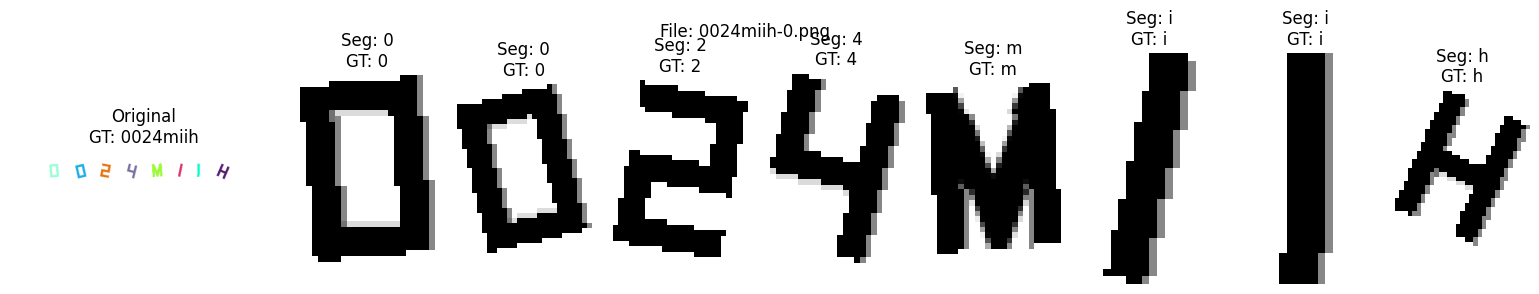

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).


C:\Users\zlr05\AppData\Local\Temp\ipykernel_17380\1630087047.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


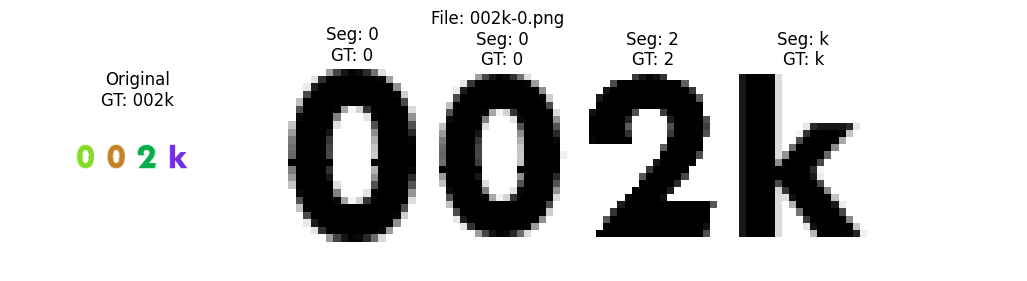

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 78).


C:\Users\zlr05\AppData\Local\Temp\ipykernel_17380\1630087047.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


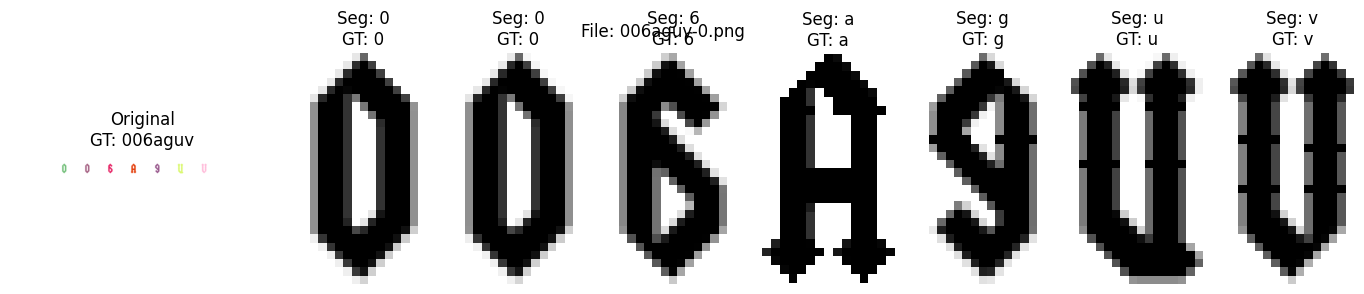

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).


C:\Users\zlr05\AppData\Local\Temp\ipykernel_17380\1630087047.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


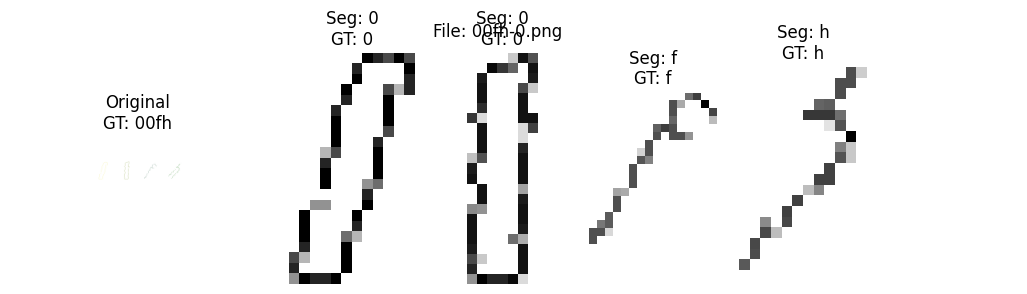

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).


C:\Users\zlr05\AppData\Local\Temp\ipykernel_17380\1630087047.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


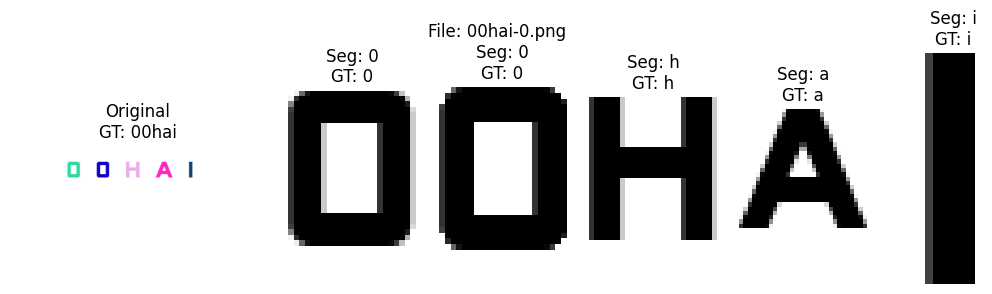

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).


C:\Users\zlr05\AppData\Local\Temp\ipykernel_17380\1630087047.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


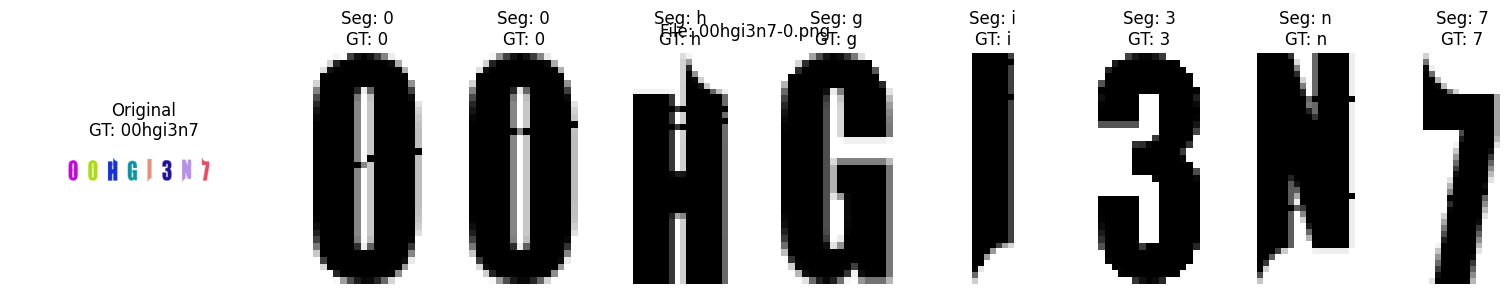

In [6]:
# Visualize original CAPTCHA alongside segmented characters for debugging
from matplotlib.gridspec import GridSpec

n_samples = 6  # how many CAPTCHAs to visualize
samples = train_img_files[:n_samples]

for img_path in samples:
    # Load original
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"[WARN] Could not read {img_path}")
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Ground truth from filename
    gt_text = Path(img_path).stem.split('-')[0]

    # Segment characters using current pipeline
    char_images, char_labels = segment_characters(img_path, min_pixels = 2, top_components = 4, spatial_weight_x=4.014, spatial_weight_y=0.100, contour_weight=400.000)

    # Prepare layout: original on the left, characters on the right
    max_chars = max(len(char_images), len(gt_text)) if len(gt_text) > 0 else len(char_images)
    max_chars = max(5, max_chars)  # keep a minimum width for readability

    fig = plt.figure(figsize=(2 + max_chars * 2.2, 3))
    gs = GridSpec(1, max_chars + 1, width_ratios=[2] + [1] * max_chars, wspace=0.15)

    # Original image
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(img_rgb)
    ax0.set_title(f"Original\nGT: {gt_text}")
    ax0.axis('off')

    # Segmented characters
    for j in range(max_chars):
        ax = fig.add_subplot(gs[0, j + 1])
        if j < len(char_images):
            ch_img = char_images[j]
            # robust grayscale for display
            if ch_img is None or ch_img.size == 0:
                ax.axis('off')
                continue
            if len(ch_img.shape) == 3:
                show_img = cv2.cvtColor(ch_img, cv2.COLOR_BGR2GRAY)
            else:
                show_img = ch_img

            # predicted label from segmentation alignment (label list) if available
            seg_label = char_labels[j] if j < len(char_labels) else '?'
            # expected char at this position (from GT) if available
            gt_char = gt_text[j] if j < len(gt_text) else ' '
            title = f"Seg: {seg_label}\nGT: {gt_char}"

            ax.imshow(show_img, cmap='gray')
            ax.set_title(title)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.suptitle(f"File: {Path(img_path).name}")
    plt.tight_layout()
    plt.show()

## 6. Character Recognition Model

CNN-based model for recognizing individual characters.

In [7]:
class InvertedResidualBlock(nn.Module):
    """
    MobileNetV2-style block with depthwise separable convolutions.
    """
    def __init__(self, in_ch, out_ch, stride=1, expand_ratio=4):
        super().__init__()
        hidden_ch = in_ch * expand_ratio
        self.use_residual = (stride == 1 and in_ch == out_ch)

        self.conv = nn.Sequential(
            # Expand
            nn.Conv2d(in_ch, hidden_ch, 1, bias=False),
            nn.BatchNorm2d(hidden_ch),
            nn.ReLU6(inplace=True),
            # Depthwise
            nn.Conv2d(hidden_ch, hidden_ch, 3, stride=stride, padding=1, 
                     groups=hidden_ch, bias=False),
            nn.BatchNorm2d(hidden_ch),
            nn.ReLU6(inplace=True),
            # Project
            nn.Conv2d(hidden_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
        )

    def forward(self, x):
        if self.use_residual:
            return x + self.conv(x)
        return self.conv(x)


class EfficientCaptchaCNN(nn.Module):
    def __init__(self, num_classes=36, dropout=0.5):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        self.features = nn.Sequential(
            InvertedResidualBlock(32, 32, stride=1, expand_ratio=1),   # 32x32
            InvertedResidualBlock(32, 64, stride=2, expand_ratio=4),   # 16x16
            InvertedResidualBlock(64, 64, stride=1, expand_ratio=4),   
            InvertedResidualBlock(64, 128, stride=2, expand_ratio=4),  # 8x8
            InvertedResidualBlock(128, 128, stride=1, expand_ratio=4), 
            InvertedResidualBlock(128, 256, stride=2, expand_ratio=4), # 4x4
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

# Initialize model
model = EfficientCaptchaCNN(num_classes=VOCAB_SIZE).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

EfficientCaptchaCNN(
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (features): Sequential(
    (0): InvertedResidualBlock(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU6(inplace=True)
        (6): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): InvertedResidualBlock(
      (conv): Sequenti

## 7. Create DataLoaders

In [8]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True  # Drop last incomplete batch to avoid BatchNorm issues
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
    # No drop_last for test - we use model.eval() which disables BatchNorm training mode
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 1463
Test batches: 376


## 8. Training Setup

In [9]:
# Training hyperparameters
NUM_EPOCHS = 20
BASE_LR = 3e-3
MAX_LR = 1e-2
WEIGHT_DECAY = 1e-4

# Loss and optimizer (label smoothing helps robustness)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)

# OneCycleLR for fast convergence with higher LR
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=0.2,
    div_factor=10.0,
    final_div_factor=100.0,
)

## 9. Training Loop

In [10]:
def train_epoch(model, loader, criterion, optimizer, device, scheduler=None, max_grad_norm=1.0):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for imgs, labels, _ in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        # Gradient clipping for stability
        if max_grad_norm is not None and max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        
        # Scheduler step per batch (OneCycle)
        if scheduler is not None:
            scheduler.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'acc': 100. * correct / total
        })
    
    return running_loss / len(loader), 100. * correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for imgs, labels, _ in tqdm(loader, desc="Evaluating"):
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

In [11]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

best_acc = 0.0

# Main training loop
for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scheduler=scheduler)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    # Print summary
    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_char_recognition_model.pth')
        print(f"✓ New best model saved! Accuracy: {best_acc:.2f}%")

print(f"\nTraining complete! Best accuracy: {best_acc:.2f}%")


Epoch 1/20


Evaluating: 100%|██████████| 376/376 [00:07<00:00, 51.94it/s]



Train Loss: 2.1546, Train Acc: 51.62%
Test Loss: 1.6862, Test Acc: 69.45%
✓ New best model saved! Accuracy: 69.45%

Epoch 2/20


Evaluating: 100%|██████████| 376/376 [00:14<00:00, 25.16it/s]



Train Loss: 1.7018, Train Acc: 67.46%
Test Loss: 1.6138, Test Acc: 70.42%
✓ New best model saved! Accuracy: 70.42%

Epoch 3/20


Evaluating: 100%|██████████| 376/376 [00:13<00:00, 28.02it/s]



Train Loss: 1.6167, Train Acc: 70.19%
Test Loss: 1.4983, Test Acc: 74.55%
✓ New best model saved! Accuracy: 74.55%

Epoch 4/20


Evaluating: 100%|██████████| 376/376 [00:14<00:00, 25.42it/s]



Train Loss: 1.5615, Train Acc: 72.08%
Test Loss: 1.4309, Test Acc: 78.19%
✓ New best model saved! Accuracy: 78.19%

Epoch 5/20


Evaluating: 100%|██████████| 376/376 [00:15<00:00, 23.80it/s]



Train Loss: 1.5151, Train Acc: 74.03%
Test Loss: 1.3809, Test Acc: 78.77%
✓ New best model saved! Accuracy: 78.77%

Epoch 6/20


Evaluating: 100%|██████████| 376/376 [00:17<00:00, 21.59it/s]



Train Loss: 1.4697, Train Acc: 75.47%
Test Loss: 1.4270, Test Acc: 77.07%

Epoch 7/20


Evaluating: 100%|██████████| 376/376 [00:13<00:00, 28.90it/s]



Train Loss: 1.4369, Train Acc: 76.67%
Test Loss: 1.3750, Test Acc: 78.80%
✓ New best model saved! Accuracy: 78.80%

Epoch 8/20


Evaluating: 100%|██████████| 376/376 [00:11<00:00, 32.76it/s]



Train Loss: 1.4048, Train Acc: 77.56%
Test Loss: 1.3058, Test Acc: 81.52%
✓ New best model saved! Accuracy: 81.52%

Epoch 9/20


Evaluating: 100%|██████████| 376/376 [00:14<00:00, 26.39it/s]



Train Loss: 1.3670, Train Acc: 78.76%
Test Loss: 1.2859, Test Acc: 82.55%
✓ New best model saved! Accuracy: 82.55%

Epoch 10/20


Evaluating: 100%|██████████| 376/376 [00:12<00:00, 29.06it/s]



Train Loss: 1.3342, Train Acc: 80.05%
Test Loss: 1.2623, Test Acc: 82.91%
✓ New best model saved! Accuracy: 82.91%

Epoch 11/20


Evaluating: 100%|██████████| 376/376 [00:15<00:00, 24.36it/s]



Train Loss: 1.3023, Train Acc: 81.03%
Test Loss: 1.2452, Test Acc: 83.39%
✓ New best model saved! Accuracy: 83.39%

Epoch 12/20


Evaluating: 100%|██████████| 376/376 [00:12<00:00, 30.21it/s]



Train Loss: 1.2708, Train Acc: 81.79%
Test Loss: 1.2137, Test Acc: 84.55%
✓ New best model saved! Accuracy: 84.55%

Epoch 13/20


Evaluating: 100%|██████████| 376/376 [00:11<00:00, 31.70it/s]



Train Loss: 1.2416, Train Acc: 83.16%
Test Loss: 1.1936, Test Acc: 85.30%
✓ New best model saved! Accuracy: 85.30%

Epoch 14/20


Evaluating: 100%|██████████| 376/376 [00:12<00:00, 29.49it/s]



Train Loss: 1.2138, Train Acc: 83.93%
Test Loss: 1.2093, Test Acc: 84.79%

Epoch 15/20


Evaluating: 100%|██████████| 376/376 [00:13<00:00, 27.69it/s]



Train Loss: 1.1905, Train Acc: 84.64%
Test Loss: 1.1635, Test Acc: 86.15%
✓ New best model saved! Accuracy: 86.15%

Epoch 16/20


Evaluating: 100%|██████████| 376/376 [00:15<00:00, 24.50it/s]



Train Loss: 1.1663, Train Acc: 85.35%
Test Loss: 1.1474, Test Acc: 86.73%
✓ New best model saved! Accuracy: 86.73%

Epoch 17/20


Evaluating: 100%|██████████| 376/376 [00:06<00:00, 55.85it/s]



Train Loss: 1.1496, Train Acc: 85.98%
Test Loss: 1.1382, Test Acc: 86.86%
✓ New best model saved! Accuracy: 86.86%

Epoch 18/20


Evaluating: 100%|██████████| 376/376 [00:06<00:00, 55.02it/s]



Train Loss: 1.1349, Train Acc: 86.42%
Test Loss: 1.1325, Test Acc: 87.10%
✓ New best model saved! Accuracy: 87.10%

Epoch 19/20


Evaluating: 100%|██████████| 376/376 [00:06<00:00, 54.48it/s]



Train Loss: 1.1258, Train Acc: 86.63%
Test Loss: 1.1318, Test Acc: 87.21%
✓ New best model saved! Accuracy: 87.21%

Epoch 20/20


Evaluating: 100%|██████████| 376/376 [00:06<00:00, 55.72it/s]


Train Loss: 1.1187, Train Acc: 86.90%
Test Loss: 1.1291, Test Acc: 87.28%
✓ New best model saved! Accuracy: 87.28%

Training complete! Best accuracy: 87.28%


## 10. Visualize Training History

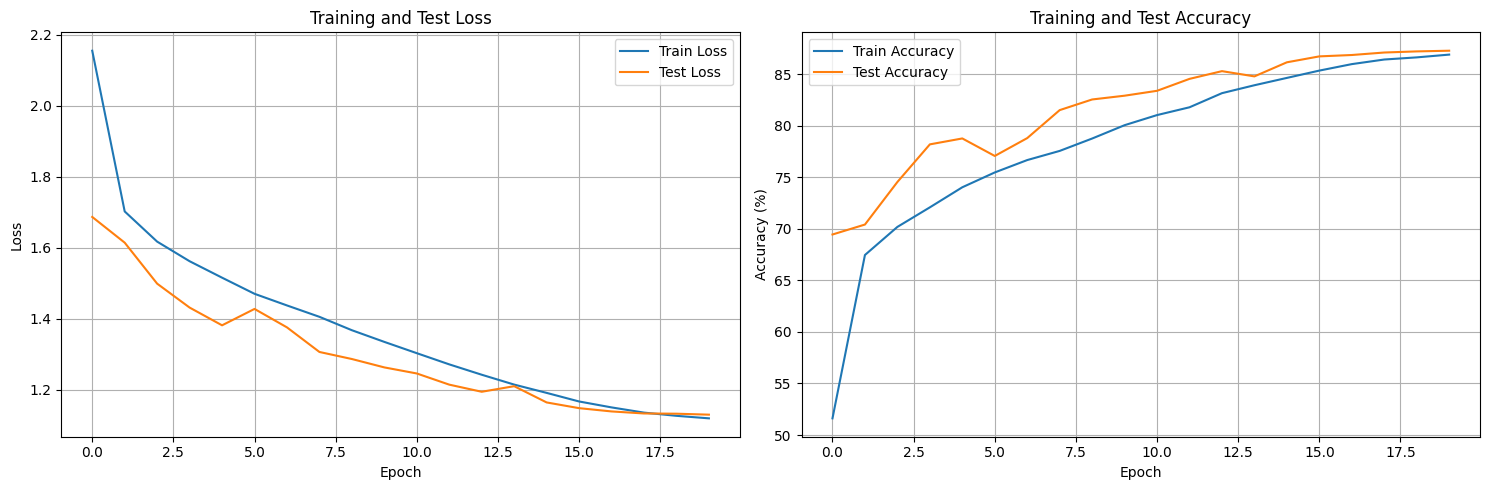

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['test_loss'], label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 11. Full CAPTCHA Recognition

Combine segmentation + recognition to decode complete CAPTCHAs.

In [13]:
def recognize_captcha(model, image_path, device, target_size=(32, 32)):
    """
    Recognize a full CAPTCHA by:
    1. Segmenting characters
    2. Recognizing each character with the CNN model
    3. Combining predictions
    """
    model.eval()
    
    # Segment characters
    char_images, _ = segment_characters(image_path, min_pixels = 2, top_components = 4, spatial_weight_x=4.014, spatial_weight_y=0.100, contour_weight=400.000)
    
    if not char_images:
        return "", []
    
    predictions = []
    confidences = []
    
    with torch.no_grad():
        for char_img in char_images:
            # Preprocess
            if len(char_img.shape) == 3:
                char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
            
            h, w = char_img.shape
            target_h, target_w = target_size
            
            # Check for invalid dimensions
            if h <= 0 or w <= 0:
                continue  # Skip invalid images
            
            scale = min(target_h / h, target_w / w)
            new_h, new_w = int(h * scale), int(w * scale)
            
            # Ensure minimum size of 1x1
            new_h = max(1, new_h)
            new_w = max(1, new_w)
            
            char_img = cv2.resize(char_img, (new_w, new_h))
            
            canvas = np.ones((target_h, target_w), dtype=np.uint8) * 255
            y_offset = (target_h - new_h) // 2
            x_offset = (target_w - new_w) // 2
            canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = char_img
            
            # Convert to tensor
            char_tensor = torch.from_numpy(canvas).float() / 255.0
            char_tensor = char_tensor.unsqueeze(0).repeat(3, 1, 1)  # 3 channels
            char_tensor = char_tensor.unsqueeze(0).to(device)  # Add batch dimension
            
            # Predict
            output = model(char_tensor)
            probs = F.softmax(output, dim=1)
            confidence, predicted = probs.max(1)
            
            pred_char = id2ch[predicted.item()]
            predictions.append(pred_char)
            confidences.append(confidence.item())
    
    result = ''.join(predictions)
    return result, confidences


def visualize_captcha_prediction(image_path, model, device):
    """
    Visualize CAPTCHA recognition result
    """
    # Get ground truth
    filename = Path(image_path).stem
    gt_text = filename.split('-')[0]
    
    # Predict
    pred_text, confidences = recognize_captcha(model, image_path, device)
    
    # Load and display image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 4))
    plt.imshow(img_rgb)
    plt.title(f"Ground Truth: {gt_text}\nPrediction: {pred_text}\nConfidence: {np.mean(confidences):.3f}")
    plt.axis('off')
    plt.show()
    
    return gt_text, pred_text

## 12. Test on Sample CAPTCHAs

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).


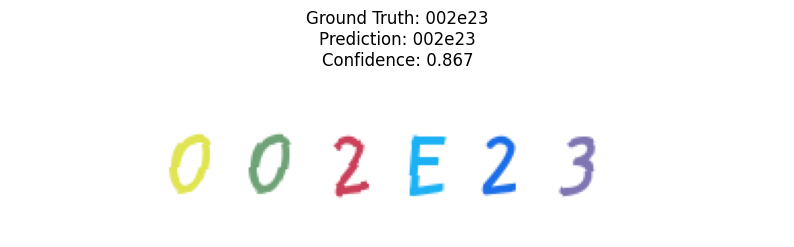

✓ Correct!

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).


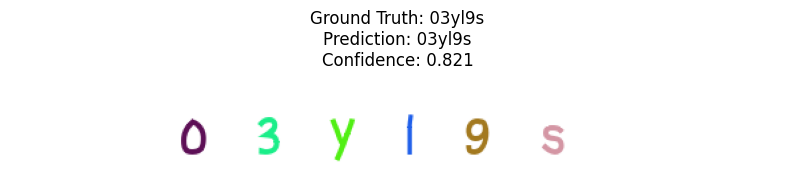

✓ Correct!

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).


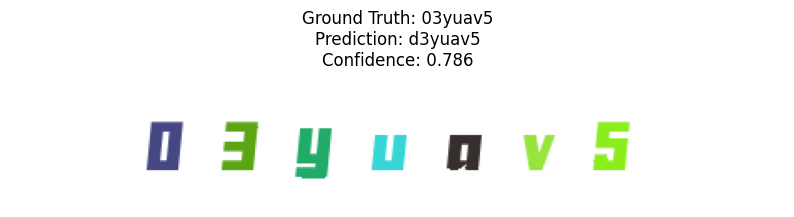

✗ Wrong. GT: 03yuav5, Pred: d3yuav5

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).


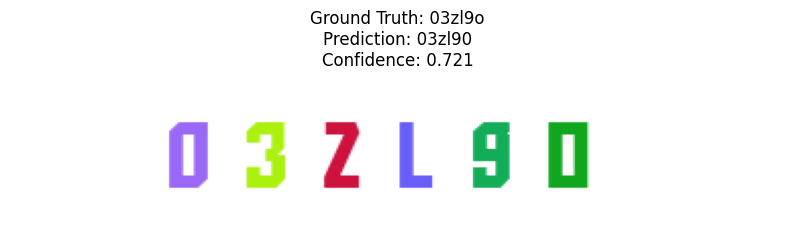

✗ Wrong. GT: 03zl9o, Pred: 03zl90

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 7).


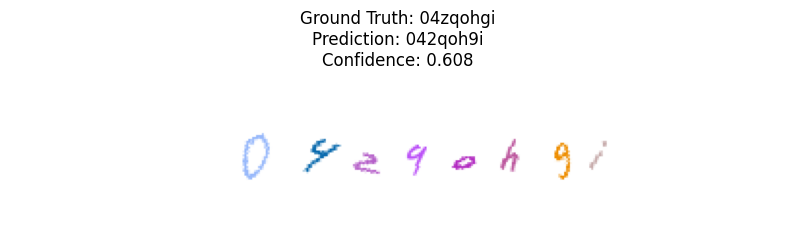

✗ Wrong. GT: 04zqohgi, Pred: 042qoh9i

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).


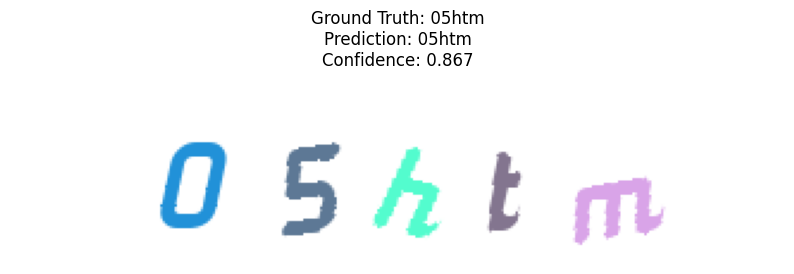

✓ Correct!

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 145).


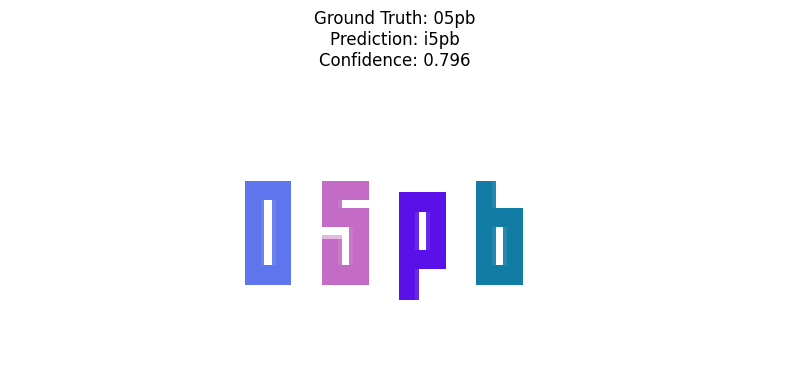

✗ Wrong. GT: 05pb, Pred: i5pb

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).


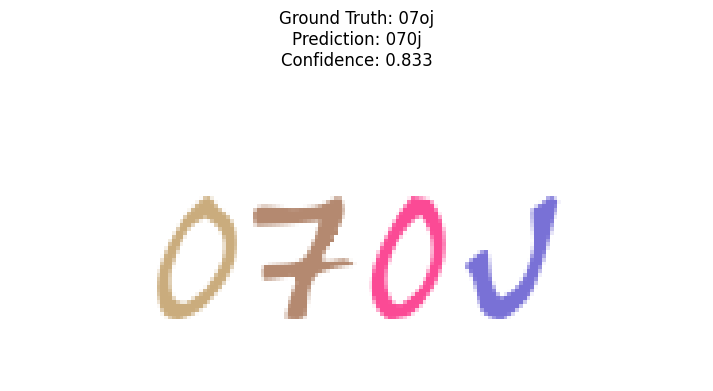

✗ Wrong. GT: 07oj, Pred: 070j

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).


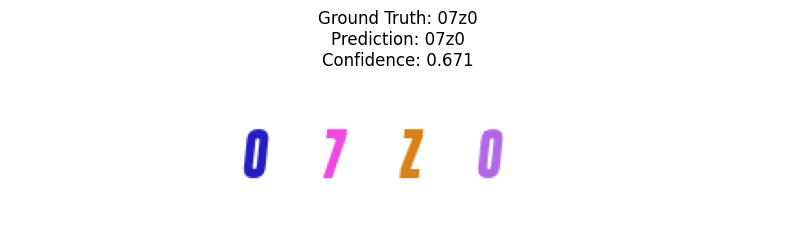

✓ Correct!

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).


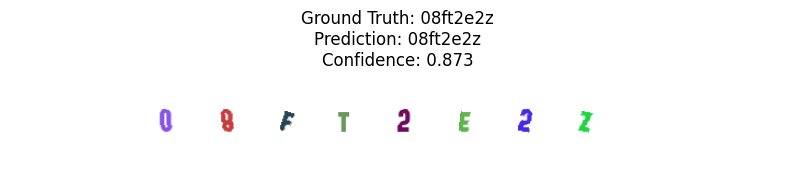

✓ Correct!


Accuracy: 5/10 = 50.00%


In [17]:
# Load best model
model.load_state_dict(torch.load('best_char_recognition_model.pth'))
model.eval()

# Test on a few samples
test_samples = test_img_files[:10]

correct = 0
total = len(test_samples)

for img_path in test_samples:
    gt, pred = visualize_captcha_prediction(img_path, model, device)
    if gt == pred:
        correct += 1
        print(f"✓ Correct!\n")
    else:
        print(f"✗ Wrong. GT: {gt}, Pred: {pred}\n")

print(f"\nAccuracy: {correct}/{total} = {100*correct/total:.2f}%")

## 13. Full Test Set Evaluation

In [15]:
def evaluate_full_captchas(model, img_paths, device):
    """
    Evaluate on full CAPTCHA images
    """
    model.eval()
    
    total = 0
    correct = 0
    char_total = 0
    char_correct = 0
    
    for img_path in tqdm(img_paths, desc="Evaluating CAPTCHAs"):
        try:
            filename = Path(img_path).stem
            gt_text = filename.split('-')[0].lower()
            
            pred_text, _ = recognize_captcha(model, img_path, device)
            pred_text = pred_text.lower()
            
            total += 1
            if gt_text == pred_text:
                correct += 1
            
            # Character-level accuracy
            for gt_ch, pred_ch in zip(gt_text, pred_text):
                char_total += 1
                if gt_ch == pred_ch:
                    char_correct += 1
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    seq_acc = 100 * correct / total if total > 0 else 0
    char_acc = 100 * char_correct / char_total if char_total > 0 else 0
    
    print(f"\nResults on {total} CAPTCHAs:")
    print(f"Sequence Accuracy: {seq_acc:.2f}% ({correct}/{total})")
    print(f"Character Accuracy: {char_acc:.2f}% ({char_correct}/{char_total})")
    
    return seq_acc, char_acc


# Evaluate on test set
test_seq_acc, test_char_acc = evaluate_full_captchas(model, test_img_files, device)

Evaluating CAPTCHAs:   0%|          | 0/2000 [00:00<?, ?it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:   0%|          | 2/2000 [00:00<06:58,  4.78it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 3/2000 [00:00<07:10,  4.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 4/2000 [00:00<07:12,  4.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 7).


Evaluating CAPTCHAs:   0%|          | 6/2000 [00:01<06:37,  5.02it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 8/2000 [00:01<05:34,  5.95it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 145).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 9/2000 [00:01<05:24,  6.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:   1%|          | 11/2000 [00:02<06:02,  5.48it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 12/2000 [00:02<06:54,  4.80it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:   1%|          | 14/2000 [00:02<06:22,  5.19it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 15/2000 [00:02<06:17,  5.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:   1%|          | 17/2000 [00:03<05:48,  5.69it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 18/2000 [00:03<06:29,  5.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 19/2000 [00:03<06:58,  4.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:   1%|          | 21/2000 [00:04<05:55,  5.57it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 22/2000 [00:04<05:32,  5.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:   1%|          | 24/2000 [00:04<05:51,  5.63it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 2).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   1%|▏         | 25/2000 [00:04<05:18,  6.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:   1%|▏         | 26/2000 [00:04<05:21,  6.13it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 325).


Evaluating CAPTCHAs:   1%|▏         | 28/2000 [00:05<06:17,  5.23it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   1%|▏         | 29/2000 [00:05<06:05,  5.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 30/2000 [00:05<06:39,  4.93it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 88).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).


Evaluating CAPTCHAs:   2%|▏         | 32/2000 [00:06<05:58,  5.48it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 33/2000 [00:06<05:40,  5.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:   2%|▏         | 35/2000 [00:06<05:34,  5.88it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 36/2000 [00:06<05:16,  6.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:   2%|▏         | 38/2000 [00:06<05:25,  6.02it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 39/2000 [00:07<05:33,  5.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:   2%|▏         | 40/2000 [00:07<05:50,  5.59it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:   2%|▏         | 42/2000 [00:07<06:10,  5.29it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 43/2000 [00:07<06:18,  5.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 44/2000 [00:08<06:30,  5.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:   2%|▏         | 46/2000 [00:08<06:30,  5.01it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 47/2000 [00:08<05:58,  5.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:   2%|▏         | 48/2000 [00:08<05:40,  5.73it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:   2%|▎         | 50/2000 [00:09<05:32,  5.86it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 51/2000 [00:09<05:17,  6.15it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:   3%|▎         | 53/2000 [00:09<05:20,  6.07it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 54/2000 [00:09<05:11,  6.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:   3%|▎         | 55/2000 [00:10<05:19,  6.09it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:   3%|▎         | 57/2000 [00:10<05:51,  5.53it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 58/2000 [00:10<06:05,  5.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 59/2000 [00:10<06:33,  4.94it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).


Evaluating CAPTCHAs:   3%|▎         | 60/2000 [00:11<06:03,  5.34it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).


Evaluating CAPTCHAs:   3%|▎         | 61/2000 [00:11<06:12,  5.21it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:   3%|▎         | 63/2000 [00:11<06:04,  5.31it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 64/2000 [00:11<06:18,  5.12it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 87).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:   3%|▎         | 66/2000 [00:12<05:28,  5.90it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 67/2000 [00:12<05:24,  5.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:   3%|▎         | 69/2000 [00:12<04:51,  6.62it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   4%|▎         | 70/2000 [00:12<05:13,  6.15it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:   4%|▎         | 72/2000 [00:13<04:50,  6.65it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   4%|▎         | 73/2000 [00:13<05:09,  6.22it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   4%|▎         | 74/2000 [00:13<05:41,  5.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:   4%|▍         | 76/2000 [00:13<05:33,  5.77it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 142).


Evaluating CAPTCHAs:   4%|▍         | 78/2000 [00:14<05:26,  5.88it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:   4%|▍         | 79/2000 [00:14<05:01,  6.38it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 341).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 80/2000 [00:14<05:54,  5.42it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:   4%|▍         | 82/2000 [00:14<05:46,  5.54it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 83/2000 [00:15<05:49,  5.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 84/2000 [00:15<06:17,  5.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 85/2000 [00:15<06:49,  4.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 86/2000 [00:15<07:03,  4.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:   4%|▍         | 88/2000 [00:16<05:44,  5.56it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 89/2000 [00:16<05:36,  5.67it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 114).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:   5%|▍         | 91/2000 [00:16<05:23,  5.91it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   5%|▍         | 92/2000 [00:16<05:07,  6.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:   5%|▍         | 94/2000 [00:17<05:56,  5.35it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   5%|▍         | 95/2000 [00:17<05:50,  5.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).


Evaluating CAPTCHAs:   5%|▍         | 96/2000 [00:17<05:52,  5.39it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:   5%|▍         | 98/2000 [00:17<06:02,  5.25it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 100).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   5%|▍         | 99/2000 [00:18<06:10,  5.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   5%|▌         | 100/2000 [00:18<06:52,  4.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:   5%|▌         | 102/2000 [00:18<05:50,  5.42it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   5%|▌         | 103/2000 [00:18<05:28,  5.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:   5%|▌         | 105/2000 [00:19<05:40,  5.57it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   5%|▌         | 106/2000 [00:19<05:42,  5.52it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:   5%|▌         | 108/2000 [00:19<05:31,  5.71it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   5%|▌         | 109/2000 [00:19<05:24,  5.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:   6%|▌         | 110/2000 [00:20<05:47,  5.43it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:   6%|▌         | 112/2000 [00:20<05:46,  5.44it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 113/2000 [00:20<05:55,  5.30it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 114/2000 [00:20<06:22,  4.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:   6%|▌         | 115/2000 [00:21<06:25,  4.89it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:   6%|▌         | 117/2000 [00:21<06:19,  4.96it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 118/2000 [00:21<06:22,  4.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:   6%|▌         | 119/2000 [00:21<05:48,  5.40it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).


Evaluating CAPTCHAs:   6%|▌         | 121/2000 [00:22<06:15,  5.00it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:   6%|▌         | 122/2000 [00:22<05:53,  5.31it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 124/2000 [00:22<04:54,  6.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   6%|▋         | 125/2000 [00:22<05:07,  6.10it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:   6%|▋         | 127/2000 [00:23<05:01,  6.20it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   6%|▋         | 128/2000 [00:23<05:14,  5.94it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:   6%|▋         | 129/2000 [00:23<05:05,  6.12it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 62).


Evaluating CAPTCHAs:   7%|▋         | 131/2000 [00:23<05:44,  5.42it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 132/2000 [00:24<05:38,  5.51it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:   7%|▋         | 134/2000 [00:24<05:20,  5.83it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 135/2000 [00:24<05:41,  5.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:   7%|▋         | 137/2000 [00:24<05:38,  5.51it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 138/2000 [00:25<05:37,  5.51it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 199).


Evaluating CAPTCHAs:   7%|▋         | 139/2000 [00:25<05:57,  5.21it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:   7%|▋         | 140/2000 [00:25<06:15,  4.96it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:   7%|▋         | 141/2000 [00:25<06:19,  4.89it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:   7%|▋         | 143/2000 [00:26<06:10,  5.01it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 144/2000 [00:26<05:31,  5.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:   7%|▋         | 146/2000 [00:26<05:15,  5.88it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 147/2000 [00:26<05:40,  5.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:   7%|▋         | 149/2000 [00:27<05:37,  5.48it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 150/2000 [00:27<06:06,  5.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:   8%|▊         | 151/2000 [00:27<06:01,  5.12it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:   8%|▊         | 153/2000 [00:28<05:55,  5.19it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 154/2000 [00:28<05:33,  5.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 60).


Evaluating CAPTCHAs:   8%|▊         | 156/2000 [00:28<05:01,  6.12it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 157/2000 [00:28<05:39,  5.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 158/2000 [00:28<05:57,  5.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:   8%|▊         | 160/2000 [00:29<05:33,  5.52it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 161/2000 [00:29<05:09,  5.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:   8%|▊         | 163/2000 [00:29<05:03,  6.05it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 164/2000 [00:29<04:57,  6.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:   8%|▊         | 166/2000 [00:30<05:05,  6.01it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 167/2000 [00:30<05:28,  5.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 168/2000 [00:30<05:25,  5.62it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 365).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:   8%|▊         | 170/2000 [00:31<05:36,  5.43it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   9%|▊         | 171/2000 [00:31<05:32,  5.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:   9%|▊         | 172/2000 [00:31<05:26,  5.60it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:   9%|▊         | 174/2000 [00:31<05:38,  5.40it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 175/2000 [00:31<05:20,  5.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:   9%|▉         | 177/2000 [00:32<05:18,  5.73it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 178/2000 [00:32<05:25,  5.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:   9%|▉         | 180/2000 [00:32<05:02,  6.01it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 181/2000 [00:32<05:27,  5.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:   9%|▉         | 183/2000 [00:33<05:21,  5.66it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 184/2000 [00:33<04:47,  6.31it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 61).


Evaluating CAPTCHAs:   9%|▉         | 185/2000 [00:33<04:52,  6.20it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:   9%|▉         | 187/2000 [00:33<05:00,  6.03it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 188/2000 [00:34<05:42,  5.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  10%|▉         | 190/2000 [00:34<05:31,  5.47it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 191/2000 [00:34<05:27,  5.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  10%|▉         | 193/2000 [00:35<05:23,  5.59it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 194/2000 [00:35<05:01,  5.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  10%|▉         | 196/2000 [00:35<05:24,  5.56it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 197/2000 [00:35<05:03,  5.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  10%|▉         | 199/2000 [00:36<04:43,  6.35it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 200/2000 [00:36<04:52,  6.15it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  10%|█         | 201/2000 [00:36<04:37,  6.48it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  10%|█         | 202/2000 [00:36<05:26,  5.51it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs:  10%|█         | 204/2000 [00:37<05:36,  5.33it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 205/2000 [00:37<06:08,  4.88it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 206/2000 [00:37<06:02,  4.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  10%|█         | 208/2000 [00:37<05:20,  5.60it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 209/2000 [00:37<05:25,  5.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  11%|█         | 211/2000 [00:38<04:51,  6.13it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 212/2000 [00:38<04:41,  6.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  11%|█         | 214/2000 [00:38<04:23,  6.78it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 215/2000 [00:38<04:19,  6.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  11%|█         | 217/2000 [00:39<04:45,  6.25it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 219/2000 [00:39<04:14,  7.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 220/2000 [00:39<04:24,  6.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 221/2000 [00:39<05:05,  5.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  11%|█         | 223/2000 [00:40<05:11,  5.71it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 224/2000 [00:40<05:34,  5.30it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  11%|█▏        | 226/2000 [00:40<04:53,  6.05it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  11%|█▏        | 227/2000 [00:40<05:09,  5.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  11%|█▏        | 228/2000 [00:41<05:17,  5.59it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  11%|█▏        | 229/2000 [00:41<05:33,  5.32it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  12%|█▏        | 230/2000 [00:41<05:41,  5.19it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 105).


Evaluating CAPTCHAs:  12%|█▏        | 232/2000 [00:41<05:42,  5.16it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 233/2000 [00:42<05:50,  5.04it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 234/2000 [00:42<05:42,  5.15it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 276).


Evaluating CAPTCHAs:  12%|█▏        | 236/2000 [00:42<05:43,  5.14it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  12%|█▏        | 237/2000 [00:42<05:47,  5.08it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  12%|█▏        | 238/2000 [00:42<05:32,  5.30it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 239/2000 [00:43<05:16,  5.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).


Evaluating CAPTCHAs:  12%|█▏        | 241/2000 [00:43<05:00,  5.86it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  12%|█▏        | 243/2000 [00:43<04:49,  6.07it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 244/2000 [00:43<04:33,  6.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  12%|█▏        | 246/2000 [00:44<04:39,  6.28it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 247/2000 [00:44<04:39,  6.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  12%|█▏        | 249/2000 [00:44<04:40,  6.24it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 251/2000 [00:45<04:19,  6.74it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  13%|█▎        | 252/2000 [00:45<04:57,  5.87it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  13%|█▎        | 254/2000 [00:45<05:05,  5.71it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 255/2000 [00:45<04:50,  6.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  13%|█▎        | 257/2000 [00:46<04:33,  6.37it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 258/2000 [00:46<04:42,  6.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  13%|█▎        | 260/2000 [00:46<04:32,  6.38it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 261/2000 [00:46<04:15,  6.81it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 6).


Evaluating CAPTCHAs:  13%|█▎        | 263/2000 [00:46<04:23,  6.58it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 264/2000 [00:47<04:26,  6.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 265/2000 [00:47<04:51,  5.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  13%|█▎        | 267/2000 [00:47<04:51,  5.94it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 268/2000 [00:47<04:55,  5.86it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  14%|█▎        | 270/2000 [00:48<04:10,  6.91it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  14%|█▎        | 272/2000 [00:48<04:13,  6.81it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▎        | 274/2000 [00:48<03:57,  7.26it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 275/2000 [00:48<04:20,  6.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 97).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  14%|█▍        | 276/2000 [00:48<04:13,  6.80it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  14%|█▍        | 278/2000 [00:49<04:57,  5.78it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 279/2000 [00:49<04:48,  5.97it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 280/2000 [00:49<05:30,  5.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  14%|█▍        | 282/2000 [00:50<04:58,  5.75it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 283/2000 [00:50<04:44,  6.03it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  14%|█▍        | 285/2000 [00:50<04:28,  6.39it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 286/2000 [00:50<04:15,  6.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  14%|█▍        | 288/2000 [00:51<04:48,  5.94it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 289/2000 [00:51<04:56,  5.77it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▍        | 290/2000 [00:51<05:08,  5.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 131).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  15%|█▍        | 292/2000 [00:51<04:36,  6.19it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▍        | 293/2000 [00:51<04:29,  6.33it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  15%|█▍        | 295/2000 [00:52<04:52,  5.83it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▍        | 296/2000 [00:52<04:42,  6.04it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  15%|█▍        | 298/2000 [00:52<05:04,  5.59it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▍        | 299/2000 [00:52<05:03,  5.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  15%|█▌        | 301/2000 [00:53<04:49,  5.86it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 302/2000 [00:53<04:30,  6.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  15%|█▌        | 304/2000 [00:53<04:18,  6.56it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 305/2000 [00:53<04:13,  6.68it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 65).


Evaluating CAPTCHAs:  15%|█▌        | 307/2000 [00:54<04:51,  5.81it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 308/2000 [00:54<05:11,  5.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 309/2000 [00:54<05:26,  5.17it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  16%|█▌        | 311/2000 [00:54<05:22,  5.24it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 312/2000 [00:55<05:34,  5.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 313/2000 [00:55<05:47,  4.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).


Evaluating CAPTCHAs:  16%|█▌        | 315/2000 [00:55<05:10,  5.43it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 317/2000 [00:56<04:22,  6.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 319/2000 [00:56<04:01,  6.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 320/2000 [00:56<04:02,  6.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  16%|█▌        | 322/2000 [00:56<04:31,  6.17it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▌        | 323/2000 [00:56<04:18,  6.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  16%|█▋        | 325/2000 [00:57<04:37,  6.03it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▋        | 326/2000 [00:57<04:49,  5.79it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  16%|█▋        | 328/2000 [00:57<04:44,  5.87it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▋        | 329/2000 [00:57<04:38,  6.00it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▋        | 330/2000 [00:58<05:02,  5.52it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 331/2000 [00:58<05:05,  5.47it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  17%|█▋        | 332/2000 [00:58<04:56,  5.63it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  17%|█▋        | 334/2000 [00:58<04:50,  5.74it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 102).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 335/2000 [00:59<04:52,  5.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).


Evaluating CAPTCHAs:  17%|█▋        | 337/2000 [00:59<04:41,  5.90it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 338/2000 [00:59<04:51,  5.69it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  17%|█▋        | 340/2000 [00:59<04:48,  5.75it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 341/2000 [01:00<04:32,  6.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  17%|█▋        | 343/2000 [01:00<04:34,  6.03it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 344/2000 [01:00<04:18,  6.41it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 179).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  17%|█▋        | 346/2000 [01:00<04:12,  6.54it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  17%|█▋        | 347/2000 [01:01<04:29,  6.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  17%|█▋        | 348/2000 [01:01<04:36,  5.97it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs:  17%|█▋        | 349/2000 [01:01<05:06,  5.40it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  18%|█▊        | 351/2000 [01:01<05:17,  5.20it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 89).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 352/2000 [01:01<05:06,  5.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  18%|█▊        | 354/2000 [01:02<04:46,  5.75it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 355/2000 [01:02<04:41,  5.84it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  18%|█▊        | 357/2000 [01:02<04:26,  6.16it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 358/2000 [01:02<04:34,  5.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 92).


Evaluating CAPTCHAs:  18%|█▊        | 360/2000 [01:03<04:55,  5.54it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 361/2000 [01:03<04:58,  5.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  18%|█▊        | 363/2000 [01:03<04:30,  6.06it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 364/2000 [01:04<05:03,  5.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 365/2000 [01:04<05:27,  4.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  18%|█▊        | 367/2000 [01:04<04:39,  5.84it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  18%|█▊        | 369/2000 [01:04<04:26,  6.13it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 370/2000 [01:05<04:47,  5.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▊        | 371/2000 [01:05<05:13,  5.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  19%|█▊        | 372/2000 [01:05<04:50,  5.60it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  19%|█▊        | 374/2000 [01:05<05:06,  5.31it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 375/2000 [01:06<04:39,  5.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  19%|█▉        | 377/2000 [01:06<04:52,  5.54it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 379/2000 [01:06<04:17,  6.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  19%|█▉        | 380/2000 [01:06<04:15,  6.34it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 381/2000 [01:07<04:36,  5.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  19%|█▉        | 383/2000 [01:07<04:13,  6.38it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 384/2000 [01:07<04:13,  6.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 385/2000 [01:07<04:55,  5.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  19%|█▉        | 387/2000 [01:08<04:46,  5.63it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 388/2000 [01:08<04:52,  5.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  19%|█▉        | 389/2000 [01:08<05:13,  5.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  20%|█▉        | 391/2000 [01:08<04:39,  5.76it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 392/2000 [01:09<04:37,  5.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  20%|█▉        | 394/2000 [01:09<04:26,  6.03it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 395/2000 [01:09<04:11,  6.39it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  20%|█▉        | 397/2000 [01:09<04:28,  5.96it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 399/2000 [01:10<04:00,  6.65it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 400/2000 [01:10<04:17,  6.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  20%|██        | 402/2000 [01:10<04:12,  6.32it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 403/2000 [01:10<04:07,  6.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  20%|██        | 405/2000 [01:11<04:02,  6.58it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 925).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 406/2000 [01:11<04:32,  5.85it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  20%|██        | 408/2000 [01:11<04:33,  5.81it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 410/2000 [01:11<04:15,  6.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 101).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  21%|██        | 411/2000 [01:12<04:19,  6.13it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 413/2000 [01:12<03:59,  6.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  21%|██        | 414/2000 [01:12<04:00,  6.60it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 415/2000 [01:12<04:39,  5.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 416/2000 [01:12<05:04,  5.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  21%|██        | 418/2000 [01:13<04:45,  5.54it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 419/2000 [01:13<04:27,  5.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 85).


Evaluating CAPTCHAs:  21%|██        | 421/2000 [01:13<04:32,  5.80it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 422/2000 [01:13<04:14,  6.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  21%|██        | 424/2000 [01:14<04:41,  5.60it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  21%|██▏       | 425/2000 [01:14<04:54,  5.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  21%|██▏       | 427/2000 [01:14<04:37,  5.67it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  21%|██▏       | 428/2000 [01:15<04:46,  5.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  21%|██▏       | 429/2000 [01:15<05:01,  5.21it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  22%|██▏       | 431/2000 [01:15<04:29,  5.81it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 432/2000 [01:15<04:25,  5.90it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 197).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  22%|██▏       | 434/2000 [01:16<04:35,  5.67it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 435/2000 [01:16<04:24,  5.92it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  22%|██▏       | 437/2000 [01:16<04:39,  5.60it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 438/2000 [01:16<04:46,  5.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  22%|██▏       | 440/2000 [01:17<04:37,  5.63it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 441/2000 [01:17<04:41,  5.54it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 102).


Evaluating CAPTCHAs:  22%|██▏       | 442/2000 [01:17<04:21,  5.95it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  22%|██▏       | 444/2000 [01:17<04:21,  5.95it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 445/2000 [01:18<04:12,  6.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).


Evaluating CAPTCHAs:  22%|██▏       | 447/2000 [01:18<03:50,  6.74it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 448/2000 [01:18<03:40,  7.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  22%|██▎       | 450/2000 [01:18<04:32,  5.68it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 451/2000 [01:18<04:10,  6.18it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  23%|██▎       | 453/2000 [01:19<03:51,  6.70it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 454/2000 [01:19<03:50,  6.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  23%|██▎       | 456/2000 [01:19<04:09,  6.18it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 457/2000 [01:19<03:55,  6.56it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  23%|██▎       | 459/2000 [01:20<03:50,  6.67it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 460/2000 [01:20<04:07,  6.22it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  23%|██▎       | 462/2000 [01:20<04:05,  6.26it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 463/2000 [01:20<04:04,  6.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  23%|██▎       | 465/2000 [01:21<03:50,  6.67it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 466/2000 [01:21<03:47,  6.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  23%|██▎       | 468/2000 [01:21<04:02,  6.33it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 469/2000 [01:21<04:32,  5.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  24%|██▎       | 471/2000 [01:22<04:10,  6.10it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▎       | 473/2000 [01:22<03:42,  6.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▎       | 474/2000 [01:22<03:54,  6.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  24%|██▍       | 476/2000 [01:22<03:51,  6.57it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 477/2000 [01:23<04:08,  6.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 478/2000 [01:23<04:27,  5.68it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  24%|██▍       | 480/2000 [01:23<04:26,  5.71it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 482/2000 [01:23<03:54,  6.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 483/2000 [01:24<04:06,  6.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).


Evaluating CAPTCHAs:  24%|██▍       | 485/2000 [01:24<03:59,  6.32it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 486/2000 [01:24<04:14,  5.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  24%|██▍       | 488/2000 [01:24<04:22,  5.77it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 489/2000 [01:25<04:47,  5.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 151).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  24%|██▍       | 490/2000 [01:25<04:25,  5.68it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  25%|██▍       | 492/2000 [01:25<04:26,  5.66it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▍       | 493/2000 [01:25<04:06,  6.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  25%|██▍       | 495/2000 [01:26<04:06,  6.09it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▍       | 497/2000 [01:26<03:50,  6.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▍       | 498/2000 [01:26<03:38,  6.87it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  25%|██▌       | 500/2000 [01:26<03:45,  6.66it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 501/2000 [01:27<03:41,  6.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 502/2000 [01:27<04:15,  5.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  25%|██▌       | 504/2000 [01:27<03:50,  6.50it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 505/2000 [01:27<04:16,  5.84it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  25%|██▌       | 506/2000 [01:27<04:29,  5.54it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).


Evaluating CAPTCHAs:  25%|██▌       | 508/2000 [01:28<05:06,  4.86it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 509/2000 [01:28<05:26,  4.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 510/2000 [01:28<05:36,  4.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  26%|██▌       | 512/2000 [01:29<04:57,  5.00it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 81).


Evaluating CAPTCHAs:  26%|██▌       | 513/2000 [01:29<04:56,  5.01it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 514/2000 [01:29<04:32,  5.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  26%|██▌       | 516/2000 [01:29<04:26,  5.57it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 517/2000 [01:30<04:47,  5.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  26%|██▌       | 519/2000 [01:30<04:16,  5.77it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 520/2000 [01:30<04:19,  5.70it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  26%|██▌       | 522/2000 [01:30<04:07,  5.97it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 523/2000 [01:31<03:58,  6.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 90).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).


Evaluating CAPTCHAs:  26%|██▋       | 525/2000 [01:31<03:59,  6.17it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▋       | 526/2000 [01:31<04:09,  5.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).


Evaluating CAPTCHAs:  26%|██▋       | 528/2000 [01:31<04:03,  6.05it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▋       | 530/2000 [01:32<03:37,  6.76it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 531/2000 [01:32<03:44,  6.54it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  27%|██▋       | 533/2000 [01:32<03:56,  6.21it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 534/2000 [01:32<04:05,  5.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:  27%|██▋       | 536/2000 [01:33<03:47,  6.45it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 537/2000 [01:33<03:32,  6.87it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  27%|██▋       | 539/2000 [01:33<03:28,  7.00it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 540/2000 [01:33<03:25,  7.11it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  27%|██▋       | 542/2000 [01:34<04:02,  6.02it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 543/2000 [01:34<03:48,  6.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).


Evaluating CAPTCHAs:  27%|██▋       | 545/2000 [01:34<04:10,  5.80it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 546/2000 [01:34<03:48,  6.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  27%|██▋       | 548/2000 [01:35<03:50,  6.29it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 549/2000 [01:35<04:02,  5.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 180).


Evaluating CAPTCHAs:  28%|██▊       | 551/2000 [01:35<04:10,  5.78it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  28%|██▊       | 553/2000 [01:36<04:19,  5.57it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 554/2000 [01:36<04:26,  5.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  28%|██▊       | 556/2000 [01:36<04:12,  5.72it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 557/2000 [01:36<03:53,  6.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  28%|██▊       | 559/2000 [01:36<03:44,  6.42it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 560/2000 [01:37<04:07,  5.81it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  28%|██▊       | 562/2000 [01:37<03:28,  6.90it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 563/2000 [01:37<03:48,  6.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  28%|██▊       | 565/2000 [01:37<03:39,  6.52it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 566/2000 [01:38<03:34,  6.68it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs:  28%|██▊       | 568/2000 [01:38<03:18,  7.23it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 569/2000 [01:38<03:32,  6.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).


Evaluating CAPTCHAs:  29%|██▊       | 571/2000 [01:38<03:21,  7.08it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▊       | 572/2000 [01:38<03:50,  6.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 11).


Evaluating CAPTCHAs:  29%|██▊       | 574/2000 [01:39<04:05,  5.81it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 575/2000 [01:39<04:13,  5.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  29%|██▉       | 577/2000 [01:39<04:05,  5.79it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 578/2000 [01:39<04:01,  5.89it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  29%|██▉       | 580/2000 [01:40<04:16,  5.53it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 581/2000 [01:40<03:58,  5.96it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  29%|██▉       | 582/2000 [01:40<04:14,  5.57it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  29%|██▉       | 584/2000 [01:41<04:08,  5.69it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 585/2000 [01:41<04:05,  5.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  29%|██▉       | 587/2000 [01:41<04:08,  5.69it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 588/2000 [01:41<04:05,  5.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  30%|██▉       | 590/2000 [01:42<03:45,  6.26it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 592/2000 [01:42<03:22,  6.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 593/2000 [01:42<03:14,  7.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 86).


Evaluating CAPTCHAs:  30%|██▉       | 595/2000 [01:42<04:02,  5.80it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 596/2000 [01:43<03:57,  5.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  30%|██▉       | 598/2000 [01:43<03:50,  6.08it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 599/2000 [01:43<04:08,  5.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  30%|███       | 601/2000 [01:43<03:44,  6.24it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  30%|███       | 602/2000 [01:44<04:01,  5.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  30%|███       | 604/2000 [01:44<03:18,  7.02it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  30%|███       | 606/2000 [01:44<03:27,  6.73it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  30%|███       | 607/2000 [01:44<03:34,  6.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  30%|███       | 609/2000 [01:45<03:39,  6.34it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  30%|███       | 610/2000 [01:45<03:31,  6.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  31%|███       | 612/2000 [01:45<03:25,  6.77it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs:  31%|███       | 614/2000 [01:45<03:15,  7.11it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 615/2000 [01:45<03:22,  6.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 87).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  31%|███       | 617/2000 [01:46<03:36,  6.40it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 618/2000 [01:46<03:46,  6.11it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  31%|███       | 620/2000 [01:46<03:52,  5.94it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 114).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 621/2000 [01:46<03:36,  6.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  31%|███       | 623/2000 [01:47<03:48,  6.03it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  31%|███▏      | 625/2000 [01:47<03:50,  5.96it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  31%|███▏      | 626/2000 [01:47<03:43,  6.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  31%|███▏      | 628/2000 [01:48<03:36,  6.33it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  31%|███▏      | 629/2000 [01:48<03:51,  5.91it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  32%|███▏      | 631/2000 [01:48<03:46,  6.05it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 632/2000 [01:48<03:35,  6.35it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  32%|███▏      | 634/2000 [01:49<03:42,  6.15it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 635/2000 [01:49<03:36,  6.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).


Evaluating CAPTCHAs:  32%|███▏      | 637/2000 [01:49<03:45,  6.04it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 638/2000 [01:49<04:09,  5.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 639/2000 [01:49<04:05,  5.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  32%|███▏      | 641/2000 [01:50<04:20,  5.22it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 642/2000 [01:50<04:12,  5.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  32%|███▏      | 643/2000 [01:50<04:12,  5.38it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  32%|███▏      | 645/2000 [01:51<04:01,  5.61it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 646/2000 [01:51<04:11,  5.39it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 66).


Evaluating CAPTCHAs:  32%|███▏      | 648/2000 [01:51<03:48,  5.92it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  32%|███▏      | 649/2000 [01:51<03:44,  6.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  32%|███▎      | 650/2000 [01:51<03:32,  6.37it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 109).


Evaluating CAPTCHAs:  33%|███▎      | 652/2000 [01:52<04:03,  5.54it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 653/2000 [01:52<04:06,  5.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  33%|███▎      | 655/2000 [01:52<03:31,  6.35it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 79).


Evaluating CAPTCHAs:  33%|███▎      | 657/2000 [01:53<03:31,  6.35it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 658/2000 [01:53<03:30,  6.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  33%|███▎      | 660/2000 [01:53<03:10,  7.05it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  33%|███▎      | 662/2000 [01:53<03:10,  7.02it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 663/2000 [01:53<03:08,  7.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  33%|███▎      | 664/2000 [01:54<03:22,  6.60it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 59).


Evaluating CAPTCHAs:  33%|███▎      | 666/2000 [01:54<03:52,  5.73it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 668/2000 [01:54<03:21,  6.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 669/2000 [01:54<03:39,  6.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 93).


Evaluating CAPTCHAs:  34%|███▎      | 671/2000 [01:55<03:21,  6.60it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▎      | 672/2000 [01:55<03:35,  6.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  34%|███▎      | 673/2000 [01:55<03:44,  5.92it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  34%|███▍      | 675/2000 [01:55<03:33,  6.21it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 676/2000 [01:56<03:50,  5.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  34%|███▍      | 678/2000 [01:56<03:35,  6.15it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 679/2000 [01:56<03:43,  5.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 68).


Evaluating CAPTCHAs:  34%|███▍      | 681/2000 [01:56<03:27,  6.36it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 682/2000 [01:57<03:24,  6.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  34%|███▍      | 683/2000 [01:57<03:16,  6.71it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  34%|███▍      | 685/2000 [01:57<03:56,  5.55it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 686/2000 [01:57<03:53,  5.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  34%|███▍      | 688/2000 [01:58<03:53,  5.61it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 689/2000 [01:58<03:50,  5.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  35%|███▍      | 691/2000 [01:58<03:43,  5.85it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▍      | 692/2000 [01:58<03:55,  5.55it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  35%|███▍      | 694/2000 [01:59<03:44,  5.81it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▍      | 695/2000 [01:59<03:39,  5.95it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  35%|███▍      | 697/2000 [01:59<03:54,  5.55it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▍      | 699/2000 [01:59<03:22,  6.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▌      | 700/2000 [02:00<03:21,  6.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  35%|███▌      | 702/2000 [02:00<03:08,  6.88it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▌      | 704/2000 [02:00<03:04,  7.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▌      | 705/2000 [02:00<03:17,  6.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  35%|███▌      | 707/2000 [02:01<03:31,  6.13it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▌      | 708/2000 [02:01<03:20,  6.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  36%|███▌      | 710/2000 [02:01<03:21,  6.41it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▌      | 711/2000 [02:01<03:16,  6.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 9).


Evaluating CAPTCHAs:  36%|███▌      | 713/2000 [02:02<03:21,  6.40it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▌      | 714/2000 [02:02<03:30,  6.10it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  36%|███▌      | 716/2000 [02:02<03:47,  5.65it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▌      | 717/2000 [02:02<03:32,  6.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 84).


Evaluating CAPTCHAs:  36%|███▌      | 719/2000 [02:03<03:46,  5.66it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▌      | 720/2000 [02:03<03:27,  6.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  36%|███▌      | 722/2000 [02:03<03:05,  6.90it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▌      | 723/2000 [02:03<03:41,  5.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▌      | 724/2000 [02:04<04:15,  4.99it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 99).


Evaluating CAPTCHAs:  36%|███▋      | 725/2000 [02:04<03:52,  5.48it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  36%|███▋      | 727/2000 [02:04<03:41,  5.74it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▋      | 728/2000 [02:04<03:40,  5.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▋      | 729/2000 [02:05<04:13,  5.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  37%|███▋      | 731/2000 [02:05<03:48,  5.55it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 732/2000 [02:05<03:33,  5.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  37%|███▋      | 734/2000 [02:05<03:15,  6.46it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  37%|███▋      | 736/2000 [02:06<03:01,  6.96it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 737/2000 [02:06<03:01,  6.96it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  37%|███▋      | 739/2000 [02:06<03:28,  6.06it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 741/2000 [02:06<03:08,  6.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 742/2000 [02:07<03:28,  6.04it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  37%|███▋      | 744/2000 [02:07<03:23,  6.16it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 745/2000 [02:07<03:31,  5.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  37%|███▋      | 747/2000 [02:07<03:44,  5.58it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 748/2000 [02:08<04:01,  5.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).


Evaluating CAPTCHAs:  38%|███▊      | 750/2000 [02:08<03:25,  6.07it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 752/2000 [02:08<03:05,  6.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 753/2000 [02:08<03:14,  6.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  38%|███▊      | 755/2000 [02:09<03:34,  5.79it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 756/2000 [02:09<03:20,  6.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  38%|███▊      | 758/2000 [02:09<03:33,  5.82it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 759/2000 [02:09<03:27,  5.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 7).


Evaluating CAPTCHAs:  38%|███▊      | 761/2000 [02:10<03:16,  6.31it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 762/2000 [02:10<03:27,  5.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs:  38%|███▊      | 764/2000 [02:10<03:19,  6.19it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 156).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 765/2000 [02:10<03:31,  5.85it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  38%|███▊      | 767/2000 [02:11<03:23,  6.06it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 768/2000 [02:11<03:27,  5.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  38%|███▊      | 769/2000 [02:11<03:22,  6.09it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  39%|███▊      | 771/2000 [02:11<03:23,  6.04it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▊      | 773/2000 [02:12<03:07,  6.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  39%|███▊      | 774/2000 [02:12<03:08,  6.51it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▉      | 775/2000 [02:12<03:17,  6.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  39%|███▉      | 776/2000 [02:12<03:17,  6.18it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  39%|███▉      | 778/2000 [02:13<03:19,  6.13it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▉      | 779/2000 [02:13<03:46,  5.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  39%|███▉      | 780/2000 [02:13<03:49,  5.32it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  39%|███▉      | 782/2000 [02:13<03:47,  5.35it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▉      | 783/2000 [02:14<03:55,  5.17it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  39%|███▉      | 784/2000 [02:14<03:38,  5.58it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  39%|███▉      | 786/2000 [02:14<03:37,  5.59it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 84).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▉      | 787/2000 [02:14<03:45,  5.39it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 84).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  39%|███▉      | 789/2000 [02:15<03:41,  5.46it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  40%|███▉      | 790/2000 [02:15<03:55,  5.13it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  40%|███▉      | 792/2000 [02:15<03:36,  5.57it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  40%|███▉      | 793/2000 [02:15<03:28,  5.80it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  40%|███▉      | 794/2000 [02:16<03:54,  5.15it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  40%|███▉      | 796/2000 [02:16<03:31,  5.68it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  40%|███▉      | 797/2000 [02:16<03:35,  5.59it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:  40%|███▉      | 799/2000 [02:16<03:22,  5.93it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  40%|████      | 800/2000 [02:17<03:44,  5.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  40%|████      | 802/2000 [02:17<03:34,  5.59it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  40%|████      | 803/2000 [02:17<03:22,  5.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  40%|████      | 804/2000 [02:17<03:55,  5.07it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  40%|████      | 806/2000 [02:18<03:13,  6.16it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  40%|████      | 808/2000 [02:18<03:05,  6.43it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  40%|████      | 809/2000 [02:18<03:03,  6.50it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  41%|████      | 811/2000 [02:18<02:47,  7.09it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  41%|████      | 813/2000 [02:19<02:59,  6.60it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  41%|████      | 815/2000 [02:19<02:48,  7.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  41%|████      | 816/2000 [02:19<02:53,  6.83it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  41%|████      | 818/2000 [02:19<03:03,  6.44it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  41%|████      | 819/2000 [02:20<02:52,  6.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  41%|████      | 821/2000 [02:20<02:45,  7.11it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  41%|████      | 823/2000 [02:20<02:59,  6.56it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  41%|████      | 824/2000 [02:20<03:11,  6.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  41%|████▏     | 826/2000 [02:21<03:10,  6.18it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  41%|████▏     | 827/2000 [02:21<03:02,  6.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 87).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  41%|████▏     | 829/2000 [02:21<03:02,  6.42it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 830/2000 [02:21<03:22,  5.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 5).


Evaluating CAPTCHAs:  42%|████▏     | 832/2000 [02:22<03:08,  6.19it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 834/2000 [02:22<02:53,  6.70it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 835/2000 [02:22<02:54,  6.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  42%|████▏     | 837/2000 [02:22<02:58,  6.53it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 839/2000 [02:23<02:43,  7.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 840/2000 [02:23<03:02,  6.35it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  42%|████▏     | 842/2000 [02:23<02:57,  6.53it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 843/2000 [02:23<02:54,  6.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  42%|████▏     | 845/2000 [02:24<03:02,  6.33it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 846/2000 [02:24<03:22,  5.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  42%|████▏     | 848/2000 [02:24<03:09,  6.07it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 849/2000 [02:24<03:37,  5.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 159).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  43%|████▎     | 851/2000 [02:25<03:21,  5.71it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  43%|████▎     | 852/2000 [02:25<03:28,  5.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  43%|████▎     | 854/2000 [02:25<02:54,  6.57it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs:  43%|████▎     | 856/2000 [02:25<03:09,  6.05it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  43%|████▎     | 857/2000 [02:26<03:21,  5.69it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  43%|████▎     | 859/2000 [02:26<03:10,  6.00it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  43%|████▎     | 860/2000 [02:26<03:28,  5.46it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  43%|████▎     | 862/2000 [02:26<03:07,  6.06it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  43%|████▎     | 864/2000 [02:27<02:48,  6.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  43%|████▎     | 865/2000 [02:27<02:54,  6.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  43%|████▎     | 867/2000 [02:27<02:47,  6.77it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  43%|████▎     | 869/2000 [02:27<02:45,  6.81it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▎     | 870/2000 [02:28<03:05,  6.08it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  44%|████▎     | 872/2000 [02:28<02:51,  6.56it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▎     | 873/2000 [02:28<03:04,  6.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▎     | 874/2000 [02:28<03:25,  5.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 875/2000 [02:29<03:38,  5.16it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 876/2000 [02:29<03:57,  4.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  44%|████▍     | 877/2000 [02:29<03:36,  5.18it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  44%|████▍     | 879/2000 [02:29<03:48,  4.92it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 880/2000 [02:30<03:36,  5.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  44%|████▍     | 882/2000 [02:30<03:18,  5.64it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 883/2000 [02:30<03:06,  5.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).


Evaluating CAPTCHAs:  44%|████▍     | 885/2000 [02:30<02:55,  6.37it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 886/2000 [02:31<02:51,  6.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  44%|████▍     | 888/2000 [02:31<03:08,  5.89it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 889/2000 [02:31<03:29,  5.30it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 890/2000 [02:31<03:40,  5.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  45%|████▍     | 892/2000 [02:32<03:19,  5.55it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▍     | 893/2000 [02:32<03:16,  5.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  45%|████▍     | 895/2000 [02:32<03:12,  5.75it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▍     | 896/2000 [02:32<03:10,  5.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs:  45%|████▍     | 898/2000 [02:33<03:01,  6.08it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▍     | 899/2000 [02:33<02:51,  6.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  45%|████▌     | 901/2000 [02:33<03:07,  5.87it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▌     | 902/2000 [02:33<03:10,  5.76it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▌     | 903/2000 [02:34<03:25,  5.35it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  45%|████▌     | 905/2000 [02:34<03:03,  5.96it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▌     | 906/2000 [02:34<02:51,  6.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  45%|████▌     | 908/2000 [02:34<02:54,  6.26it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▌     | 909/2000 [02:35<02:59,  6.06it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  46%|████▌     | 911/2000 [02:35<02:55,  6.20it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 912/2000 [02:35<03:10,  5.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  46%|████▌     | 913/2000 [02:35<03:21,  5.40it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  46%|████▌     | 915/2000 [02:36<03:16,  5.52it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 916/2000 [02:36<03:34,  5.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).


Evaluating CAPTCHAs:  46%|████▌     | 917/2000 [02:36<03:31,  5.13it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  46%|████▌     | 919/2000 [02:36<03:22,  5.33it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 920/2000 [02:37<03:09,  5.69it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).


Evaluating CAPTCHAs:  46%|████▌     | 922/2000 [02:37<02:49,  6.34it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 923/2000 [02:37<02:44,  6.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  46%|████▌     | 924/2000 [02:37<02:46,  6.45it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 114).


Evaluating CAPTCHAs:  46%|████▋     | 926/2000 [02:38<03:08,  5.70it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▋     | 927/2000 [02:38<03:02,  5.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  46%|████▋     | 929/2000 [02:38<02:56,  6.08it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▋     | 930/2000 [02:38<02:54,  6.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 77).


Evaluating CAPTCHAs:  47%|████▋     | 932/2000 [02:39<02:48,  6.34it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 933/2000 [02:39<03:04,  5.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  47%|████▋     | 935/2000 [02:39<03:12,  5.52it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 936/2000 [02:39<03:05,  5.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  47%|████▋     | 938/2000 [02:40<02:55,  6.05it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 940/2000 [02:40<02:36,  6.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 941/2000 [02:40<02:51,  6.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  47%|████▋     | 943/2000 [02:40<02:54,  6.06it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 944/2000 [02:41<03:02,  5.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  47%|████▋     | 946/2000 [02:41<03:00,  5.85it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 947/2000 [02:41<02:57,  5.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  47%|████▋     | 949/2000 [02:41<02:53,  6.05it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 125).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 950/2000 [02:42<02:55,  5.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 951/2000 [02:42<03:20,  5.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  48%|████▊     | 953/2000 [02:42<03:03,  5.70it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 126).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 954/2000 [02:42<02:56,  5.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  48%|████▊     | 956/2000 [02:43<02:58,  5.86it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 306).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 957/2000 [02:43<02:46,  6.26it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  48%|████▊     | 959/2000 [02:43<02:44,  6.32it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 960/2000 [02:43<02:54,  5.97it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  48%|████▊     | 962/2000 [02:44<02:59,  5.77it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 963/2000 [02:44<02:57,  5.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  48%|████▊     | 965/2000 [02:44<02:54,  5.92it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 966/2000 [02:44<02:56,  5.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  48%|████▊     | 968/2000 [02:45<02:47,  6.16it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 969/2000 [02:45<02:41,  6.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  49%|████▊     | 971/2000 [02:45<02:41,  6.35it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▊     | 972/2000 [02:45<02:44,  6.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  49%|████▊     | 974/2000 [02:45<02:27,  6.94it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 179).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 975/2000 [02:46<02:39,  6.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  49%|████▉     | 977/2000 [02:46<02:46,  6.13it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 978/2000 [02:46<02:50,  5.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  49%|████▉     | 980/2000 [02:47<03:01,  5.63it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 2).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 981/2000 [02:47<03:07,  5.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).


Evaluating CAPTCHAs:  49%|████▉     | 982/2000 [02:47<02:55,  5.79it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 102).


Evaluating CAPTCHAs:  49%|████▉     | 984/2000 [02:47<03:09,  5.37it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 985/2000 [02:47<03:03,  5.53it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  49%|████▉     | 987/2000 [02:48<02:59,  5.65it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 988/2000 [02:48<02:54,  5.81it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  50%|████▉     | 990/2000 [02:48<02:39,  6.32it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  50%|████▉     | 991/2000 [02:48<02:48,  5.97it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  50%|████▉     | 992/2000 [02:49<02:54,  5.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  50%|████▉     | 994/2000 [02:49<02:45,  6.09it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  50%|████▉     | 995/2000 [02:49<02:43,  6.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  50%|████▉     | 997/2000 [02:49<02:43,  6.14it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  50%|████▉     | 998/2000 [02:50<02:42,  6.18it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  50%|█████     | 1000/2000 [02:50<02:40,  6.23it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  50%|█████     | 1001/2000 [02:50<02:51,  5.82it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  50%|█████     | 1003/2000 [02:50<02:48,  5.93it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  50%|█████     | 1004/2000 [02:51<02:35,  6.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  50%|█████     | 1006/2000 [02:51<02:33,  6.47it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  50%|█████     | 1007/2000 [02:51<02:54,  5.71it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  50%|█████     | 1009/2000 [02:51<02:48,  5.87it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1011/2000 [02:52<02:29,  6.62it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1012/2000 [02:52<02:22,  6.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  51%|█████     | 1014/2000 [02:52<02:42,  6.07it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  51%|█████     | 1015/2000 [02:52<02:46,  5.92it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1016/2000 [02:53<02:38,  6.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  51%|█████     | 1018/2000 [02:53<02:34,  6.34it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1019/2000 [02:53<02:44,  5.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  51%|█████     | 1020/2000 [02:53<02:42,  6.04it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 77).


Evaluating CAPTCHAs:  51%|█████     | 1022/2000 [02:54<02:49,  5.75it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1023/2000 [02:54<02:46,  5.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1024/2000 [02:54<03:07,  5.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 55).


Evaluating CAPTCHAs:  51%|█████▏    | 1025/2000 [02:54<02:49,  5.74it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  51%|█████▏    | 1027/2000 [02:54<02:42,  5.99it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  51%|█████▏    | 1029/2000 [02:55<02:45,  5.86it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1030/2000 [02:55<02:54,  5.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  52%|█████▏    | 1032/2000 [02:55<02:43,  5.92it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1033/2000 [02:55<02:39,  6.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  52%|█████▏    | 1035/2000 [02:56<02:45,  5.84it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1037/2000 [02:56<02:27,  6.53it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1038/2000 [02:56<02:33,  6.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  52%|█████▏    | 1040/2000 [02:57<02:24,  6.67it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1041/2000 [02:57<02:47,  5.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 90).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  52%|█████▏    | 1043/2000 [02:57<02:32,  6.29it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1044/2000 [02:57<02:42,  5.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  52%|█████▏    | 1046/2000 [02:58<02:33,  6.20it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1047/2000 [02:58<02:43,  5.83it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  52%|█████▏    | 1048/2000 [02:58<02:41,  5.91it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  52%|█████▎    | 1050/2000 [02:58<02:56,  5.37it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1051/2000 [02:58<02:46,  5.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:  53%|█████▎    | 1053/2000 [02:59<02:54,  5.42it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1054/2000 [02:59<02:52,  5.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).


Evaluating CAPTCHAs:  53%|█████▎    | 1056/2000 [02:59<02:47,  5.63it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1057/2000 [03:00<02:48,  5.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  53%|█████▎    | 1059/2000 [03:00<02:31,  6.20it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1060/2000 [03:00<02:31,  6.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:  53%|█████▎    | 1062/2000 [03:00<02:31,  6.19it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1063/2000 [03:01<02:52,  5.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).


Evaluating CAPTCHAs:  53%|█████▎    | 1065/2000 [03:01<02:24,  6.45it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1066/2000 [03:01<02:36,  5.97it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1067/2000 [03:01<02:50,  5.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  53%|█████▎    | 1069/2000 [03:02<02:33,  6.08it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▎    | 1070/2000 [03:02<02:32,  6.09it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  54%|█████▎    | 1072/2000 [03:02<02:22,  6.52it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 118).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▎    | 1073/2000 [03:02<02:35,  5.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  54%|█████▍    | 1075/2000 [03:03<02:35,  5.96it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1076/2000 [03:03<02:35,  5.95it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  54%|█████▍    | 1078/2000 [03:03<02:38,  5.80it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1079/2000 [03:03<02:30,  6.14it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 10).


Evaluating CAPTCHAs:  54%|█████▍    | 1081/2000 [03:04<02:40,  5.72it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1082/2000 [03:04<02:41,  5.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1083/2000 [03:04<02:45,  5.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 6).


Evaluating CAPTCHAs:  54%|█████▍    | 1084/2000 [03:04<02:35,  5.88it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  54%|█████▍    | 1086/2000 [03:05<03:01,  5.03it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1087/2000 [03:05<02:44,  5.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  54%|█████▍    | 1089/2000 [03:05<02:39,  5.72it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 83).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▍    | 1090/2000 [03:05<02:36,  5.82it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  55%|█████▍    | 1091/2000 [03:05<02:38,  5.72it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  55%|█████▍    | 1092/2000 [03:06<02:52,  5.28it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  55%|█████▍    | 1094/2000 [03:06<02:52,  5.26it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▍    | 1096/2000 [03:06<02:21,  6.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▍    | 1097/2000 [03:06<02:26,  6.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  55%|█████▍    | 1099/2000 [03:07<02:32,  5.91it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▌    | 1100/2000 [03:07<02:27,  6.11it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).


Evaluating CAPTCHAs:  55%|█████▌    | 1102/2000 [03:07<02:29,  5.99it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▌    | 1103/2000 [03:07<02:29,  6.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 5).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).


Evaluating CAPTCHAs:  55%|█████▌    | 1104/2000 [03:08<02:35,  5.75it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  55%|█████▌    | 1106/2000 [03:08<02:34,  5.80it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▌    | 1107/2000 [03:08<02:29,  5.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  55%|█████▌    | 1109/2000 [03:08<02:35,  5.74it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▌    | 1110/2000 [03:09<02:23,  6.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  56%|█████▌    | 1112/2000 [03:09<02:10,  6.78it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▌    | 1113/2000 [03:09<02:26,  6.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  56%|█████▌    | 1115/2000 [03:09<02:37,  5.61it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▌    | 1116/2000 [03:10<02:39,  5.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  56%|█████▌    | 1118/2000 [03:10<02:22,  6.20it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▌    | 1119/2000 [03:10<02:16,  6.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  56%|█████▌    | 1121/2000 [03:10<02:23,  6.12it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▌    | 1122/2000 [03:11<02:21,  6.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  56%|█████▌    | 1124/2000 [03:11<02:25,  6.04it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▋    | 1125/2000 [03:11<02:18,  6.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▋    | 1126/2000 [03:11<02:35,  5.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  56%|█████▋    | 1128/2000 [03:12<02:37,  5.55it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 112).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▋    | 1129/2000 [03:12<02:47,  5.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).


Evaluating CAPTCHAs:  57%|█████▋    | 1131/2000 [03:12<02:34,  5.61it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1132/2000 [03:12<02:24,  6.02it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 191).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).


Evaluating CAPTCHAs:  57%|█████▋    | 1134/2000 [03:13<02:20,  6.14it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1135/2000 [03:13<02:35,  5.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  57%|█████▋    | 1137/2000 [03:13<02:23,  6.03it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1138/2000 [03:13<02:27,  5.84it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  57%|█████▋    | 1139/2000 [03:14<02:19,  6.17it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).


Evaluating CAPTCHAs:  57%|█████▋    | 1140/2000 [03:14<02:34,  5.56it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).


Evaluating CAPTCHAs:  57%|█████▋    | 1142/2000 [03:14<02:41,  5.32it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1143/2000 [03:14<02:21,  6.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 11).


Evaluating CAPTCHAs:  57%|█████▋    | 1145/2000 [03:15<02:09,  6.61it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1146/2000 [03:15<02:16,  6.25it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 5).


Evaluating CAPTCHAs:  57%|█████▋    | 1148/2000 [03:15<02:30,  5.66it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1149/2000 [03:15<02:30,  5.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▊    | 1150/2000 [03:16<02:43,  5.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1151/2000 [03:16<02:50,  4.97it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1152/2000 [03:16<02:45,  5.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  58%|█████▊    | 1154/2000 [03:16<02:31,  5.58it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1155/2000 [03:16<02:26,  5.75it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1156/2000 [03:17<02:42,  5.20it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1157/2000 [03:17<02:48,  5.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1158/2000 [03:17<02:55,  4.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1159/2000 [03:17<03:03,  4.59it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  58%|█████▊    | 1161/2000 [03:18<02:33,  5.47it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1162/2000 [03:18<02:28,  5.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  58%|█████▊    | 1164/2000 [03:18<02:30,  5.55it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1166/2000 [03:18<02:09,  6.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1167/2000 [03:19<02:13,  6.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  58%|█████▊    | 1169/2000 [03:19<02:15,  6.12it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1170/2000 [03:19<02:21,  5.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▊    | 1171/2000 [03:19<02:31,  5.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▊    | 1172/2000 [03:20<02:32,  5.42it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  59%|█████▊    | 1174/2000 [03:20<02:27,  5.61it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1175/2000 [03:20<02:18,  5.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  59%|█████▉    | 1177/2000 [03:20<02:18,  5.94it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1178/2000 [03:20<02:13,  6.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).


Evaluating CAPTCHAs:  59%|█████▉    | 1180/2000 [03:21<02:06,  6.49it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1182/2000 [03:21<01:57,  6.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1183/2000 [03:21<02:04,  6.57it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1184/2000 [03:21<02:18,  5.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  59%|█████▉    | 1186/2000 [03:22<02:25,  5.60it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1187/2000 [03:22<02:27,  5.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1188/2000 [03:22<02:31,  5.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  60%|█████▉    | 1190/2000 [03:22<02:18,  5.83it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  60%|█████▉    | 1191/2000 [03:23<02:20,  5.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  60%|█████▉    | 1192/2000 [03:23<02:32,  5.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 103).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  60%|█████▉    | 1193/2000 [03:23<02:38,  5.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  60%|█████▉    | 1195/2000 [03:23<02:31,  5.32it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  60%|█████▉    | 1196/2000 [03:24<02:17,  5.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  60%|█████▉    | 1198/2000 [03:24<02:20,  5.73it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  60%|█████▉    | 1199/2000 [03:24<02:30,  5.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 94).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  60%|██████    | 1201/2000 [03:24<02:07,  6.29it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  60%|██████    | 1202/2000 [03:25<02:09,  6.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  60%|██████    | 1204/2000 [03:25<02:11,  6.07it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 96).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  60%|██████    | 1205/2000 [03:25<02:09,  6.12it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  60%|██████    | 1207/2000 [03:25<02:05,  6.31it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  60%|██████    | 1208/2000 [03:26<02:02,  6.45it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  60%|██████    | 1210/2000 [03:26<01:58,  6.66it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  61%|██████    | 1211/2000 [03:26<01:59,  6.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 68).


Evaluating CAPTCHAs:  61%|██████    | 1213/2000 [03:26<02:05,  6.28it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  61%|██████    | 1214/2000 [03:26<01:58,  6.63it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  61%|██████    | 1216/2000 [03:27<02:13,  5.86it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  61%|██████    | 1217/2000 [03:27<02:20,  5.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  61%|██████    | 1219/2000 [03:27<02:19,  5.61it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  61%|██████    | 1220/2000 [03:28<02:18,  5.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  61%|██████    | 1222/2000 [03:28<02:01,  6.39it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 121).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  61%|██████    | 1223/2000 [03:28<02:07,  6.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  61%|██████▏   | 1225/2000 [03:28<02:03,  6.25it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  61%|██████▏   | 1226/2000 [03:29<02:07,  6.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  61%|██████▏   | 1228/2000 [03:29<02:09,  5.95it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  61%|██████▏   | 1229/2000 [03:29<02:11,  5.88it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  62%|██████▏   | 1231/2000 [03:29<02:18,  5.54it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1232/2000 [03:30<02:12,  5.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  62%|██████▏   | 1234/2000 [03:30<02:18,  5.55it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1235/2000 [03:30<02:09,  5.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  62%|██████▏   | 1237/2000 [03:30<02:15,  5.63it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1239/2000 [03:31<02:00,  6.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1240/2000 [03:31<02:01,  6.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  62%|██████▏   | 1242/2000 [03:31<02:09,  5.84it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1243/2000 [03:31<02:13,  5.66it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1244/2000 [03:32<02:24,  5.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  62%|██████▏   | 1245/2000 [03:32<02:20,  5.37it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  62%|██████▏   | 1247/2000 [03:32<02:22,  5.30it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1248/2000 [03:32<02:18,  5.42it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  62%|██████▎   | 1250/2000 [03:33<02:23,  5.21it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1251/2000 [03:33<02:15,  5.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  63%|██████▎   | 1253/2000 [03:33<02:00,  6.19it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1254/2000 [03:33<02:02,  6.07it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  63%|██████▎   | 1255/2000 [03:34<02:16,  5.47it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 223).


Evaluating CAPTCHAs:  63%|██████▎   | 1256/2000 [03:34<02:38,  4.71it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 71).


Evaluating CAPTCHAs:  63%|██████▎   | 1258/2000 [03:34<02:22,  5.21it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1259/2000 [03:35<02:31,  4.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1260/2000 [03:35<02:29,  4.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 103).


Evaluating CAPTCHAs:  63%|██████▎   | 1262/2000 [03:35<02:03,  5.96it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  63%|██████▎   | 1264/2000 [03:35<01:57,  6.29it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1266/2000 [03:36<01:44,  7.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1267/2000 [03:36<01:42,  7.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  63%|██████▎   | 1269/2000 [03:36<01:57,  6.22it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▎   | 1270/2000 [03:36<01:59,  6.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 106).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:  64%|██████▎   | 1271/2000 [03:36<02:02,  5.93it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  64%|██████▎   | 1273/2000 [03:37<02:03,  5.87it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▎   | 1274/2000 [03:37<01:57,  6.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  64%|██████▍   | 1276/2000 [03:37<01:52,  6.43it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1277/2000 [03:37<01:50,  6.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  64%|██████▍   | 1279/2000 [03:38<01:49,  6.60it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 72).


Evaluating CAPTCHAs:  64%|██████▍   | 1281/2000 [03:38<01:51,  6.44it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1282/2000 [03:38<01:54,  6.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  64%|██████▍   | 1284/2000 [03:38<01:50,  6.49it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1285/2000 [03:39<02:04,  5.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1286/2000 [03:39<02:01,  5.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  64%|██████▍   | 1288/2000 [03:39<02:00,  5.92it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 330).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1289/2000 [03:39<02:08,  5.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  65%|██████▍   | 1291/2000 [03:40<02:02,  5.80it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▍   | 1293/2000 [03:40<01:52,  6.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▍   | 1294/2000 [03:40<01:50,  6.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 99).


Evaluating CAPTCHAs:  65%|██████▍   | 1296/2000 [03:40<01:52,  6.25it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 750).


Evaluating CAPTCHAs:  65%|██████▍   | 1298/2000 [03:41<01:49,  6.38it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▍   | 1299/2000 [03:41<01:53,  6.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  65%|██████▌   | 1301/2000 [03:41<01:52,  6.20it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▌   | 1302/2000 [03:41<01:53,  6.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  65%|██████▌   | 1304/2000 [03:42<01:56,  5.96it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▌   | 1305/2000 [03:42<01:53,  6.14it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  65%|██████▌   | 1307/2000 [03:42<01:43,  6.72it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  65%|██████▌   | 1309/2000 [03:43<01:48,  6.39it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1310/2000 [03:43<01:46,  6.47it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).


Evaluating CAPTCHAs:  66%|██████▌   | 1312/2000 [03:43<01:50,  6.21it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1313/2000 [03:43<01:55,  5.96it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  66%|██████▌   | 1315/2000 [03:44<01:53,  6.05it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1316/2000 [03:44<02:01,  5.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  66%|██████▌   | 1318/2000 [03:44<01:49,  6.20it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1319/2000 [03:44<01:52,  6.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1320/2000 [03:44<02:05,  5.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  66%|██████▌   | 1322/2000 [03:45<02:01,  5.58it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1323/2000 [03:45<01:57,  5.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 97).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  66%|██████▋   | 1325/2000 [03:45<01:44,  6.48it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▋   | 1326/2000 [03:45<01:52,  5.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  66%|██████▋   | 1327/2000 [03:46<01:57,  5.72it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  66%|██████▋   | 1329/2000 [03:46<02:07,  5.27it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▋   | 1330/2000 [03:46<02:06,  5.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1331/2000 [03:47<02:21,  4.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1332/2000 [03:47<02:26,  4.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  67%|██████▋   | 1334/2000 [03:47<02:04,  5.34it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 79).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1335/2000 [03:47<02:04,  5.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  67%|██████▋   | 1337/2000 [03:48<02:01,  5.46it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1338/2000 [03:48<02:05,  5.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  67%|██████▋   | 1340/2000 [03:48<01:56,  5.68it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1341/2000 [03:48<01:53,  5.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1342/2000 [03:48<01:56,  5.67it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  67%|██████▋   | 1344/2000 [03:49<01:59,  5.51it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1345/2000 [03:49<01:59,  5.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  67%|██████▋   | 1347/2000 [03:49<01:49,  5.96it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1348/2000 [03:50<01:53,  5.75it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  67%|██████▋   | 1349/2000 [03:50<01:57,  5.56it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  68%|██████▊   | 1351/2000 [03:50<01:53,  5.71it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1352/2000 [03:50<01:53,  5.69it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  68%|██████▊   | 1354/2000 [03:51<01:51,  5.78it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1355/2000 [03:51<02:07,  5.04it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  68%|██████▊   | 1357/2000 [03:51<01:46,  6.02it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1358/2000 [03:51<01:40,  6.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  68%|██████▊   | 1360/2000 [03:52<01:36,  6.67it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1361/2000 [03:52<01:53,  5.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  68%|██████▊   | 1363/2000 [03:52<01:43,  6.17it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1364/2000 [03:52<01:41,  6.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  68%|██████▊   | 1366/2000 [03:53<01:46,  5.96it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1367/2000 [03:53<01:48,  5.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1368/2000 [03:53<01:57,  5.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 115).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  68%|██████▊   | 1370/2000 [03:53<01:50,  5.72it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▊   | 1371/2000 [03:54<01:46,  5.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  69%|██████▊   | 1373/2000 [03:54<01:35,  6.59it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▊   | 1374/2000 [03:54<01:38,  6.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  69%|██████▉   | 1376/2000 [03:54<01:45,  5.91it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1377/2000 [03:55<01:55,  5.40it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 236).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  69%|██████▉   | 1379/2000 [03:55<01:44,  5.96it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1380/2000 [03:55<01:43,  6.02it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 73).


Evaluating CAPTCHAs:  69%|██████▉   | 1382/2000 [03:55<01:43,  5.99it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 101).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1383/2000 [03:56<01:46,  5.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1384/2000 [03:56<01:56,  5.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  69%|██████▉   | 1386/2000 [03:56<01:50,  5.56it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1387/2000 [03:56<01:44,  5.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1388/2000 [03:56<01:57,  5.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1389/2000 [03:57<02:03,  4.94it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  70%|██████▉   | 1390/2000 [03:57<02:04,  4.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  70%|██████▉   | 1391/2000 [03:57<02:12,  4.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 86).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs:  70%|██████▉   | 1393/2000 [03:57<01:56,  5.21it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  70%|██████▉   | 1394/2000 [03:58<01:52,  5.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 104).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  70%|██████▉   | 1396/2000 [03:58<01:44,  5.77it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  70%|██████▉   | 1398/2000 [03:58<01:35,  6.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 86).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  70%|███████   | 1400/2000 [03:59<01:28,  6.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  70%|███████   | 1401/2000 [03:59<01:33,  6.40it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  70%|███████   | 1403/2000 [03:59<01:36,  6.20it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  70%|███████   | 1405/2000 [03:59<01:28,  6.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  70%|███████   | 1406/2000 [04:00<01:36,  6.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 78).


Evaluating CAPTCHAs:  70%|███████   | 1408/2000 [04:00<01:33,  6.32it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  70%|███████   | 1409/2000 [04:00<01:34,  6.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 60).


Evaluating CAPTCHAs:  71%|███████   | 1411/2000 [04:00<01:33,  6.29it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1412/2000 [04:00<01:36,  6.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  71%|███████   | 1414/2000 [04:01<01:43,  5.69it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1415/2000 [04:01<01:45,  5.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  71%|███████   | 1417/2000 [04:01<01:48,  5.36it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1418/2000 [04:02<01:47,  5.42it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  71%|███████   | 1420/2000 [04:02<01:35,  6.10it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1421/2000 [04:02<01:34,  6.12it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  71%|███████   | 1423/2000 [04:02<01:33,  6.14it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1424/2000 [04:03<01:29,  6.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  71%|███████▏  | 1426/2000 [04:03<01:30,  6.37it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████▏  | 1428/2000 [04:03<01:21,  6.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████▏  | 1429/2000 [04:03<01:28,  6.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 60).


Evaluating CAPTCHAs:  72%|███████▏  | 1431/2000 [04:04<01:30,  6.27it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1432/2000 [04:04<01:29,  6.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  72%|███████▏  | 1434/2000 [04:04<01:40,  5.64it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1435/2000 [04:04<01:33,  6.06it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).


Evaluating CAPTCHAs:  72%|███████▏  | 1437/2000 [04:05<01:42,  5.52it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1438/2000 [04:05<01:36,  5.81it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 70).


Evaluating CAPTCHAs:  72%|███████▏  | 1440/2000 [04:05<01:33,  6.00it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1442/2000 [04:05<01:24,  6.59it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1443/2000 [04:06<01:32,  6.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 79).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  72%|███████▏  | 1445/2000 [04:06<01:35,  5.79it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1446/2000 [04:06<01:30,  6.10it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  72%|███████▏  | 1447/2000 [04:06<01:31,  6.01it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  72%|███████▏  | 1449/2000 [04:07<01:36,  5.74it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▎  | 1450/2000 [04:07<01:37,  5.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  73%|███████▎  | 1451/2000 [04:07<01:36,  5.72it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 79).


Evaluating CAPTCHAs:  73%|███████▎  | 1453/2000 [04:07<01:42,  5.35it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1454/2000 [04:08<01:36,  5.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  73%|███████▎  | 1456/2000 [04:08<01:41,  5.37it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  73%|███████▎  | 1457/2000 [04:08<01:30,  5.98it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  73%|███████▎  | 1459/2000 [04:08<01:31,  5.91it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1460/2000 [04:09<01:29,  6.03it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  73%|███████▎  | 1462/2000 [04:09<01:25,  6.32it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1463/2000 [04:09<01:25,  6.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  73%|███████▎  | 1465/2000 [04:09<01:21,  6.57it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 78).


Evaluating CAPTCHAs:  73%|███████▎  | 1466/2000 [04:10<01:17,  6.89it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 226).


Evaluating CAPTCHAs:  73%|███████▎  | 1468/2000 [04:10<01:24,  6.26it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1469/2000 [04:10<01:24,  6.27it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  74%|███████▎  | 1471/2000 [04:10<01:18,  6.74it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 83).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▎  | 1472/2000 [04:11<01:25,  6.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▎  | 1473/2000 [04:11<01:38,  5.34it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  74%|███████▎  | 1474/2000 [04:11<01:41,  5.18it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  74%|███████▍  | 1476/2000 [04:11<01:38,  5.31it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 149).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▍  | 1477/2000 [04:12<01:34,  5.55it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  74%|███████▍  | 1478/2000 [04:12<01:30,  5.75it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  74%|███████▍  | 1479/2000 [04:12<01:35,  5.45it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  74%|███████▍  | 1481/2000 [04:12<01:31,  5.66it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▍  | 1482/2000 [04:12<01:25,  6.06it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  74%|███████▍  | 1484/2000 [04:13<01:22,  6.25it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▍  | 1485/2000 [04:13<01:25,  6.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  74%|███████▍  | 1487/2000 [04:13<01:22,  6.19it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▍  | 1488/2000 [04:13<01:28,  5.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 68).


Evaluating CAPTCHAs:  74%|███████▍  | 1490/2000 [04:14<01:26,  5.89it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▍  | 1491/2000 [04:14<01:22,  6.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  75%|███████▍  | 1493/2000 [04:14<01:25,  5.96it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▍  | 1494/2000 [04:14<01:25,  5.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  75%|███████▍  | 1496/2000 [04:15<01:19,  6.31it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▍  | 1497/2000 [04:15<01:22,  6.09it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  75%|███████▍  | 1499/2000 [04:15<01:22,  6.04it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▌  | 1500/2000 [04:15<01:24,  5.93it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  75%|███████▌  | 1502/2000 [04:16<01:29,  5.58it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▌  | 1503/2000 [04:16<01:35,  5.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▌  | 1504/2000 [04:16<01:44,  4.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  75%|███████▌  | 1506/2000 [04:16<01:28,  5.59it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▌  | 1508/2000 [04:17<01:17,  6.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▌  | 1509/2000 [04:17<01:18,  6.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  76%|███████▌  | 1511/2000 [04:17<01:17,  6.32it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  76%|███████▌  | 1512/2000 [04:17<01:19,  6.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).


Evaluating CAPTCHAs:  76%|███████▌  | 1514/2000 [04:18<01:14,  6.57it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  76%|███████▌  | 1515/2000 [04:18<01:21,  5.94it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 2).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  76%|███████▌  | 1517/2000 [04:18<01:13,  6.57it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  76%|███████▌  | 1518/2000 [04:18<01:19,  6.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  76%|███████▌  | 1520/2000 [04:19<01:17,  6.16it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  76%|███████▌  | 1521/2000 [04:19<01:19,  6.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  76%|███████▌  | 1522/2000 [04:19<01:28,  5.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  76%|███████▌  | 1524/2000 [04:19<01:25,  5.55it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  76%|███████▋  | 1525/2000 [04:20<01:16,  6.24it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  76%|███████▋  | 1527/2000 [04:20<01:18,  6.00it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  76%|███████▋  | 1528/2000 [04:20<01:18,  6.03it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  76%|███████▋  | 1529/2000 [04:20<01:19,  5.92it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 56).


Evaluating CAPTCHAs:  77%|███████▋  | 1531/2000 [04:21<01:15,  6.18it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1532/2000 [04:21<01:15,  6.17it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  77%|███████▋  | 1534/2000 [04:21<01:15,  6.21it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1535/2000 [04:21<01:19,  5.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).


Evaluating CAPTCHAs:  77%|███████▋  | 1537/2000 [04:22<01:13,  6.31it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1538/2000 [04:22<01:15,  6.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1539/2000 [04:22<01:26,  5.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  77%|███████▋  | 1541/2000 [04:22<01:16,  5.99it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  77%|███████▋  | 1543/2000 [04:23<01:08,  6.70it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1544/2000 [04:23<01:17,  5.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  77%|███████▋  | 1546/2000 [04:23<01:15,  5.98it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1547/2000 [04:23<01:17,  5.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  77%|███████▋  | 1549/2000 [04:24<01:17,  5.80it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1551/2000 [04:24<01:08,  6.57it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1552/2000 [04:24<01:08,  6.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1553/2000 [04:24<01:21,  5.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1554/2000 [04:25<01:31,  4.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs:  78%|███████▊  | 1556/2000 [04:25<01:21,  5.44it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  78%|███████▊  | 1558/2000 [04:25<01:12,  6.13it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1559/2000 [04:25<01:11,  6.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  78%|███████▊  | 1561/2000 [04:26<01:06,  6.62it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1562/2000 [04:26<01:09,  6.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  78%|███████▊  | 1564/2000 [04:26<01:11,  6.10it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1566/2000 [04:26<01:10,  6.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1567/2000 [04:27<01:13,  5.87it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1568/2000 [04:27<01:21,  5.30it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1569/2000 [04:27<01:21,  5.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  79%|███████▊  | 1571/2000 [04:27<01:14,  5.79it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▊  | 1572/2000 [04:28<01:17,  5.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  79%|███████▊  | 1573/2000 [04:28<01:16,  5.58it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  79%|███████▉  | 1575/2000 [04:28<01:15,  5.64it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1576/2000 [04:28<01:09,  6.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  79%|███████▉  | 1578/2000 [04:29<01:09,  6.07it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1579/2000 [04:29<01:14,  5.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 63).


Evaluating CAPTCHAs:  79%|███████▉  | 1581/2000 [04:29<01:08,  6.14it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1582/2000 [04:29<01:14,  5.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  79%|███████▉  | 1584/2000 [04:30<01:10,  5.90it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1585/2000 [04:30<01:04,  6.41it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 138).


Evaluating CAPTCHAs:  79%|███████▉  | 1586/2000 [04:30<01:09,  5.96it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  79%|███████▉  | 1588/2000 [04:30<01:11,  5.77it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1589/2000 [04:30<01:09,  5.95it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  80%|███████▉  | 1591/2000 [04:31<01:02,  6.55it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:  80%|███████▉  | 1593/2000 [04:31<01:03,  6.37it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  80%|███████▉  | 1595/2000 [04:31<00:58,  6.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  80%|███████▉  | 1596/2000 [04:31<00:59,  6.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  80%|███████▉  | 1597/2000 [04:32<00:59,  6.77it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  80%|███████▉  | 1599/2000 [04:32<01:05,  6.08it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  80%|████████  | 1600/2000 [04:32<01:05,  6.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  80%|████████  | 1602/2000 [04:33<01:07,  5.93it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  80%|████████  | 1603/2000 [04:33<01:03,  6.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  80%|████████  | 1605/2000 [04:33<01:01,  6.42it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  80%|████████  | 1606/2000 [04:33<01:01,  6.40it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  80%|████████  | 1608/2000 [04:33<01:00,  6.50it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  80%|████████  | 1609/2000 [04:34<00:59,  6.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  81%|████████  | 1611/2000 [04:34<01:02,  6.22it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████  | 1612/2000 [04:34<01:00,  6.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  81%|████████  | 1614/2000 [04:34<01:04,  5.99it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████  | 1615/2000 [04:35<01:05,  5.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 74).


Evaluating CAPTCHAs:  81%|████████  | 1616/2000 [04:35<01:01,  6.23it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 90).


Evaluating CAPTCHAs:  81%|████████  | 1618/2000 [04:35<01:03,  5.98it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████  | 1619/2000 [04:35<01:06,  5.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  81%|████████  | 1621/2000 [04:36<01:04,  5.88it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████  | 1622/2000 [04:36<01:07,  5.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████  | 1623/2000 [04:36<01:12,  5.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 65).


Evaluating CAPTCHAs:  81%|████████▏ | 1625/2000 [04:36<01:07,  5.53it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████▏ | 1626/2000 [04:37<01:06,  5.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  81%|████████▏ | 1628/2000 [04:37<01:04,  5.81it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████▏ | 1629/2000 [04:37<01:03,  5.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).


Evaluating CAPTCHAs:  82%|████████▏ | 1630/2000 [04:37<01:00,  6.07it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  82%|████████▏ | 1632/2000 [04:38<01:07,  5.44it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1633/2000 [04:38<01:03,  5.76it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  82%|████████▏ | 1635/2000 [04:38<00:59,  6.09it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1636/2000 [04:38<01:01,  5.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  82%|████████▏ | 1638/2000 [04:39<00:57,  6.25it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1639/2000 [04:39<00:59,  6.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).


Evaluating CAPTCHAs:  82%|████████▏ | 1641/2000 [04:39<01:01,  5.86it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1642/2000 [04:39<01:03,  5.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  82%|████████▏ | 1644/2000 [04:40<00:58,  6.08it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 103).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1645/2000 [04:40<00:55,  6.40it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  82%|████████▏ | 1647/2000 [04:40<01:02,  5.62it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1648/2000 [04:40<01:07,  5.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1649/2000 [04:41<01:10,  4.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  83%|████████▎ | 1651/2000 [04:41<01:05,  5.31it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1652/2000 [04:41<00:59,  5.88it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  83%|████████▎ | 1654/2000 [04:41<00:59,  5.79it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1656/2000 [04:42<00:53,  6.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1657/2000 [04:42<00:50,  6.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  83%|████████▎ | 1659/2000 [04:42<00:52,  6.51it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1660/2000 [04:42<00:49,  6.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  83%|████████▎ | 1662/2000 [04:43<00:55,  6.13it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1663/2000 [04:43<00:55,  6.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  83%|████████▎ | 1665/2000 [04:43<00:57,  5.83it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1666/2000 [04:43<00:54,  6.14it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  83%|████████▎ | 1668/2000 [04:44<00:55,  5.94it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▎ | 1670/2000 [04:44<00:50,  6.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▎ | 1671/2000 [04:44<00:47,  6.88it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  84%|████████▎ | 1673/2000 [04:44<00:53,  6.06it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1675/2000 [04:45<00:47,  6.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1676/2000 [04:45<00:55,  5.82it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 67).


Evaluating CAPTCHAs:  84%|████████▍ | 1678/2000 [04:45<00:51,  6.28it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1679/2000 [04:45<00:52,  6.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  84%|████████▍ | 1681/2000 [04:46<00:46,  6.80it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  84%|████████▍ | 1683/2000 [04:46<00:44,  7.20it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1684/2000 [04:46<00:46,  6.76it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:  84%|████████▍ | 1685/2000 [04:46<00:51,  6.14it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  84%|████████▍ | 1687/2000 [04:47<00:55,  5.67it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1688/2000 [04:47<01:00,  5.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  84%|████████▍ | 1690/2000 [04:47<00:51,  6.06it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▍ | 1691/2000 [04:47<00:55,  5.56it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  85%|████████▍ | 1693/2000 [04:48<00:50,  6.08it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▍ | 1694/2000 [04:48<00:47,  6.44it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  85%|████████▍ | 1695/2000 [04:48<00:49,  6.10it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  85%|████████▍ | 1697/2000 [04:48<00:51,  5.92it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▍ | 1698/2000 [04:49<00:48,  6.25it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▍ | 1699/2000 [04:49<00:57,  5.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  85%|████████▌ | 1700/2000 [04:49<00:53,  5.58it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  85%|████████▌ | 1702/2000 [04:49<00:55,  5.40it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▌ | 1703/2000 [04:50<00:57,  5.19it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs:  85%|████████▌ | 1705/2000 [04:50<00:50,  5.86it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▌ | 1706/2000 [04:50<00:50,  5.77it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 61).


Evaluating CAPTCHAs:  85%|████████▌ | 1708/2000 [04:50<00:53,  5.42it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▌ | 1709/2000 [04:51<00:49,  5.85it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  86%|████████▌ | 1710/2000 [04:51<00:48,  5.96it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 69).


Evaluating CAPTCHAs:  86%|████████▌ | 1712/2000 [04:51<00:53,  5.37it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1713/2000 [04:51<00:55,  5.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  86%|████████▌ | 1715/2000 [04:52<00:54,  5.27it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1716/2000 [04:52<00:55,  5.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1717/2000 [04:52<00:57,  4.90it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  86%|████████▌ | 1719/2000 [04:52<00:53,  5.27it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1720/2000 [04:53<00:54,  5.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1721/2000 [04:53<00:57,  4.88it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  86%|████████▌ | 1723/2000 [04:53<00:51,  5.37it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1724/2000 [04:53<00:54,  5.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▋ | 1725/2000 [04:54<00:55,  4.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▋ | 1726/2000 [04:54<00:58,  4.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▋ | 1727/2000 [04:54<00:59,  4.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▋ | 1728/2000 [04:54<00:58,  4.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  86%|████████▋ | 1730/2000 [04:55<00:50,  5.37it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1731/2000 [04:55<00:46,  5.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  87%|████████▋ | 1733/2000 [04:55<00:44,  5.99it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1734/2000 [04:55<00:45,  5.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1735/2000 [04:56<00:50,  5.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  87%|████████▋ | 1737/2000 [04:56<00:47,  5.50it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1738/2000 [04:56<00:45,  5.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  87%|████████▋ | 1740/2000 [04:56<00:43,  6.00it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1741/2000 [04:57<00:47,  5.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  87%|████████▋ | 1742/2000 [04:57<00:46,  5.58it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  87%|████████▋ | 1743/2000 [04:57<00:48,  5.28it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  87%|████████▋ | 1744/2000 [04:57<00:50,  5.09it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs:  87%|████████▋ | 1746/2000 [04:58<00:51,  4.89it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1747/2000 [04:58<00:52,  4.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1748/2000 [04:58<00:58,  4.33it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1749/2000 [04:58<00:55,  4.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1750/2000 [04:59<00:55,  4.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1751/2000 [04:59<00:55,  4.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1752/2000 [04:59<00:51,  4.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  88%|████████▊ | 1754/2000 [04:59<00:52,  4.72it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  88%|████████▊ | 1755/2000 [05:00<00:47,  5.12it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1756/2000 [05:00<00:46,  5.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  88%|████████▊ | 1758/2000 [05:00<00:43,  5.55it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1759/2000 [05:00<00:44,  5.39it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1760/2000 [05:00<00:46,  5.15it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1761/2000 [05:01<00:49,  4.82it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  88%|████████▊ | 1763/2000 [05:01<00:45,  5.22it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1764/2000 [05:01<00:49,  4.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1765/2000 [05:02<00:47,  4.91it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  88%|████████▊ | 1767/2000 [05:02<00:47,  4.93it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1768/2000 [05:02<00:51,  4.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 96).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  88%|████████▊ | 1770/2000 [05:03<00:46,  4.98it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▊ | 1771/2000 [05:03<00:43,  5.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  89%|████████▊ | 1773/2000 [05:03<00:43,  5.25it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▊ | 1774/2000 [05:03<00:46,  4.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▉ | 1775/2000 [05:04<00:47,  4.74it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▉ | 1776/2000 [05:04<00:50,  4.46it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▉ | 1777/2000 [05:04<00:47,  4.72it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  89%|████████▉ | 1778/2000 [05:04<00:43,  5.06it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).


Evaluating CAPTCHAs:  89%|████████▉ | 1779/2000 [05:04<00:46,  4.74it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  89%|████████▉ | 1781/2000 [05:05<00:49,  4.45it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▉ | 1782/2000 [05:05<00:48,  4.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▉ | 1783/2000 [05:05<00:45,  4.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  89%|████████▉ | 1785/2000 [05:06<00:40,  5.37it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▉ | 1786/2000 [05:06<00:42,  5.06it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  89%|████████▉ | 1788/2000 [05:06<00:38,  5.46it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▉ | 1789/2000 [05:06<00:39,  5.38it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  90%|████████▉ | 1791/2000 [05:07<00:38,  5.49it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  90%|████████▉ | 1792/2000 [05:07<00:36,  5.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 88).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).


Evaluating CAPTCHAs:  90%|████████▉ | 1793/2000 [05:07<00:35,  5.84it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  90%|████████▉ | 1795/2000 [05:07<00:37,  5.51it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  90%|████████▉ | 1796/2000 [05:08<00:34,  5.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  90%|████████▉ | 1798/2000 [05:08<00:34,  5.92it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  90%|████████▉ | 1799/2000 [05:08<00:34,  5.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  90%|█████████ | 1800/2000 [05:08<00:34,  5.76it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  90%|█████████ | 1802/2000 [05:09<00:36,  5.42it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  90%|█████████ | 1803/2000 [05:09<00:36,  5.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 141).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  90%|█████████ | 1804/2000 [05:09<00:37,  5.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 94).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  90%|█████████ | 1806/2000 [05:09<00:37,  5.15it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  90%|█████████ | 1808/2000 [05:10<00:40,  4.80it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  90%|█████████ | 1809/2000 [05:10<00:38,  4.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  90%|█████████ | 1810/2000 [05:10<00:36,  5.17it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  91%|█████████ | 1812/2000 [05:11<00:36,  5.12it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1813/2000 [05:11<00:39,  4.77it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1814/2000 [05:11<00:39,  4.68it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1815/2000 [05:11<00:36,  5.06it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 70).


Evaluating CAPTCHAs:  91%|█████████ | 1817/2000 [05:12<00:35,  5.14it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1818/2000 [05:12<00:35,  5.20it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1819/2000 [05:12<00:36,  4.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  91%|█████████ | 1821/2000 [05:12<00:32,  5.46it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1822/2000 [05:13<00:35,  5.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  91%|█████████ | 1824/2000 [05:13<00:31,  5.63it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████▏| 1825/2000 [05:13<00:30,  5.71it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  91%|█████████▏| 1826/2000 [05:13<00:30,  5.77it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  91%|█████████▏| 1828/2000 [05:14<00:29,  5.84it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████▏| 1829/2000 [05:14<00:28,  5.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  92%|█████████▏| 1831/2000 [05:14<00:28,  5.84it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 2).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1832/2000 [05:14<00:27,  6.15it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  92%|█████████▏| 1834/2000 [05:15<00:27,  6.02it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1835/2000 [05:15<00:30,  5.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1836/2000 [05:15<00:27,  5.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1837/2000 [05:15<00:32,  5.05it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1838/2000 [05:15<00:32,  5.04it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  92%|█████████▏| 1840/2000 [05:16<00:27,  5.82it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1841/2000 [05:16<00:27,  5.88it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  92%|█████████▏| 1843/2000 [05:16<00:25,  6.21it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1844/2000 [05:16<00:24,  6.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 62).


Evaluating CAPTCHAs:  92%|█████████▏| 1845/2000 [05:17<00:26,  5.82it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 93).


Evaluating CAPTCHAs:  92%|█████████▏| 1847/2000 [05:17<00:28,  5.36it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1848/2000 [05:17<00:27,  5.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  92%|█████████▎| 1850/2000 [05:18<00:26,  5.62it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 105).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1851/2000 [05:18<00:27,  5.39it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1852/2000 [05:18<00:28,  5.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1853/2000 [05:18<00:28,  5.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  93%|█████████▎| 1855/2000 [05:18<00:25,  5.59it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1856/2000 [05:19<00:24,  5.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  93%|█████████▎| 1858/2000 [05:19<00:23,  6.11it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1859/2000 [05:19<00:25,  5.44it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 64).


Evaluating CAPTCHAs:  93%|█████████▎| 1861/2000 [05:20<00:25,  5.47it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1862/2000 [05:20<00:26,  5.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1863/2000 [05:20<00:27,  4.92it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1864/2000 [05:20<00:26,  5.13it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 6).


Evaluating CAPTCHAs:  93%|█████████▎| 1866/2000 [05:20<00:22,  6.05it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1867/2000 [05:21<00:22,  5.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  93%|█████████▎| 1868/2000 [05:21<00:22,  5.95it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  94%|█████████▎| 1870/2000 [05:21<00:23,  5.63it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▎| 1871/2000 [05:21<00:24,  5.25it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▎| 1872/2000 [05:21<00:23,  5.56it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  94%|█████████▎| 1874/2000 [05:22<00:22,  5.48it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▍| 1875/2000 [05:22<00:24,  5.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  94%|█████████▍| 1876/2000 [05:22<00:24,  5.15it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  94%|█████████▍| 1877/2000 [05:23<00:26,  4.70it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:  94%|█████████▍| 1878/2000 [05:23<00:26,  4.56it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  94%|█████████▍| 1879/2000 [05:23<00:26,  4.49it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).


Evaluating CAPTCHAs:  94%|█████████▍| 1881/2000 [05:23<00:23,  5.00it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▍| 1882/2000 [05:24<00:22,  5.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▍| 1883/2000 [05:24<00:24,  4.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  94%|█████████▍| 1885/2000 [05:24<00:22,  5.08it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▍| 1886/2000 [05:24<00:22,  4.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 229).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  94%|█████████▍| 1888/2000 [05:25<00:21,  5.19it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▍| 1889/2000 [05:25<00:21,  5.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  95%|█████████▍| 1891/2000 [05:25<00:20,  5.24it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▍| 1892/2000 [05:25<00:19,  5.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 115).


Evaluating CAPTCHAs:  95%|█████████▍| 1894/2000 [05:26<00:18,  5.62it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▍| 1895/2000 [05:26<00:19,  5.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  95%|█████████▍| 1897/2000 [05:26<00:16,  6.16it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▍| 1898/2000 [05:27<00:17,  5.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  95%|█████████▌| 1900/2000 [05:27<00:17,  5.62it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▌| 1901/2000 [05:27<00:16,  5.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).


Evaluating CAPTCHAs:  95%|█████████▌| 1903/2000 [05:27<00:15,  6.15it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▌| 1904/2000 [05:27<00:15,  6.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  95%|█████████▌| 1906/2000 [05:28<00:16,  5.66it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs:  95%|█████████▌| 1907/2000 [05:28<00:16,  5.77it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▌| 1908/2000 [05:28<00:15,  6.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  95%|█████████▌| 1909/2000 [05:28<00:15,  5.91it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  96%|█████████▌| 1910/2000 [05:29<00:16,  5.47it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  96%|█████████▌| 1912/2000 [05:29<00:16,  5.40it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 91).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▌| 1913/2000 [05:29<00:15,  5.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  96%|█████████▌| 1915/2000 [05:29<00:14,  5.93it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▌| 1916/2000 [05:30<00:13,  6.13it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  96%|█████████▌| 1917/2000 [05:30<00:13,  6.27it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 90).


Evaluating CAPTCHAs:  96%|█████████▌| 1918/2000 [05:30<00:14,  5.72it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  96%|█████████▌| 1920/2000 [05:30<00:14,  5.51it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▌| 1921/2000 [05:31<00:14,  5.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  96%|█████████▌| 1922/2000 [05:31<00:13,  5.87it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  96%|█████████▌| 1924/2000 [05:31<00:14,  5.41it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▋| 1925/2000 [05:31<00:12,  5.97it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  96%|█████████▋| 1927/2000 [05:32<00:12,  5.80it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▋| 1928/2000 [05:32<00:13,  5.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  96%|█████████▋| 1929/2000 [05:32<00:12,  5.82it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  97%|█████████▋| 1931/2000 [05:32<00:12,  5.47it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1932/2000 [05:32<00:12,  5.49it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 86).


Evaluating CAPTCHAs:  97%|█████████▋| 1934/2000 [05:33<00:12,  5.30it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1935/2000 [05:33<00:12,  5.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  97%|█████████▋| 1937/2000 [05:33<00:11,  5.53it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1938/2000 [05:34<00:10,  5.80it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  97%|█████████▋| 1939/2000 [05:34<00:09,  6.15it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  97%|█████████▋| 1941/2000 [05:34<00:10,  5.79it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1942/2000 [05:34<00:09,  5.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  97%|█████████▋| 1944/2000 [05:35<00:08,  6.38it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1945/2000 [05:35<00:08,  6.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  97%|█████████▋| 1946/2000 [05:35<00:08,  6.18it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  97%|█████████▋| 1948/2000 [05:35<00:10,  5.14it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  97%|█████████▋| 1949/2000 [05:35<00:09,  5.64it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1950/2000 [05:36<00:08,  5.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  98%|█████████▊| 1952/2000 [05:36<00:08,  5.81it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1953/2000 [05:36<00:08,  5.72it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1954/2000 [05:36<00:08,  5.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 160).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  98%|█████████▊| 1956/2000 [05:37<00:08,  5.50it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1957/2000 [05:37<00:07,  5.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  98%|█████████▊| 1959/2000 [05:37<00:06,  6.14it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1961/2000 [05:37<00:06,  6.43it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1962/2000 [05:38<00:06,  6.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1963/2000 [05:38<00:06,  5.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 98).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  98%|█████████▊| 1964/2000 [05:38<00:06,  5.50it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  98%|█████████▊| 1966/2000 [05:38<00:06,  5.57it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 191).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1967/2000 [05:39<00:05,  5.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  98%|█████████▊| 1969/2000 [05:39<00:05,  6.11it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1970/2000 [05:39<00:04,  6.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 88).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 63).


Evaluating CAPTCHAs:  99%|█████████▊| 1972/2000 [05:39<00:04,  5.89it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▊| 1973/2000 [05:40<00:04,  5.58it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 76).


Evaluating CAPTCHAs:  99%|█████████▉| 1975/2000 [05:40<00:04,  5.94it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▉| 1976/2000 [05:40<00:04,  5.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  99%|█████████▉| 1978/2000 [05:40<00:03,  6.17it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▉| 1979/2000 [05:41<00:03,  6.44it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:  99%|█████████▉| 1980/2000 [05:41<00:03,  5.75it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  99%|█████████▉| 1982/2000 [05:41<00:03,  5.60it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▉| 1983/2000 [05:41<00:02,  5.80it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:  99%|█████████▉| 1985/2000 [05:42<00:02,  6.14it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▉| 1986/2000 [05:42<00:02,  5.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 79).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▉| 1987/2000 [05:42<00:02,  5.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▉| 1988/2000 [05:42<00:02,  5.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  99%|█████████▉| 1989/2000 [05:42<00:02,  5.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs: 100%|█████████▉| 1991/2000 [05:43<00:01,  5.16it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs: 100%|█████████▉| 1992/2000 [05:43<00:01,  5.45it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs: 100%|█████████▉| 1993/2000 [05:43<00:01,  5.49it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs: 100%|█████████▉| 1994/2000 [05:43<00:01,  5.30it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs: 100%|█████████▉| 1996/2000 [05:44<00:00,  5.17it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs: 100%|█████████▉| 1997/2000 [05:44<00:00,  5.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs: 100%|█████████▉| 1998/2000 [05:44<00:00,  5.29it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs: 100%|██████████| 2000/2000 [05:45<00:00,  5.80it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).

Results on 2000 CAPTCHAs:
Sequence Accuracy: 56.80% (1136/2000)
Character Accuracy: 87.09% (10460/12010)


In [16]:
test_seq_acc, test_char_acc

(56.8, 87.09408825978352)

## 14. Summary and Next Steps

This notebook demonstrates:
1. ✓ Character segmentation using KMeans clustering
2. ✓ Individual character recognition using CNN
3. ✓ Full CAPTCHA recognition by combining segmentation + recognition

### Potential Improvements:
- Fine-tune segmentation parameters (threshold, min_pixels, top_components)
- Data augmentation for character recognition
- Handle overlapping characters better
- Ensemble methods or more sophisticated architectures
- Character-level sequence modeling (e.g., with context)